# Git session initialization

###Purge APS360 Folder if needed

In [1]:
%cd /content/
!rm -rf APS360

/content


###Init

In [2]:
%cd /content/
!git --version
!git config --global user.email “thesirpotato514@gmail.com”
!git config --global user.name “louis zhu”

%cd APS360
!git pull origin main

/content
git version 2.34.1
Cloning into 'APS360'...
remote: Enumerating objects: 3082, done.
remote: Counting objects: 100% (1029/1029), done.
remote: Compressing objects: 100% (1013/1013), done.
remote: Total 3082 (delta 18), reused 1027 (delta 16), pack-reused 2053 (from 1)
Receiving objects: 100% (3082/3082), 104.82 MiB | 26.15 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/APS360
From https://github.com/zehuasong/APS360
 * branch            main       -> FETCH_HEAD
Already up to date.


# Primary Model

###Segmentation

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def image_segmentation(img, debug=False):
    # 2) Threshold & Invert (so brackets/digits become white on black)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 3) (Optional) Morphological Opening to remove small noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # 4) Find Contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bracket_contours = []
    other_contours = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h

        # Heuristic filters for bracket detection:
        # - Brackets might be tall and relatively thin (or short and wide)
        # - Adjust these thresholds to match your images
        aspect_ratio = w / float(h + 1e-5)  # avoid division by zero
        if area > 31000 and (0.1 < aspect_ratio < 0.4 or 2.5 < aspect_ratio < 10):
            # This is likely a bracket (depending on orientation).
            bracket_contours.append((cnt, x, y, w, h))
        else:
            # Might be digits or noise
            other_contours.append((cnt, x, y, w, h))

    # Sort bracket contours from left to right based on x
    bracket_contours.sort(key=lambda bc: bc[1])

    # For a 2×2 matrix side by side, you might expect 4 brackets total (2 for left matrix, 2 for right matrix).
    # bracket_contours = [ (cnt, x, y, w, h), ... ] sorted by x
    if debug: print(f"Found {len(bracket_contours)} potential bracket(s).")

    # Just for visualization: draw bracket bounding boxes on a copy of the image
    if debug:
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        for i, (cnt, x, y, w, h) in enumerate(bracket_contours):
            cv2.rectangle(img_color, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img_color, f"B{i}", (x, y-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

        plt.figure(figsize=(8, 6))
        plt.imshow(img_color[:,:,::-1])  # BGR -> RGB
        plt.title("Detected Brackets (Bounding Boxes)")
        plt.axis('off')
        plt.show()

    ###############################
    # 5) USE BRACKETS TO SEPARATE #
    ###############################
    # Example approach:
    # - Suppose bracket_contours[0] is the left bracket of the first matrix
    # - bracket_contours[1] is the right bracket of the first matrix
    # - bracket_contours[2] is the left bracket of the second matrix
    # - bracket_contours[3] is the right bracket of the second matrix

    if len(bracket_contours) >= 4:
        # Extract bounding boxes for the two matrix regions:
        # We'll define each matrix region from the right edge of its left bracket
        # to the left edge of its right bracket
        _, x1, y1, w1, h1 = bracket_contours[0]  # left bracket (matrix 1)
        _, x2, y2, w2, h2 = bracket_contours[1]  # right bracket (matrix 1)

        matrix1_left = x1 + w1
        matrix1_right = x2
        matrix1_top = min(y1, y2)
        matrix1_bottom = max(y1 + h1, y2 + h2)

        # Crop out the first matrix
        matrix1 = thresh[matrix1_top:matrix1_bottom, matrix1_left:matrix1_right]
        matrix1_color = img[matrix1_top:matrix1_bottom, matrix1_left:matrix1_right]

        _, x3, y3, w3, h3 = bracket_contours[2]  # left bracket (matrix 2)
        _, x4, y4, w4, h4 = bracket_contours[3]  # right bracket (matrix 2)

        matrix2_left = x3 + w3
        matrix2_right = x4
        matrix2_top = min(y3, y4)
        matrix2_bottom = max(y3 + h3, y4 + h4)

        # Crop out the second matrix
        matrix2 = thresh[matrix2_top:matrix2_bottom, matrix2_left:matrix2_right]
        matrix2_color = img[matrix2_top:matrix2_bottom, matrix2_left:matrix2_right]

        # Crop out operator
        op = thresh[:, matrix1_right + w2:matrix2_left - w3]
        op_color = img[:, matrix1_right + w2:matrix2_left - w3]

        # Display the two cropped matrices
        if debug:
            fig, axs = plt.subplots(1, 2, figsize=(8,4))
            axs[0].imshow(matrix1, cmap='gray')
            axs[0].set_title("Matrix 1")
            axs[0].axis('off')

            axs[1].imshow(matrix2, cmap='gray')
            axs[1].set_title("Matrix 2")
            axs[1].axis('off')

            plt.tight_layout()
            plt.show()
    else:
        print("Not enough bracket contours found to confidently separate the matrices.")
    return matrix1, matrix2, matrix1_color, matrix2_color, op, op_color


In [24]:
# Find external contours in the thresholded image
def find_objects(matrix, id, debug=False):
    contours, hierarchy = cv2.findContours(
        matrix.copy(),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    digit_contours = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        # Filter out too-small or too-large regions
        if debug: print("curr area", area)
        #if 8000 < area < 20000:  # adjust as needed
        digit_contours.append(cnt)

    if debug: print(f"Total digit candidates found for matrix {id}:", len(digit_contours))
    return digit_contours

In [48]:
def group_contours_by_rows(digit_contours, matrix, id, y_threshold=15, debug=False):
    """
    digit_contours: list of (cnt, x, y, w, h)
    y_threshold: vertical tolerance to consider two bounding boxes in the same row

    Returns a list of rows, where each row is a list of (cnt, x, y, w, h).
    """
    # 1) Compute the center y for each bounding box
    boxes = []
    for cnt in digit_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        center_y = y + h/2.0
        boxes.append((cnt, x, y, w, h, center_y))

    # 2) Sort by center_y
    boxes.sort(key=lambda b: b[5])

    # 3) Group into rows
    rows = []
    current_row = [boxes[0]]

    for i in range(1, len(boxes)):
        prev_center_y = current_row[-1][5]
        current_center_y = boxes[i][5]

        # If the next box's center_y is within y_threshold of the last box in current row,
        # consider it part of the same row
        if abs(current_center_y - prev_center_y) < y_threshold:
            current_row.append(boxes[i])
        else:
            # Start a new row
            rows.append(current_row)
            current_row = [boxes[i]]

    # Add the final row
    rows.append(current_row)

    # 4) Sort each row by x, and sort rows by the average center_y
    sorted_rows = []
    for row in rows:
        row_sorted = sorted(row, key=lambda b: b[1])  # sort by x
        sorted_rows.append(row_sorted)
    # Sort rows by average y-center of each row
    sorted_rows.sort(key=lambda r: np.mean([box[5] for box in r]))

    # 5) Return rows without the extra center_y in each tuple
    # Each row is now in left-to-right order, and rows are top-to-bottom
    final_rows = []
    for row in sorted_rows:
        final_rows.append([(cnt, x, y, w, h) for (cnt, x, y, w, h, c_y) in row])

    max_len = max(len(row) for row in final_rows)

    # 3) Loop through each row and each digit, display them in subplots.
    digits = []
    for row in final_rows:
        for cnt_info in row:
            _, x, y, w, h = cnt_info
            digit_crop = matrix[y:y+h, x:x+w]
            digits.append(digit_crop)

    if debug:
        # 2) Create subplots with one row per detected "row of digits".
        num_rows = len(final_rows)
        fig, axes = plt.subplots(num_rows, max_len, figsize=(3*max_len, 3*num_rows))

        # Ensure axes is a 2D array even when there's only one row or one column
        if num_rows == 1:
            axes = np.expand_dims(axes, 0)
        if max_len == 1:
            axes = np.expand_dims(axes, 1)

        for i, row in enumerate(final_rows):
            for j in range(max_len):
                ax = axes[i][j]
                if j < len(row):
                    _, x, y, w, h = row[j]
                    digit_crop = matrix[y:y+h, x:x+w]
                    ax.imshow(digit_crop, cmap='gray')
                    ax.set_title(f"Row {i}, Col {j}")
                ax.axis('off')

        plt.suptitle(f"Extracted Digits for matrix {id}", fontsize=16)
        plt.tight_layout()
        plt.show()

    return digits

def crop_and_display_op(operator_contours, op_color, debug=False):
    cropped_ops = []
    num_ops = len(operator_contours)

    # Loop over each contour, crop the image, and display it.
    for cnt in operator_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cropped = op_color[y:y+h, x:x+w]
        cropped_ops.append(cropped)

    if debug:
        # Create a row of subplots for each cropped operator image
        fig, axes = plt.subplots(1, num_ops, figsize=(4*num_ops, 4))
        # If there's only one operator, axes is not a list, so we wrap it in a list.
        if num_ops == 1:
            axes = [axes]

        for idx, cropped in enumerate(cropped_ops):
            axes[idx].imshow(cropped, cmap='gray')
            axes[idx].set_title(f"Operator {idx}")
            axes[idx].axis('off')

        plt.suptitle(f"Matrix OP", fontsize=16)
        plt.tight_layout()
        plt.show()

    return cropped_ops

Run all segmentation process

In [50]:
def matrix_segmentation(img, debug=False):
    matrix1, matrix2, matrix1_color, matrix2_color, op, op_color = image_segmentation(img, debug)
    digit_contours_1 = find_objects(matrix1, 1, debug)
    digit_contours_2 = find_objects(matrix2, 2, debug)
    #
    operator_contours = find_objects(op, 0)
    cropped_op = crop_and_display_op(operator_contours, op_color, debug)
    #
    digits_1 = group_contours_by_rows(digit_contours_1, matrix1_color, 1, 150, debug)
    digits_2 = group_contours_by_rows(digit_contours_2, matrix2_color, 2, 150, debug)

    return digits_1, digits_2, cropped_op
img = cv2.imread('MNIST_dataset_op/test/images/2x2_7.png', cv2.IMREAD_GRAYSCALE)
digits_1, digits_2, cropped_op = matrix_segmentation(img, debug=False)

### Create operator image data

In [51]:
import os
import cv2
import shutil

def process_operators(base_dir="APS360/MNIST_dataset_op", subsets=("train", "val", "test"), debug=False):
    """
    For each subset (train/val/test):
      1. Remove any existing 'ops' folder.
      2. Read each image from the 'images' folder.
      3. Perform segmentation to crop the operator.
      4. Derive the operator filename from the input filename:
         e.g. "2x2_0.png" -> "2x2_op_0.png"
      5. Save the operator image to the new 'ops' folder.

    Assumes each input image is named like:
        2x2_{index}.png   or   3x3_{index}.png
    and that each image contains exactly one operator.
    """

    for subset in subsets:
        images_dir = os.path.join(base_dir, subset, "images")
        ops_dir = os.path.join(base_dir, subset, "ops")

        # Remove and recreate the ops directory
        if os.path.exists(ops_dir):
            shutil.rmtree(ops_dir)
        os.makedirs(ops_dir)

        # Iterate over image files in the subset's images folder
        for filename in sorted(os.listdir(images_dir)):
            # Skip non-image files
            if not filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
                continue

            image_path = os.path.join(images_dir, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Could not read image {image_path}")
                continue

            # Parse the filename (e.g. "2x2_0.png" -> matrix_type="2x2", index="0")
            filename_no_ext, ext = os.path.splitext(filename)  # "2x2_0", ".png"
            parts = filename_no_ext.split('_')
            if len(parts) != 2:
                print(f"Skipping {filename} - unexpected naming format.")
                continue

            matrix_type, index_str = parts
            if matrix_type not in ["2x2", "3x3"]:
                print(f"Skipping {filename} - unknown matrix type.")
                continue

            # 1) Segment the image to extract the operator
            #    matrix1, matrix2, matrix1_color, matrix2_color, op, op_color = image_segmentation(img, debug=debug)
            #    operator_contours = find_objects(op, 0)
            #    cropped_ops = crop_and_display_op(operator_contours, op_color, debug=debug)
            #
            # For demonstration, let's assume 'cropped_ops' is the result:
            matrix1, matrix2, matrix1_color, matrix2_color, op, op_color = image_segmentation(img, debug=debug)
            operator_contours = find_objects(op, 0)
            cropped_ops = crop_and_display_op(operator_contours, op_color, debug=debug)

            if not cropped_ops:
                print(f"No operator found in {filename}")
                continue

            # Assume exactly one operator image
            op_img = cropped_ops[0]

            # 2) Construct the operator filename (e.g. "2x2_op_0.png")
            op_filename = f"{matrix_type}_op_{index_str}{ext}"
            out_path = os.path.join(ops_dir, op_filename)

            # 3) Save the operator image
            cv2.imwrite(out_path, op_img)
            print(f"Saved {out_path}")

# Example usage:
process_operators(
    base_dir="MNIST_dataset_op",
    subsets=("train", "val", "test"),
    debug=False
)


Saved MNIST_dataset_op/train/ops/2x2_op_0.png
Saved MNIST_dataset_op/train/ops/2x2_op_1.png
Saved MNIST_dataset_op/train/ops/2x2_op_10.png
Saved MNIST_dataset_op/train/ops/2x2_op_100.png
Saved MNIST_dataset_op/train/ops/2x2_op_101.png
Saved MNIST_dataset_op/train/ops/2x2_op_102.png
Saved MNIST_dataset_op/train/ops/2x2_op_103.png
Saved MNIST_dataset_op/train/ops/2x2_op_104.png
Saved MNIST_dataset_op/train/ops/2x2_op_105.png
Saved MNIST_dataset_op/train/ops/2x2_op_106.png
Saved MNIST_dataset_op/train/ops/2x2_op_107.png
Saved MNIST_dataset_op/train/ops/2x2_op_108.png
Saved MNIST_dataset_op/train/ops/2x2_op_109.png
Saved MNIST_dataset_op/train/ops/2x2_op_11.png
Saved MNIST_dataset_op/train/ops/2x2_op_110.png
Saved MNIST_dataset_op/train/ops/2x2_op_111.png
Saved MNIST_dataset_op/train/ops/2x2_op_112.png
Saved MNIST_dataset_op/train/ops/2x2_op_113.png
Saved MNIST_dataset_op/train/ops/2x2_op_114.png
Saved MNIST_dataset_op/train/ops/2x2_op_115.png
Saved MNIST_dataset_op/train/ops/2x2_op_116.pn

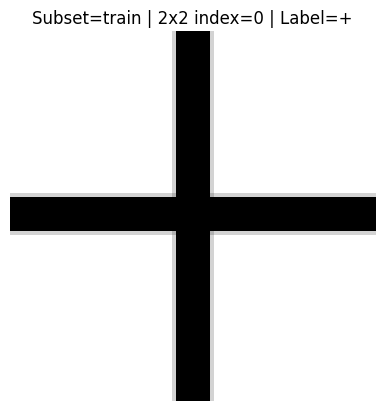

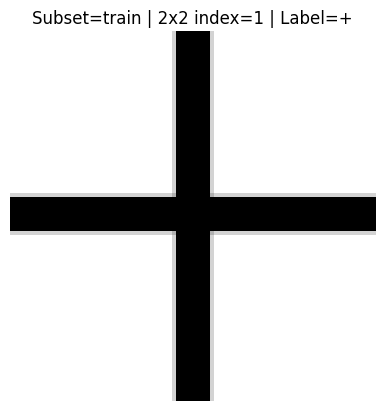

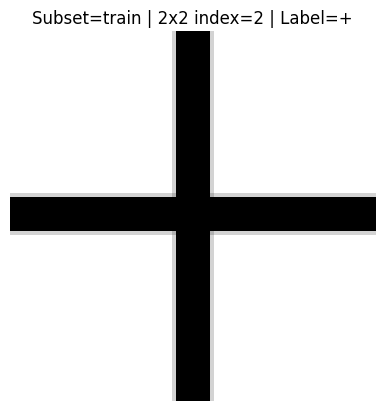

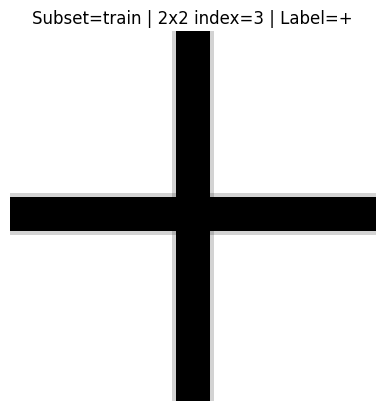

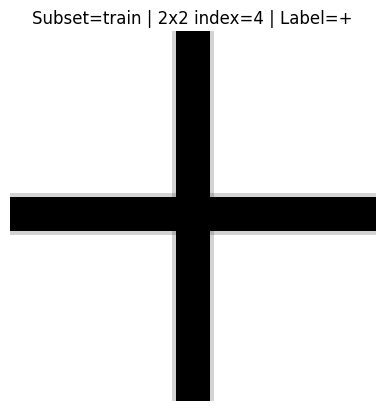

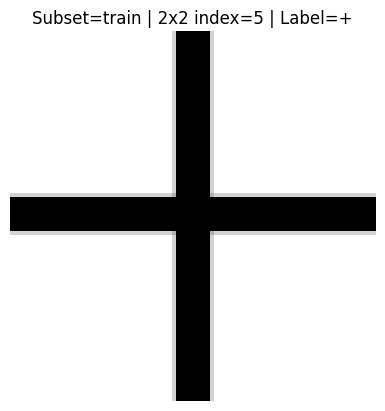

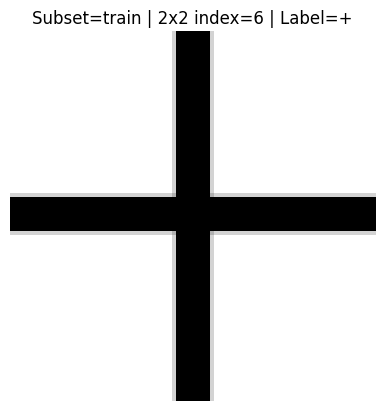

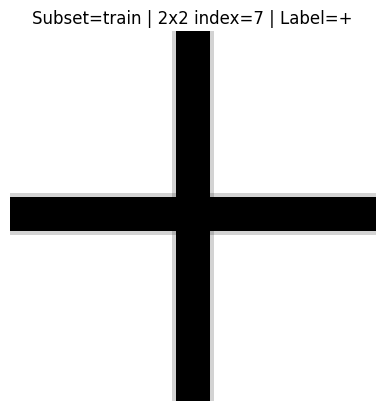

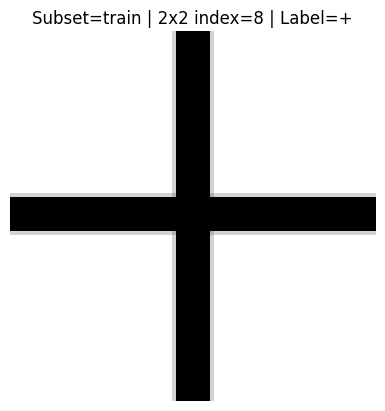

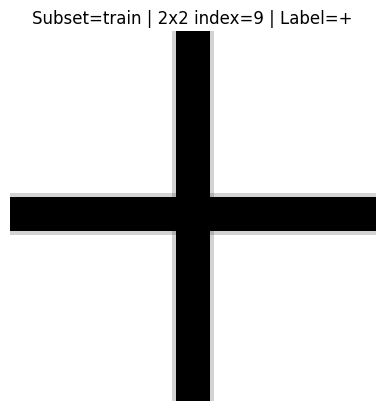

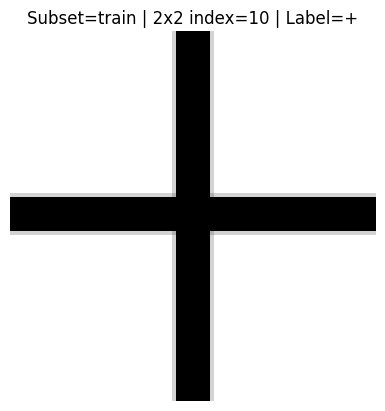

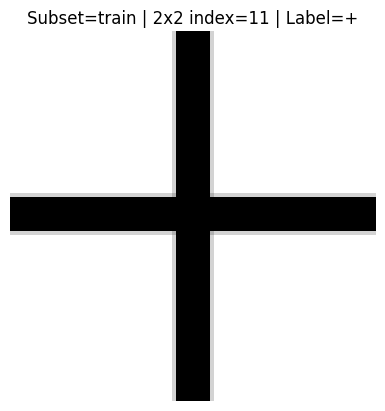

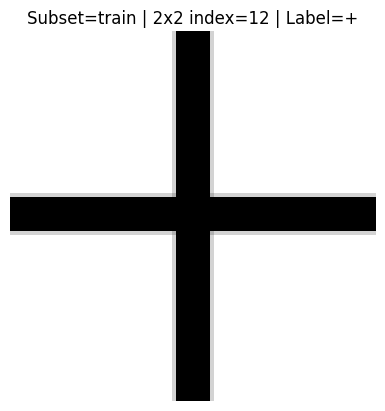

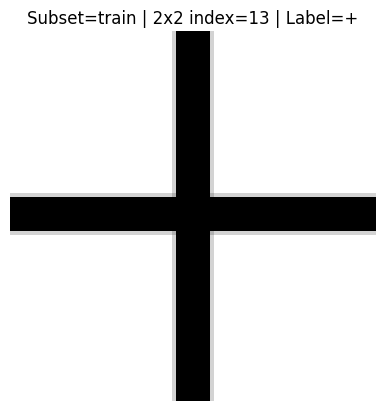

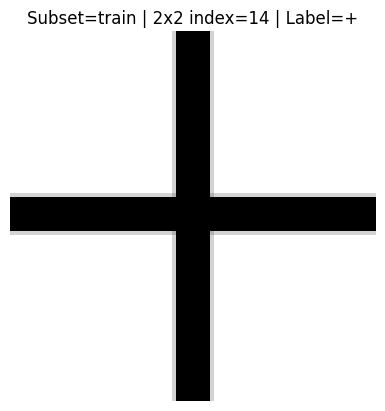

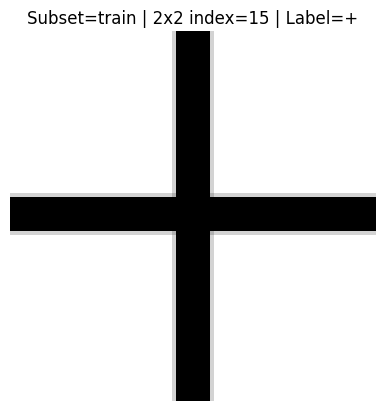

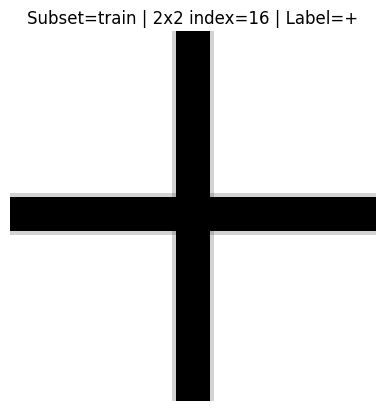

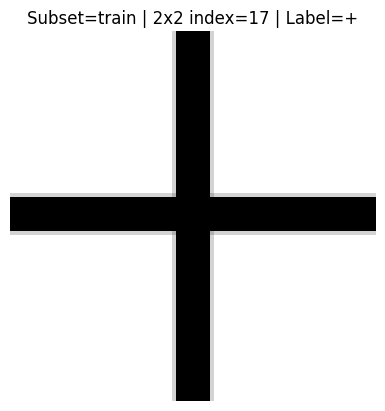

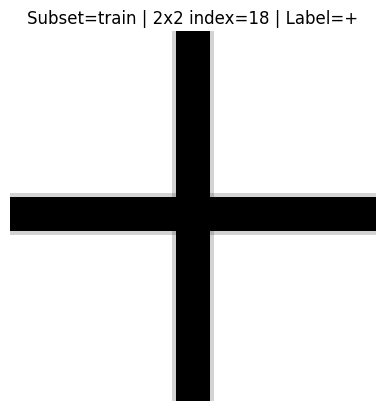

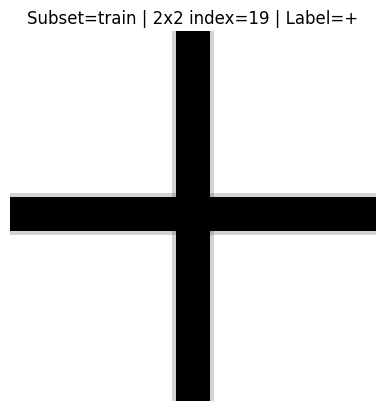

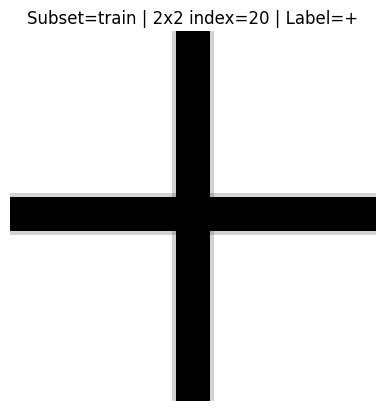

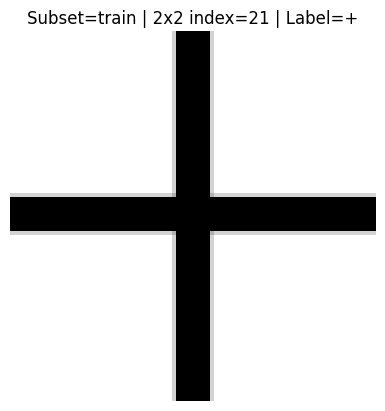

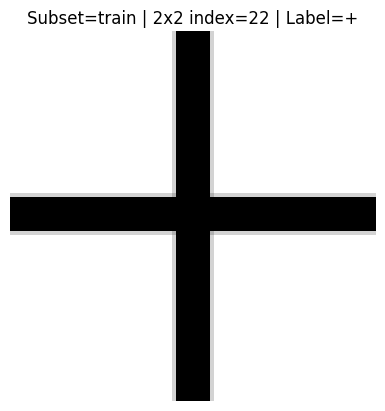

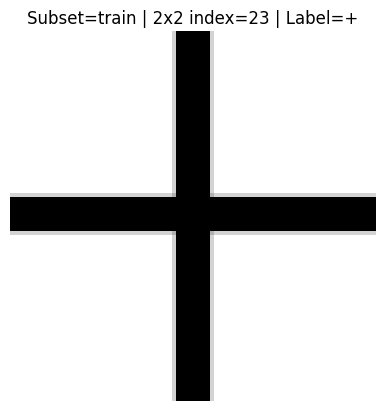

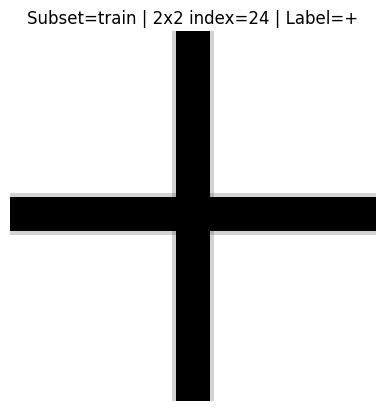

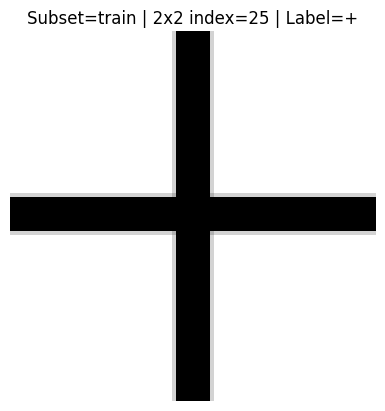

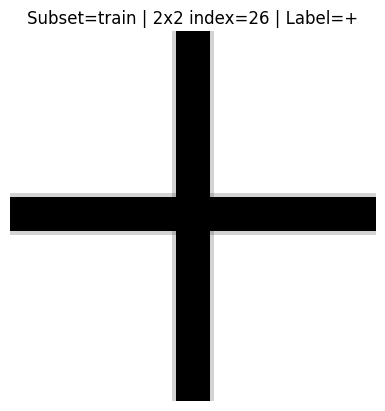

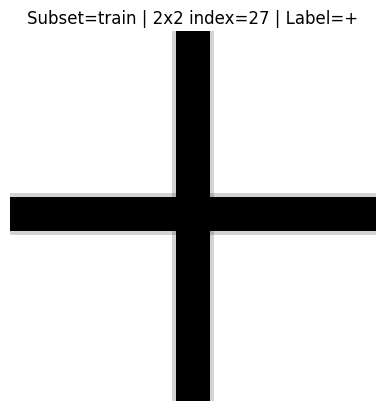

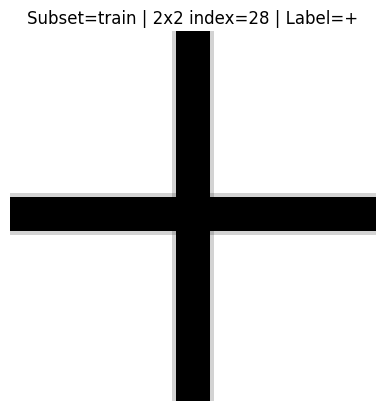

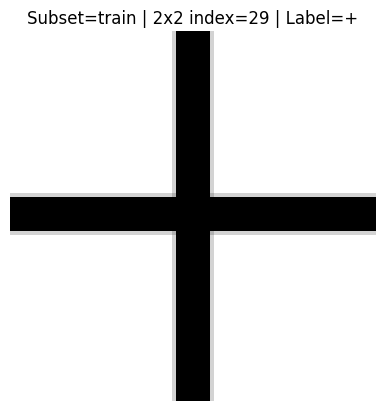

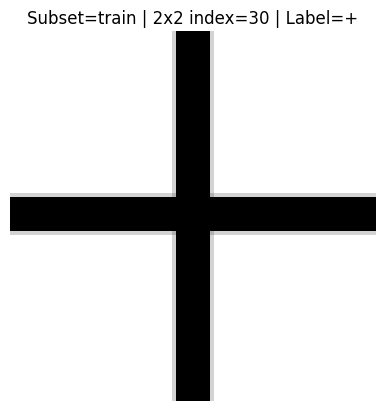

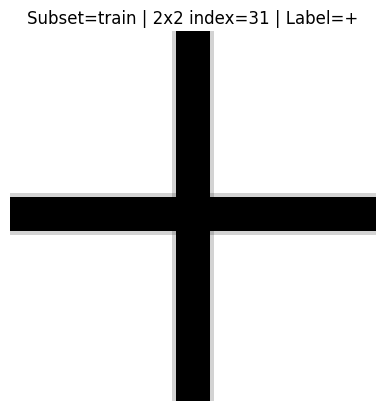

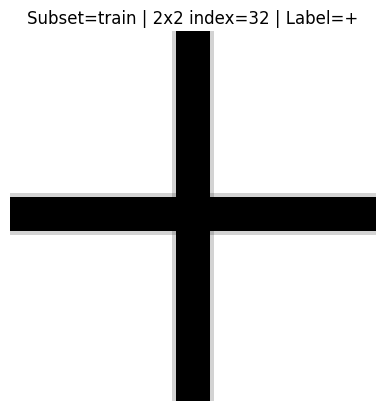

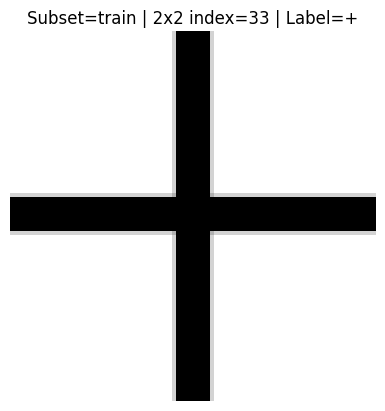

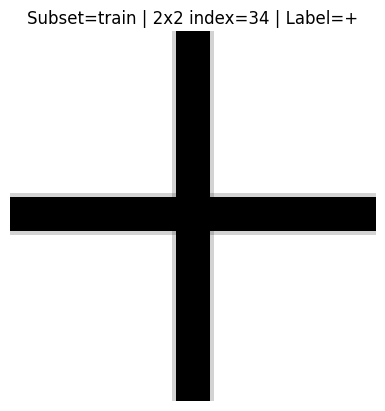

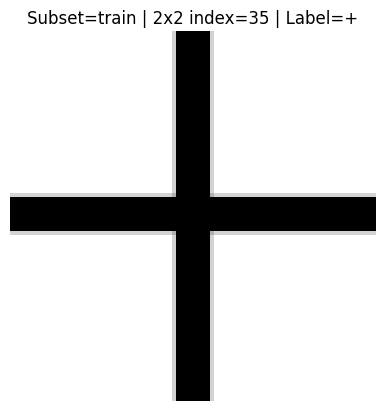

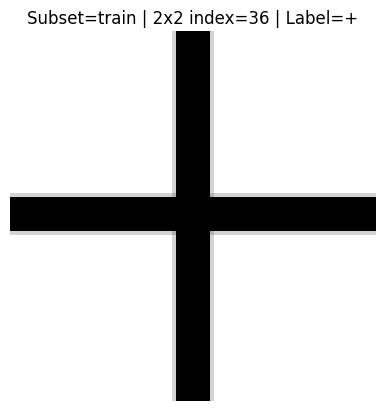

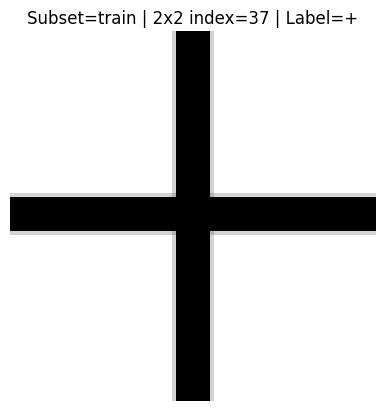

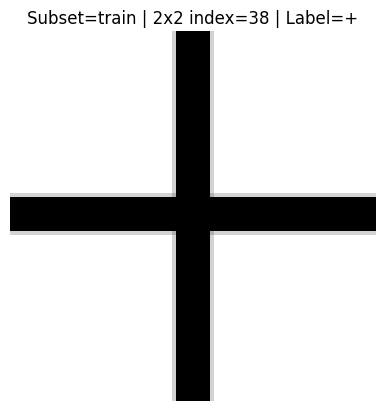

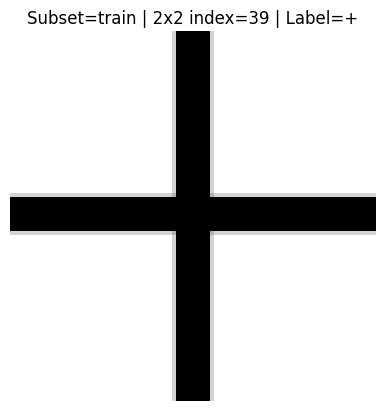

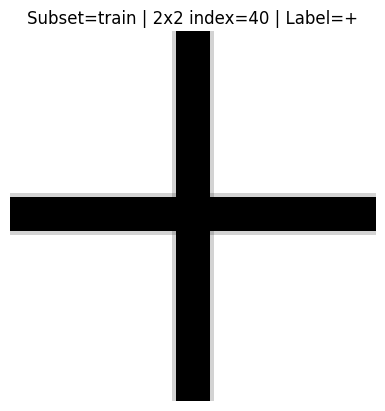

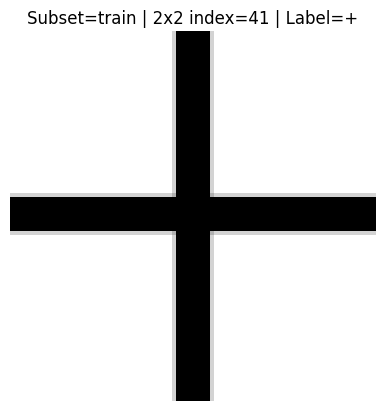

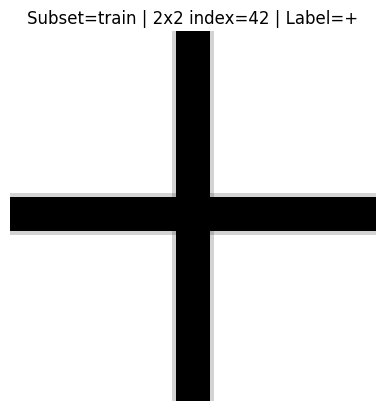

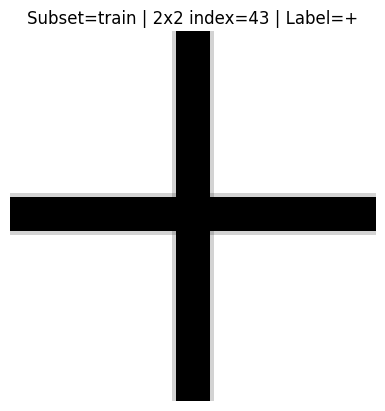

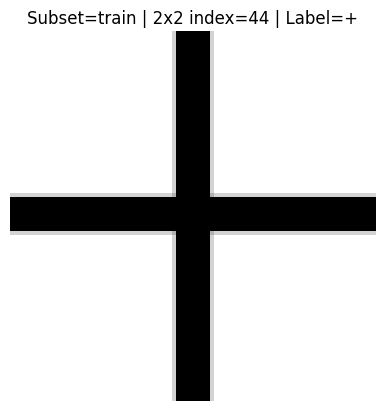

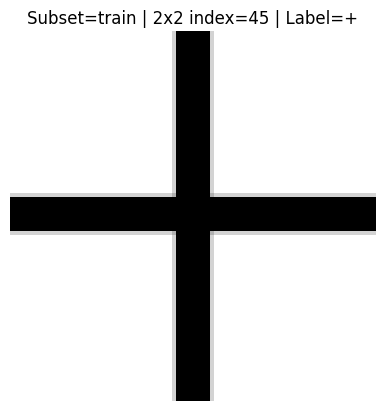

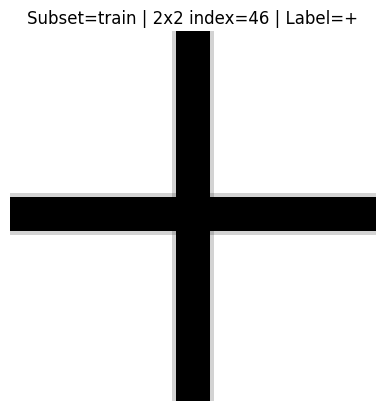

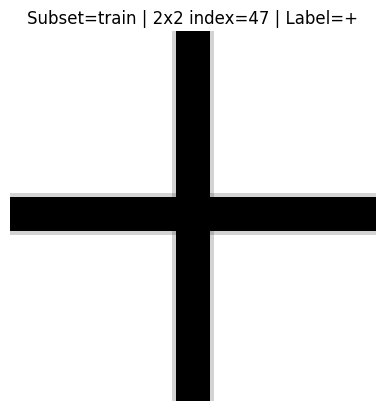

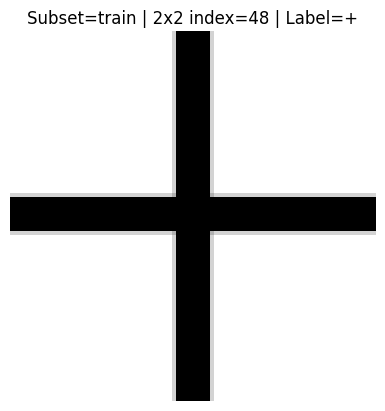

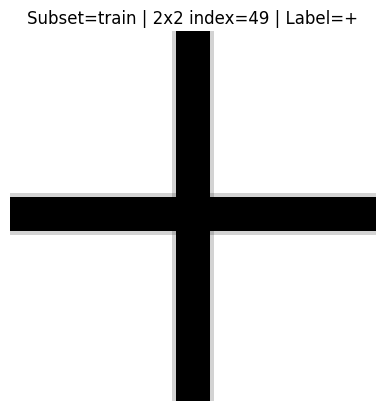

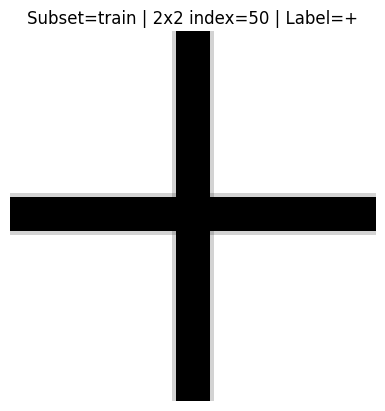

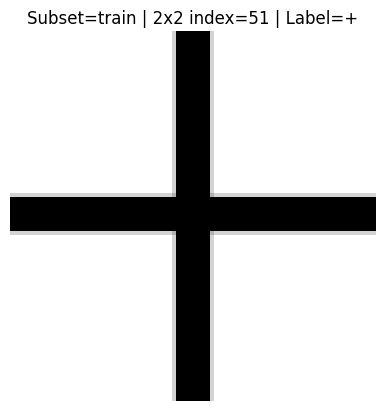

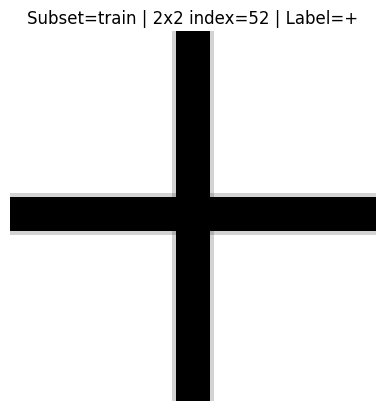

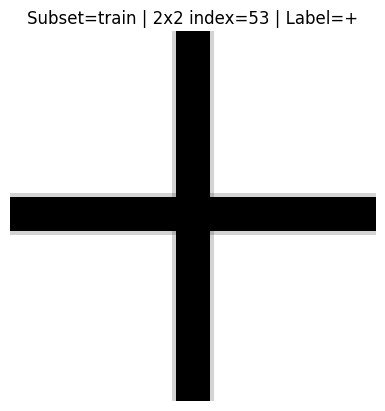

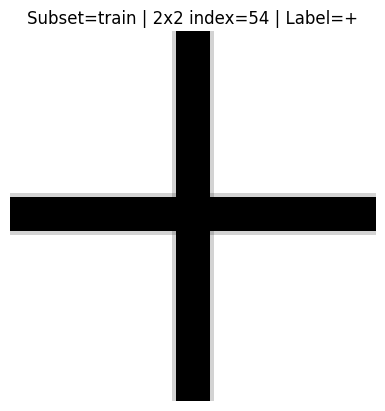

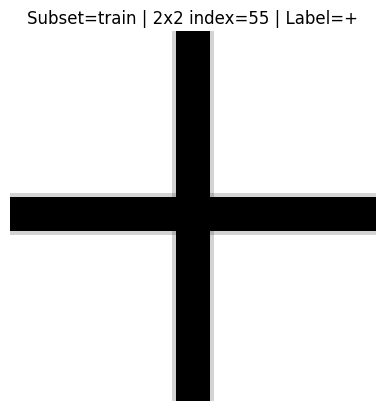

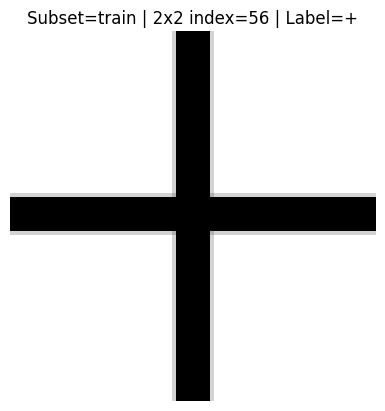

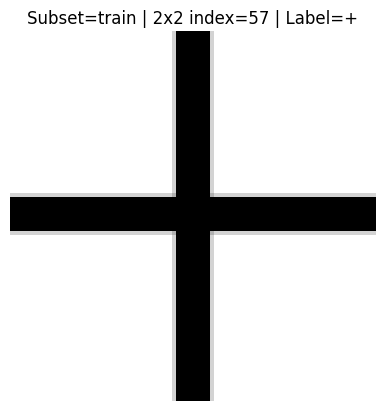

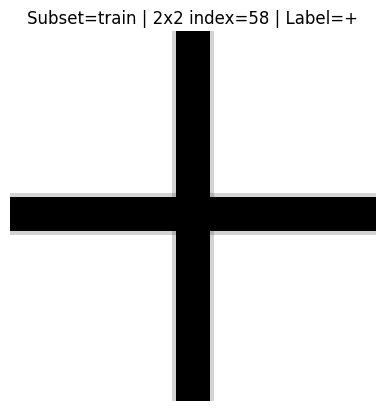

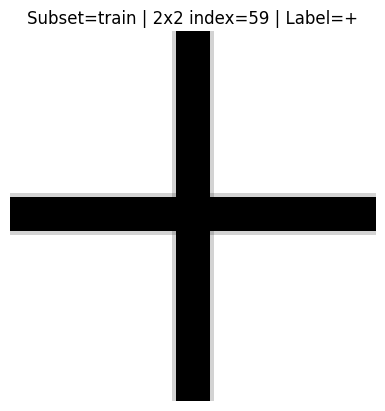

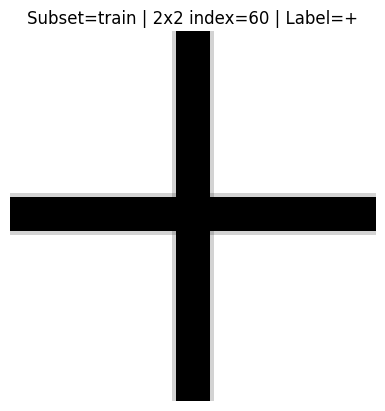

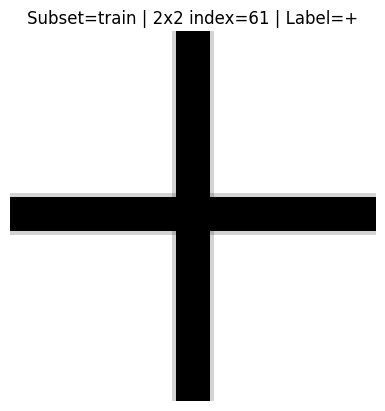

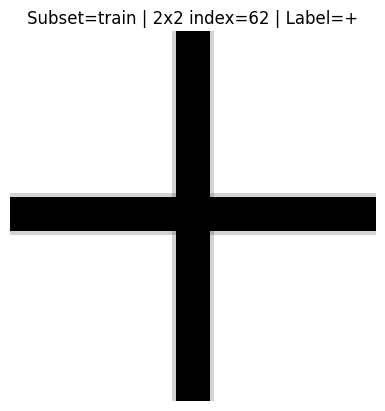

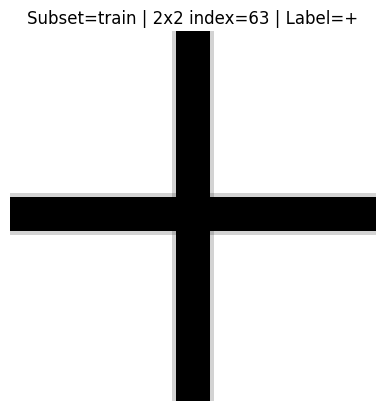

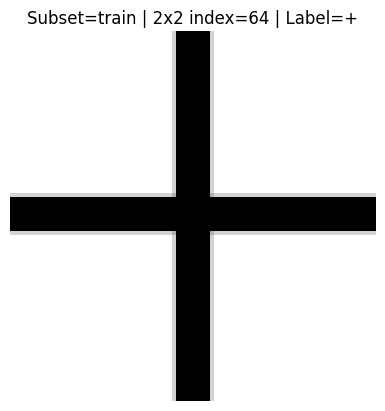

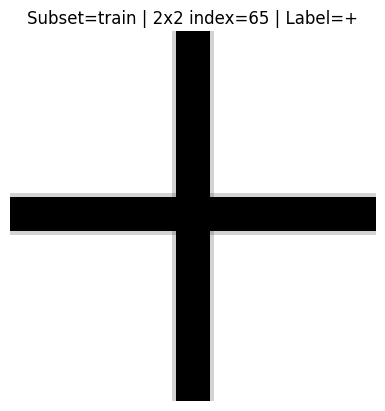

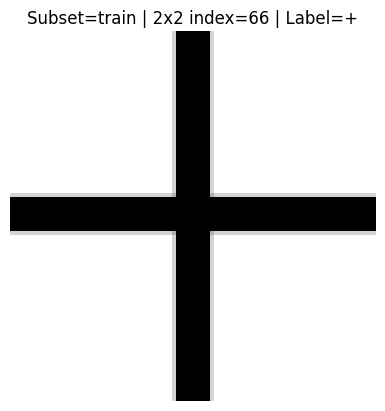

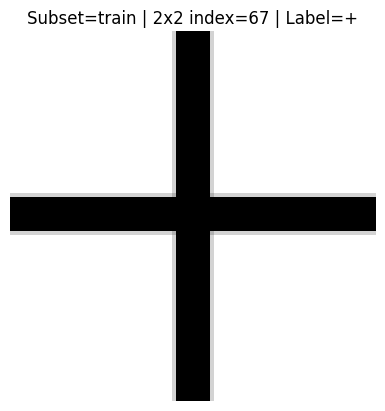

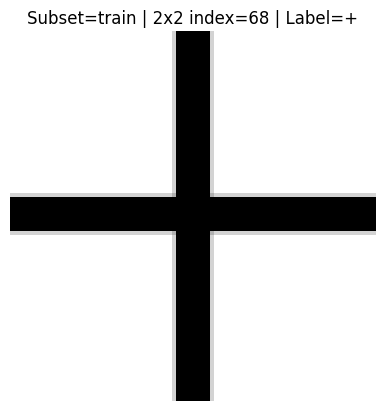

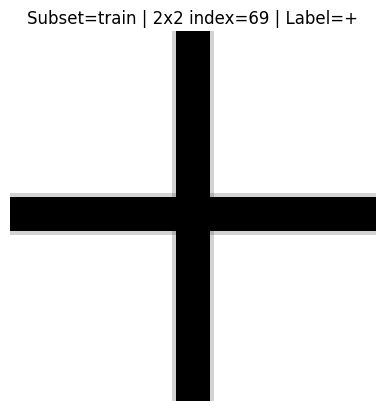

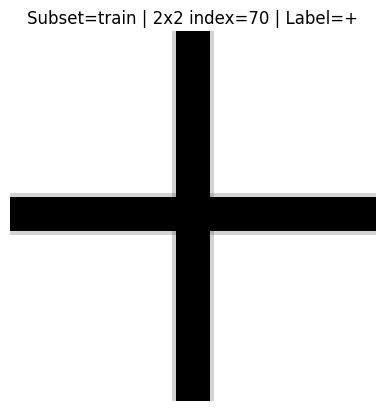

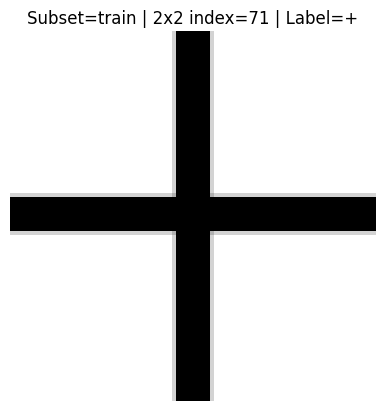

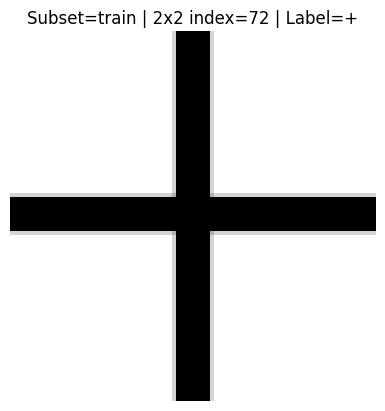

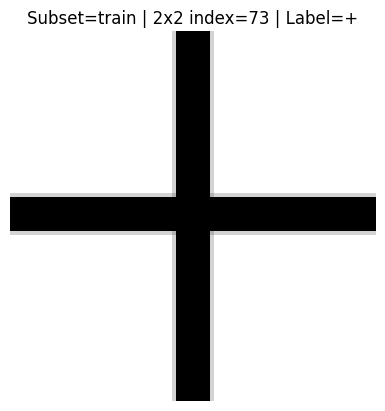

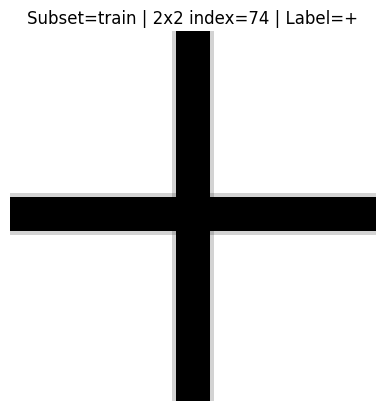

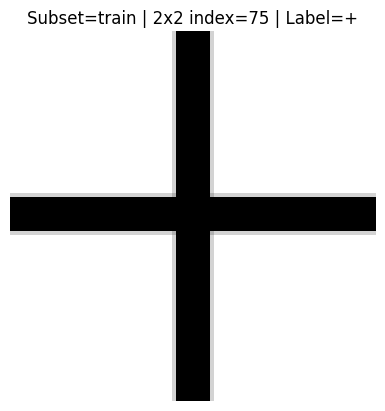

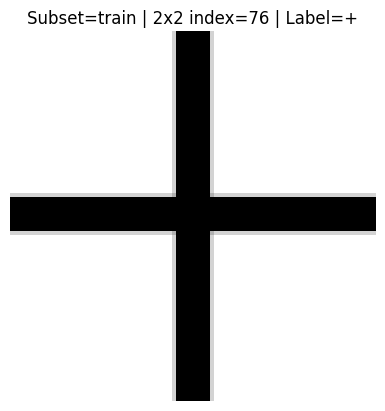

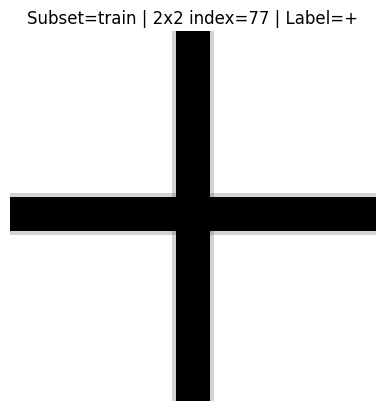

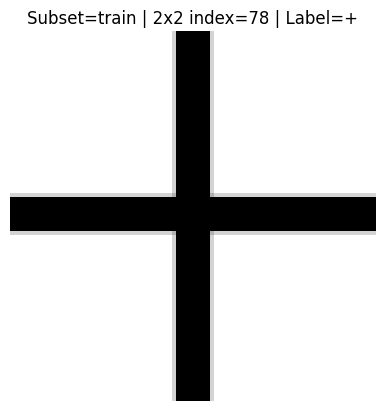

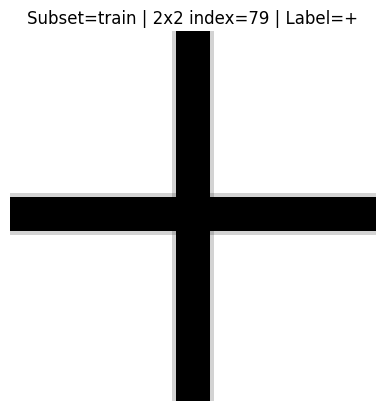

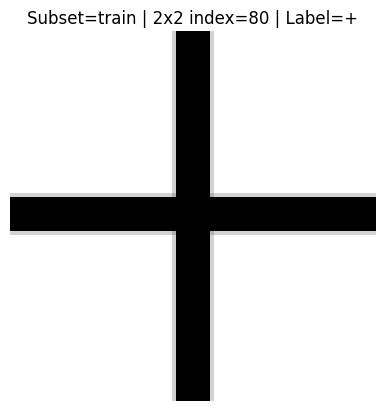

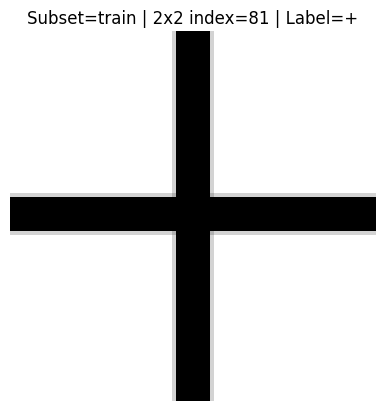

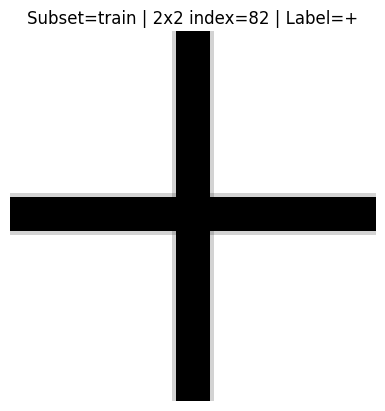

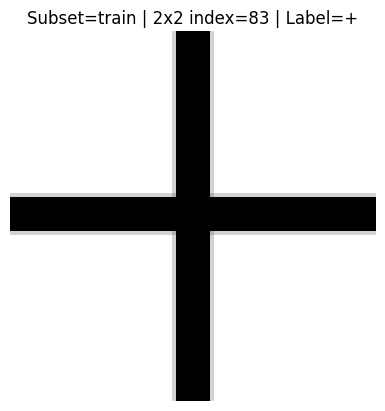

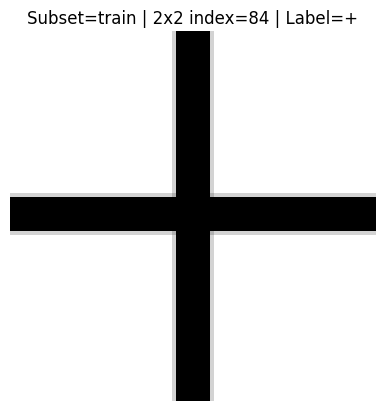

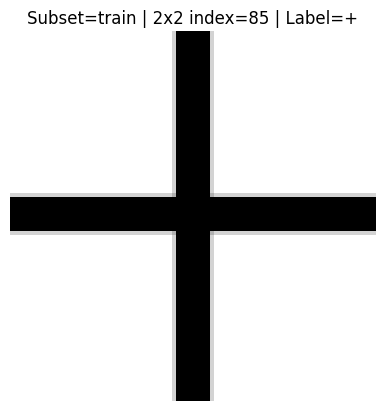

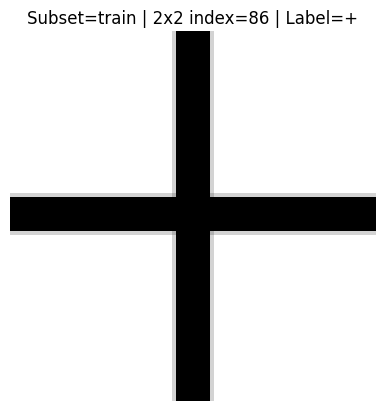

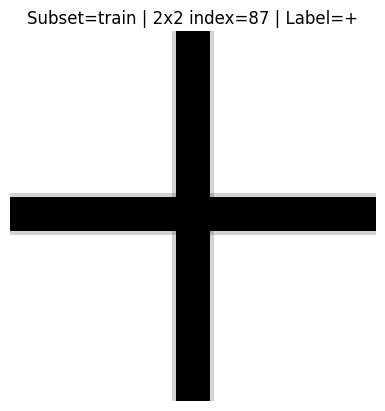

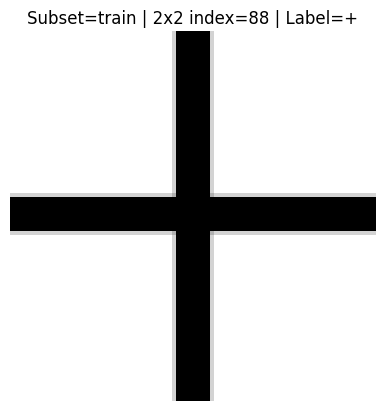

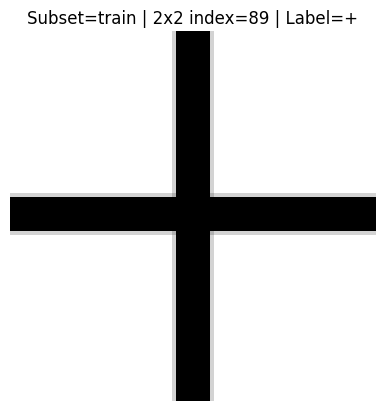

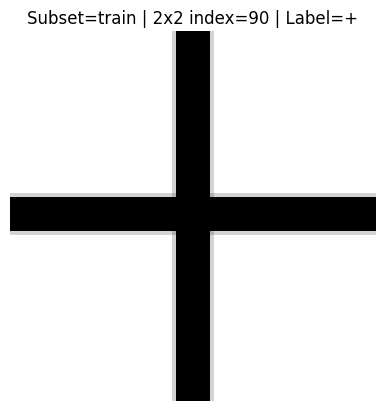

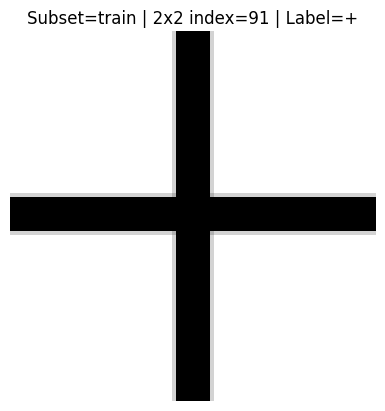

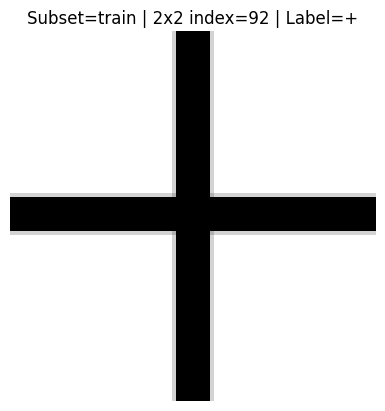

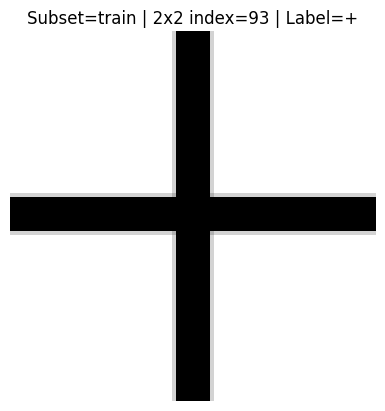

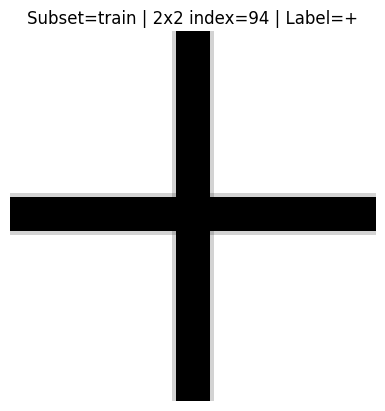

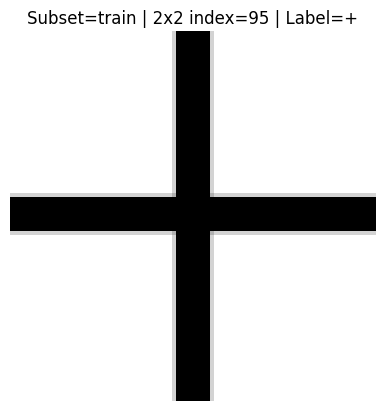

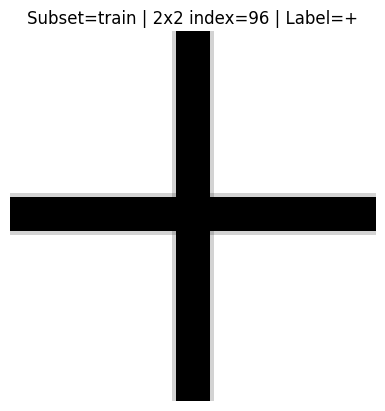

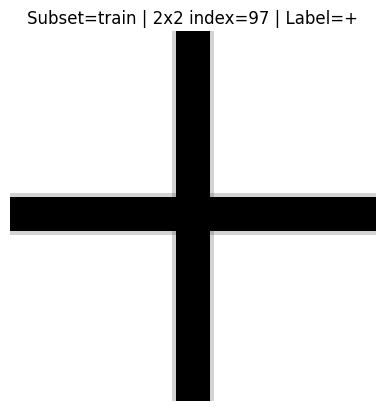

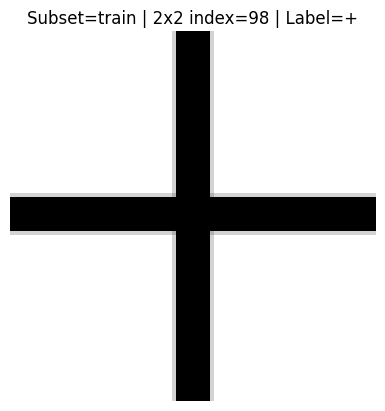

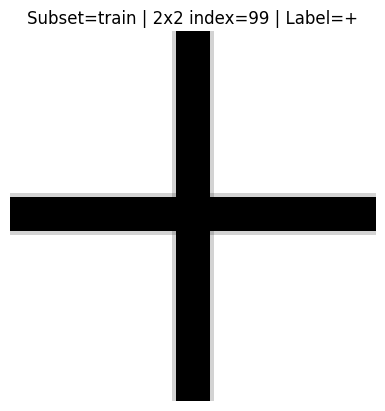

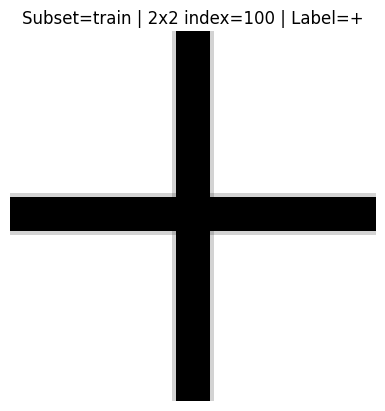

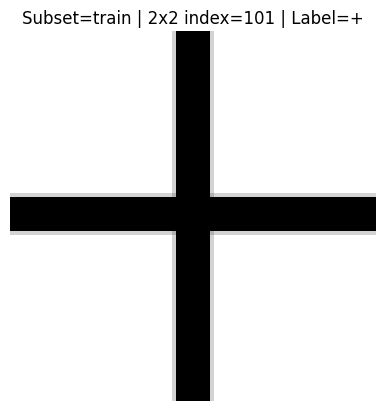

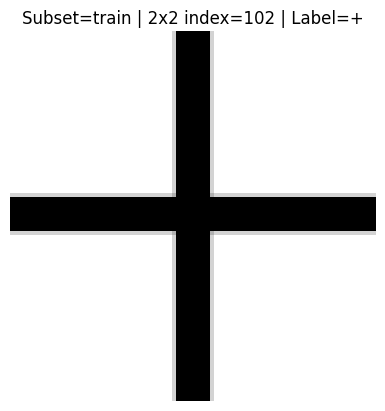

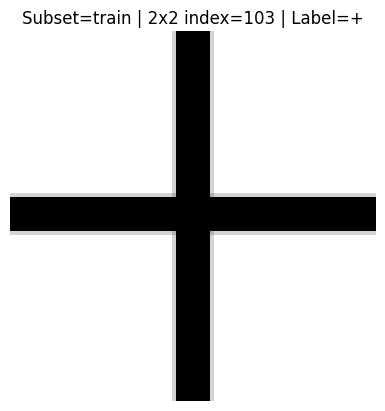

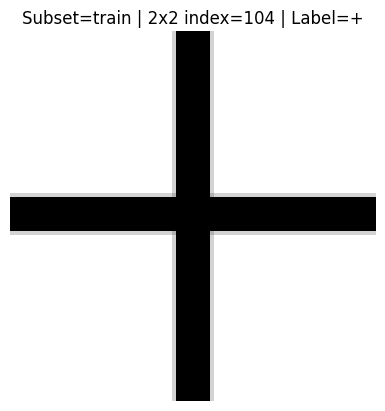

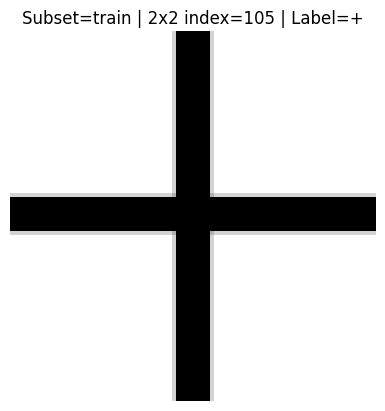

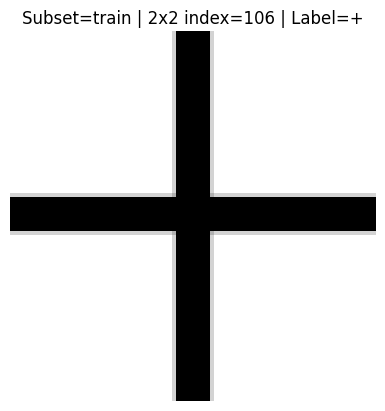

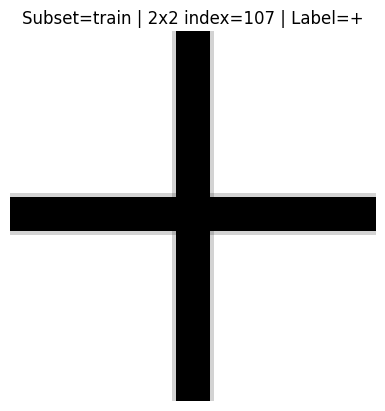

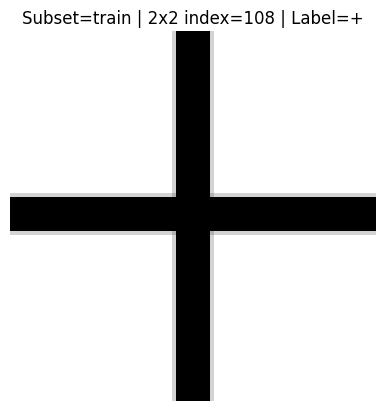

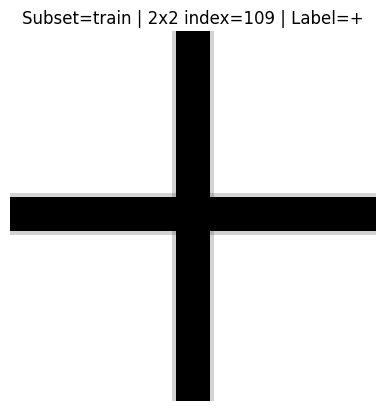

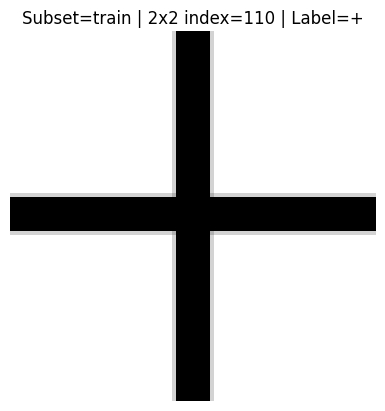

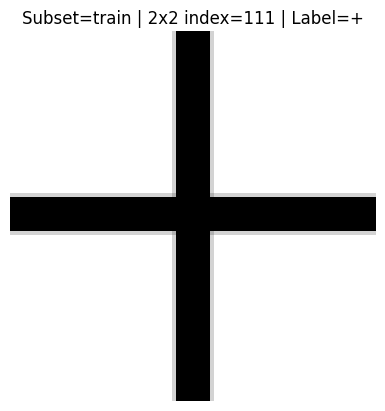

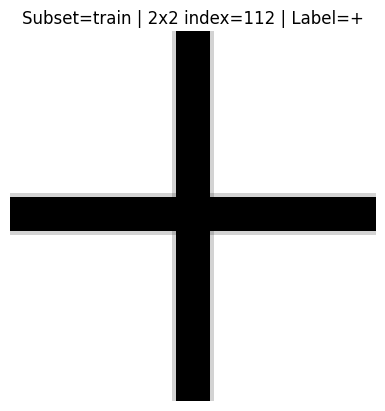

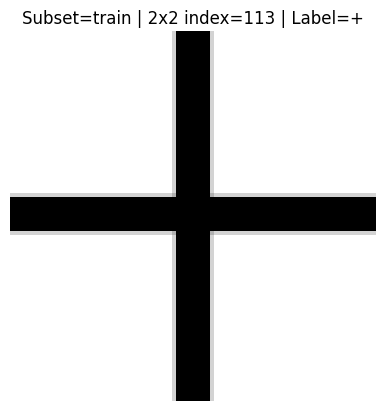

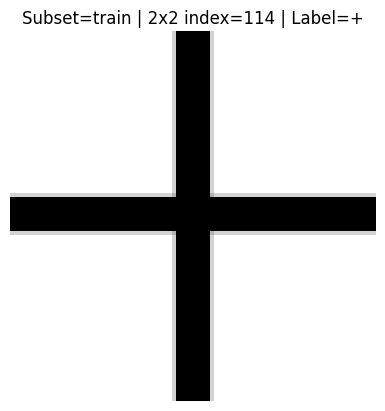

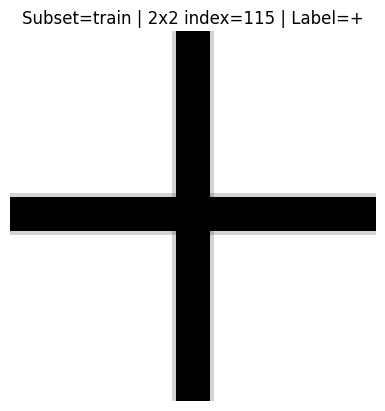

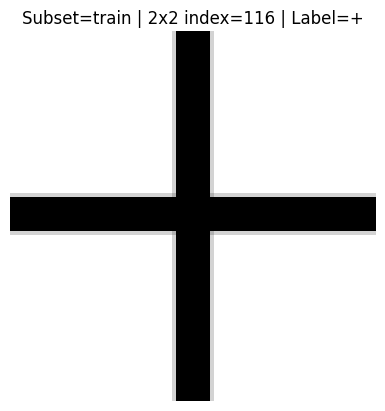

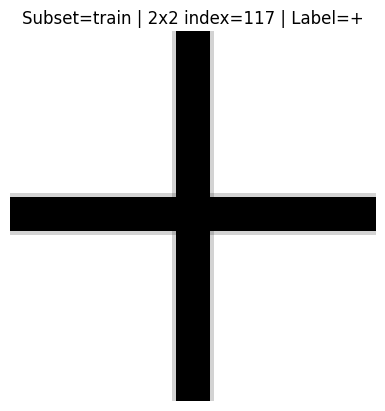

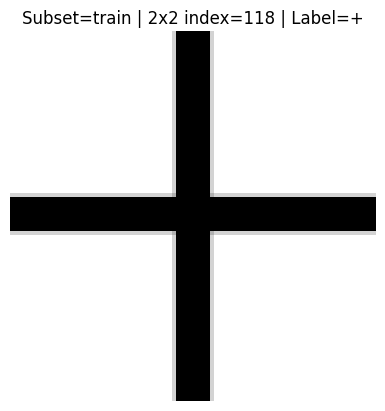

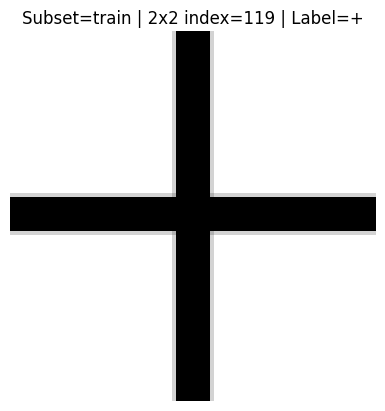

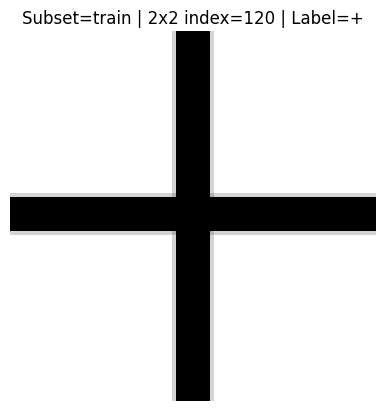

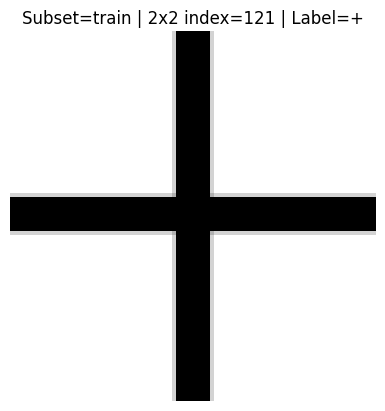

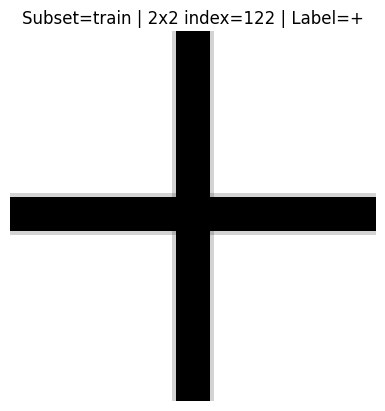

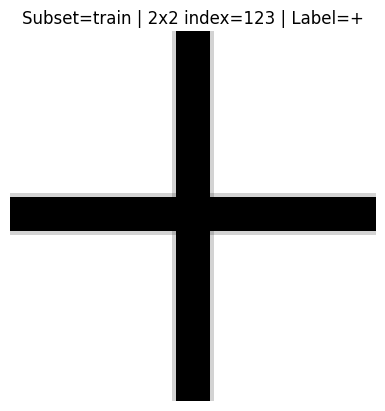

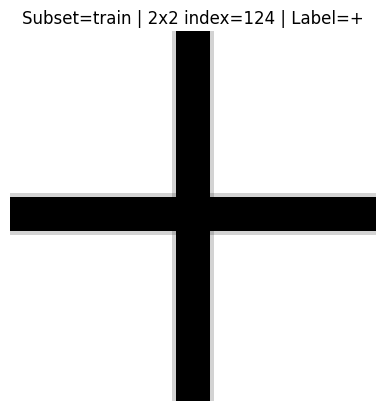

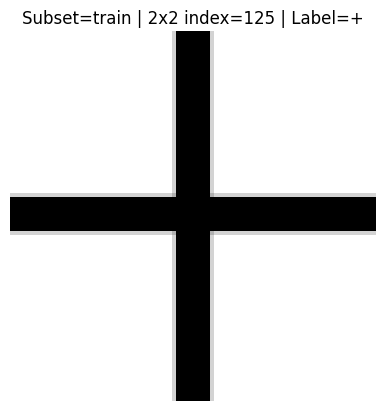

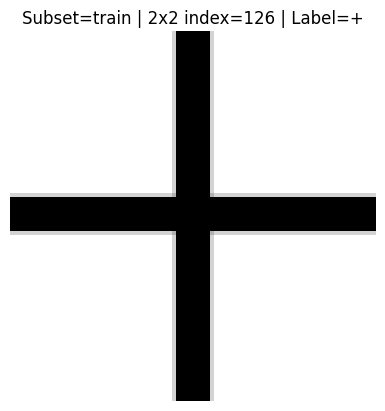

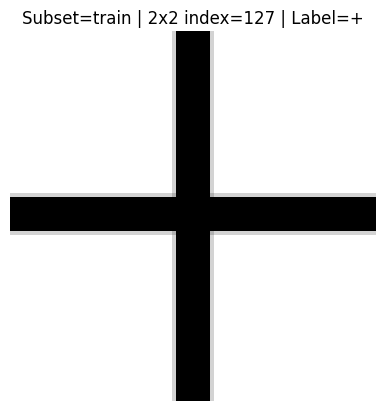

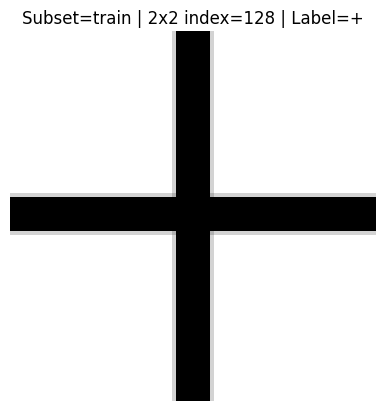

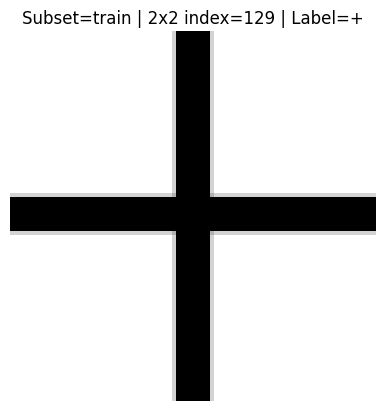

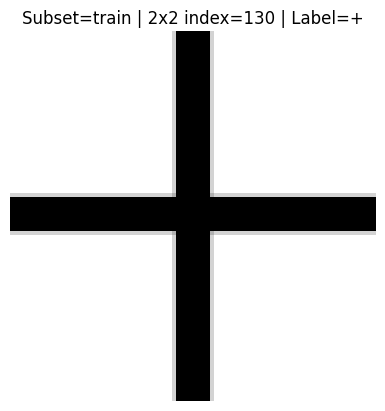

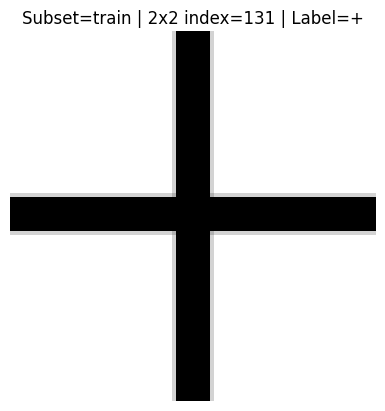

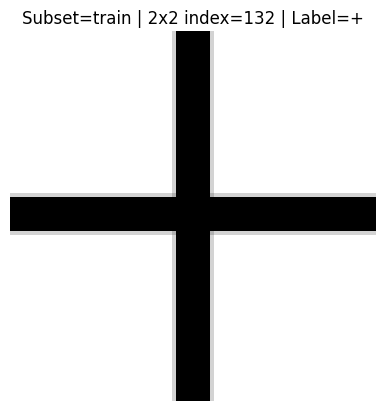

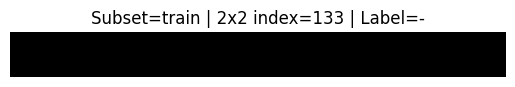

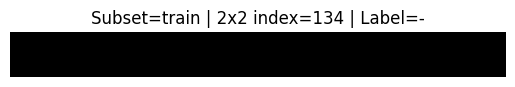

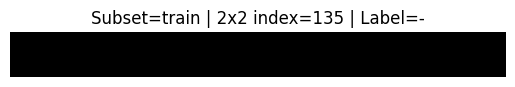

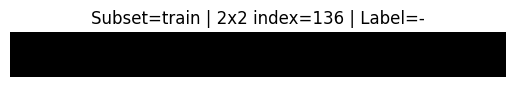

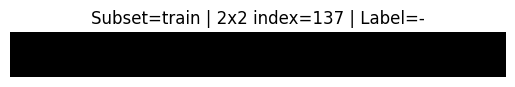

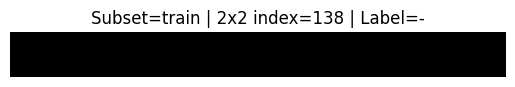

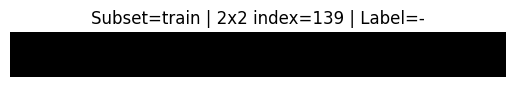

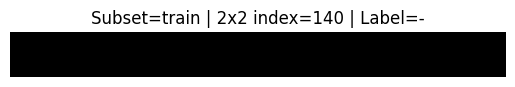

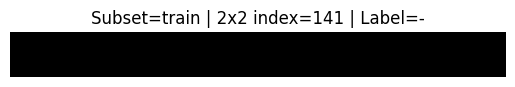

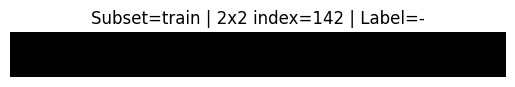

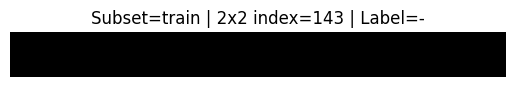

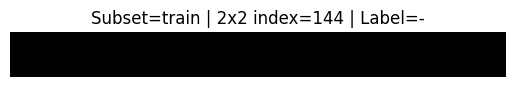

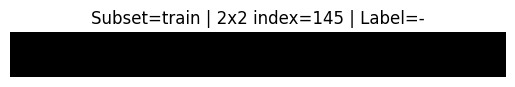

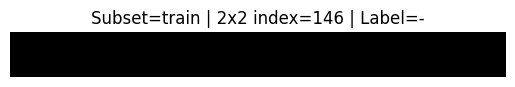

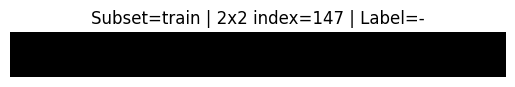

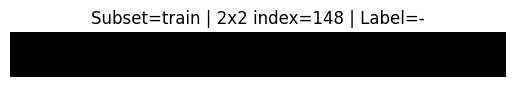

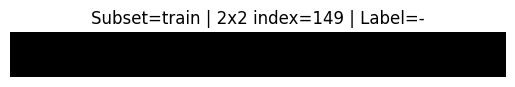

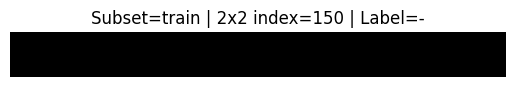

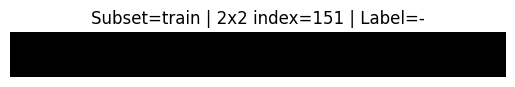

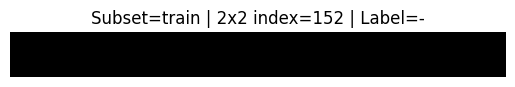

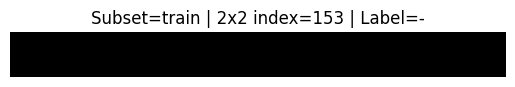

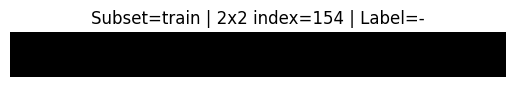

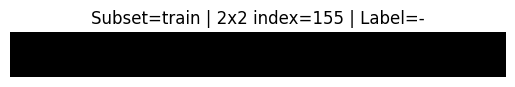

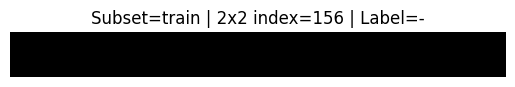

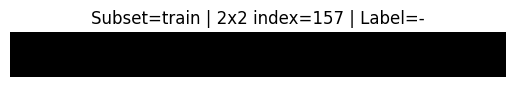

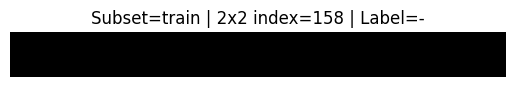

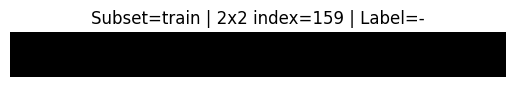

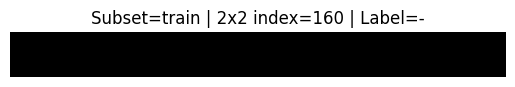

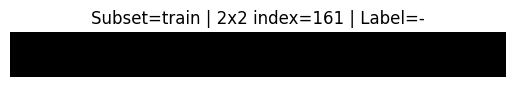

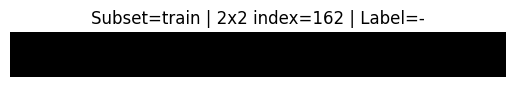

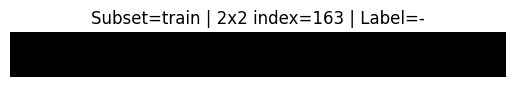

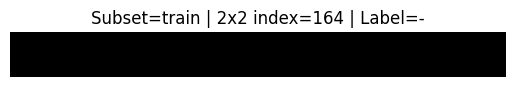

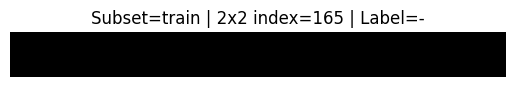

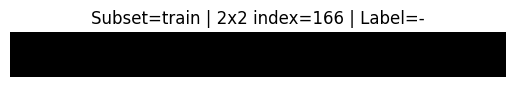

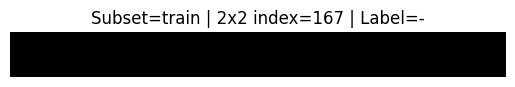

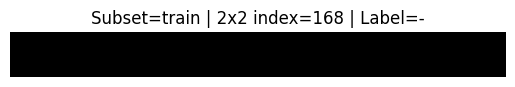

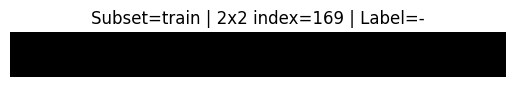

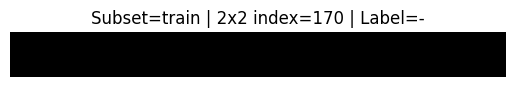

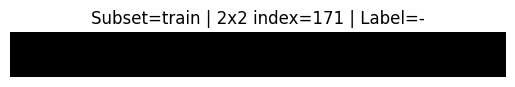

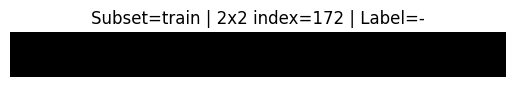

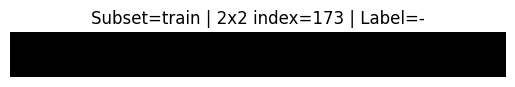

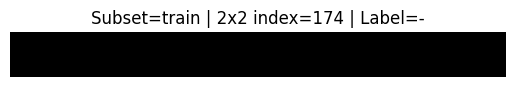

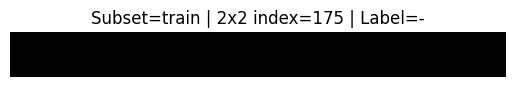

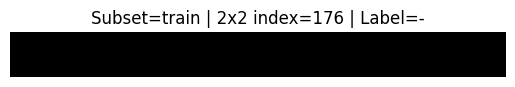

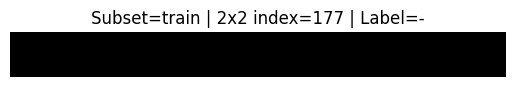

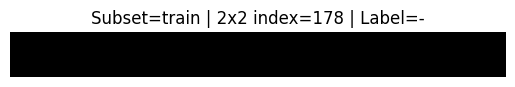

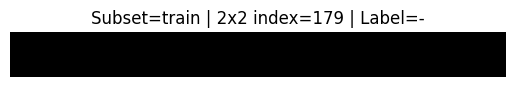

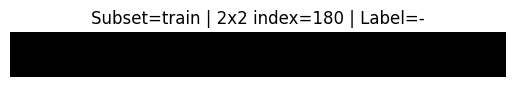

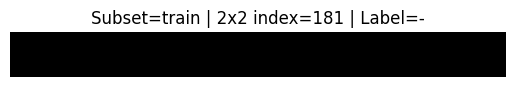

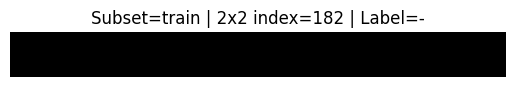

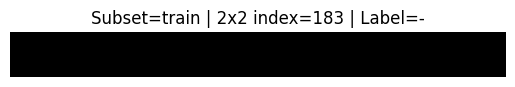

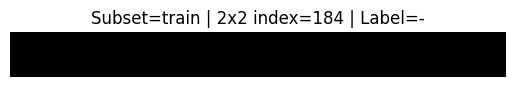

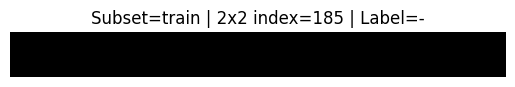

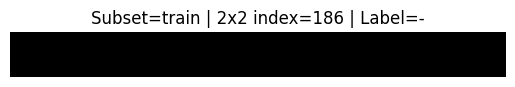

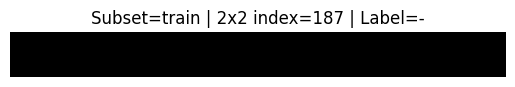

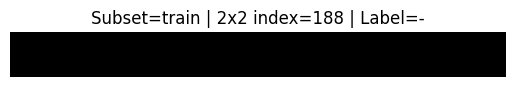

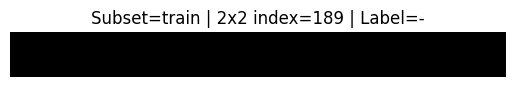

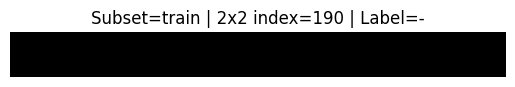

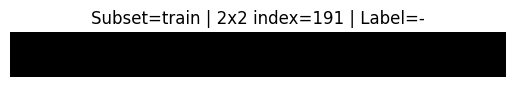

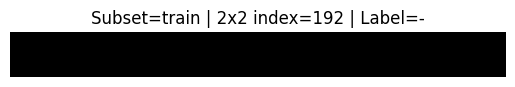

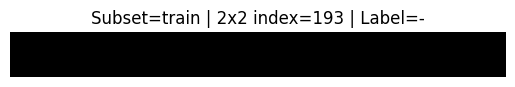

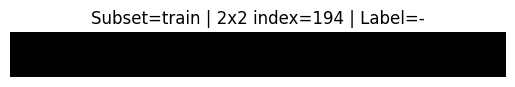

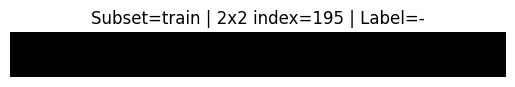

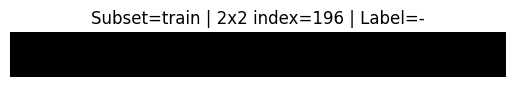

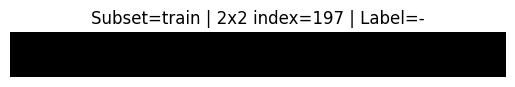

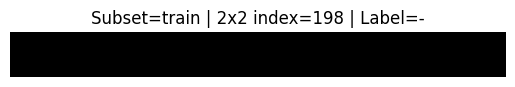

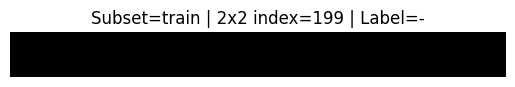

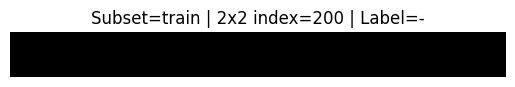

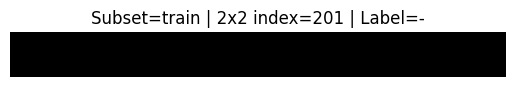

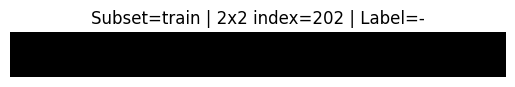

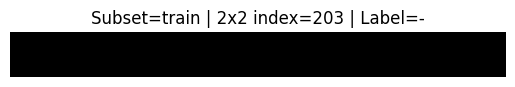

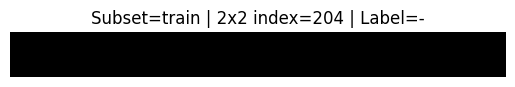

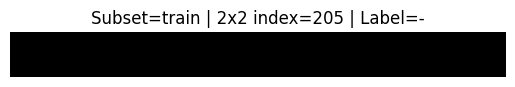

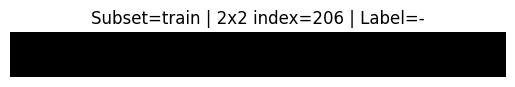

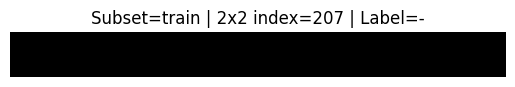

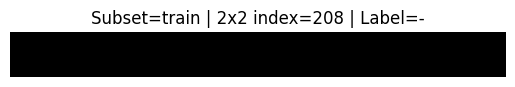

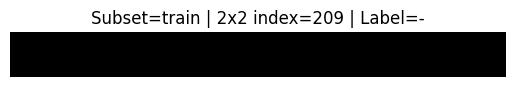

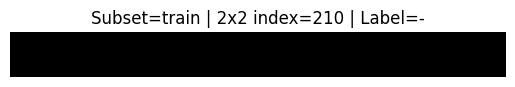

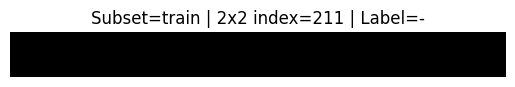

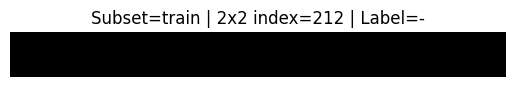

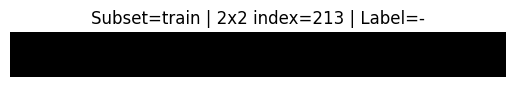

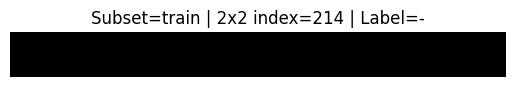

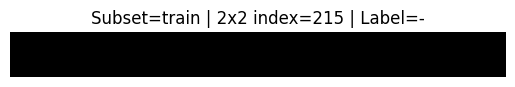

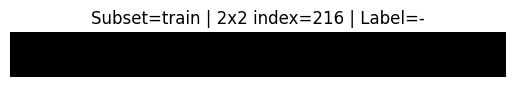

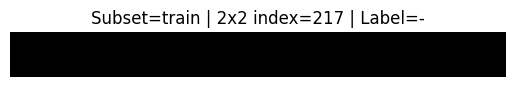

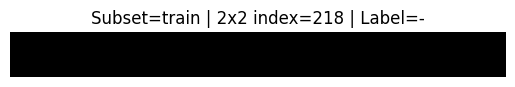

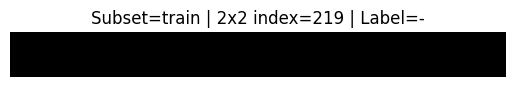

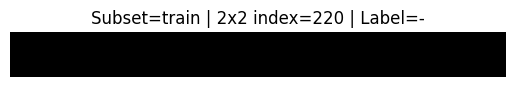

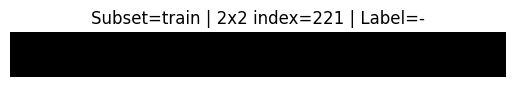

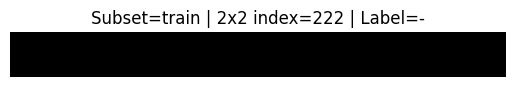

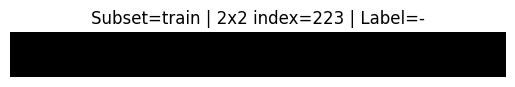

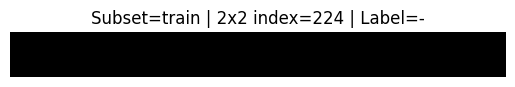

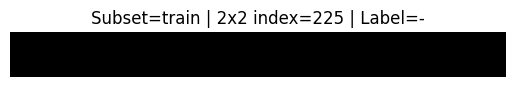

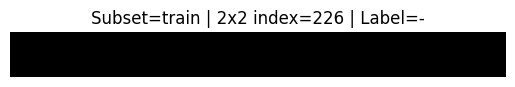

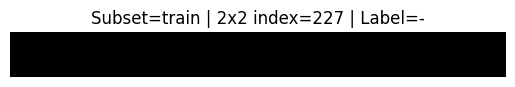

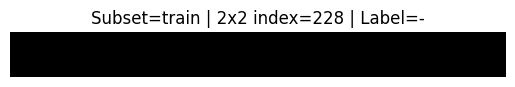

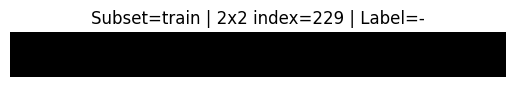

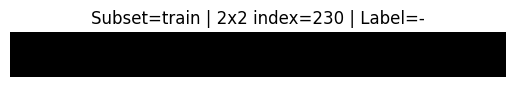

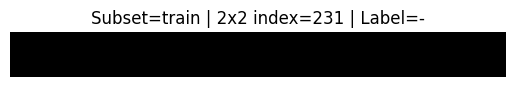

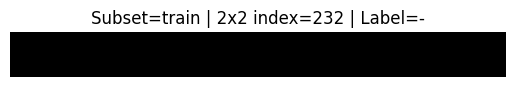

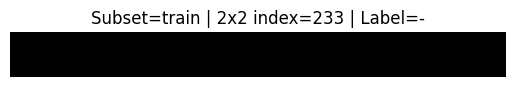

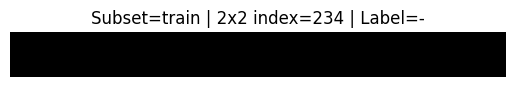

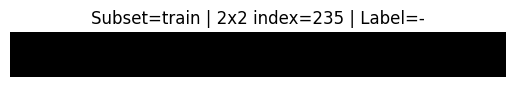

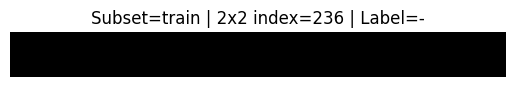

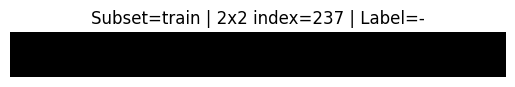

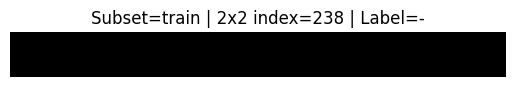

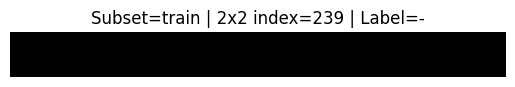

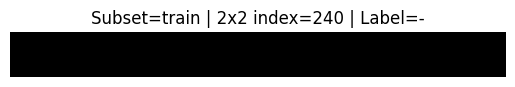

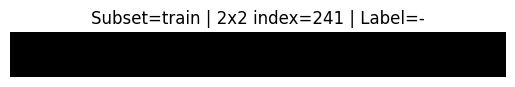

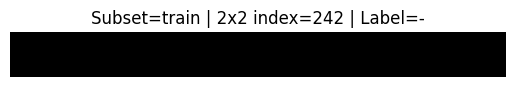

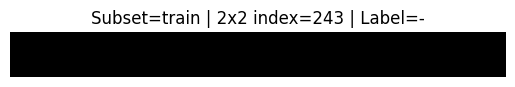

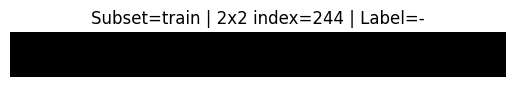

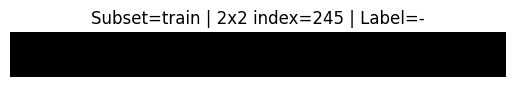

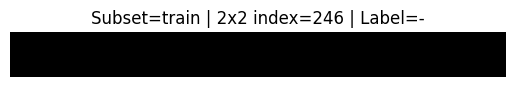

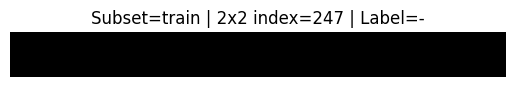

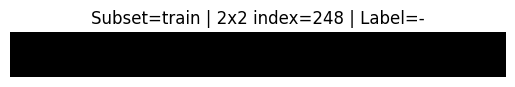

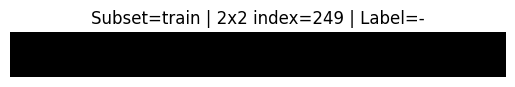

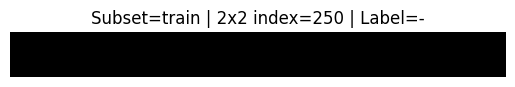

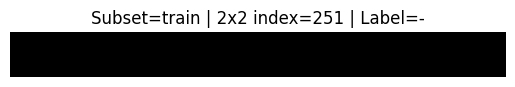

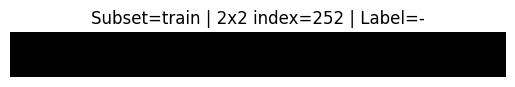

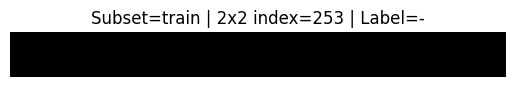

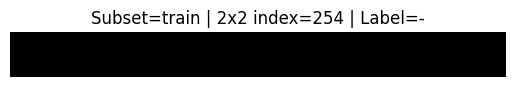

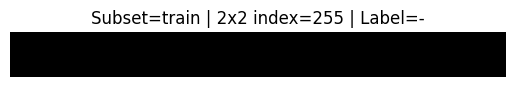

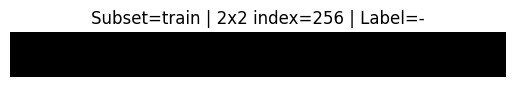

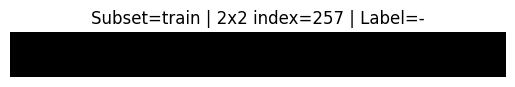

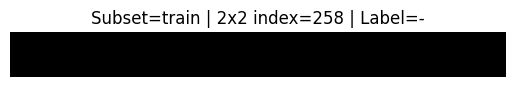

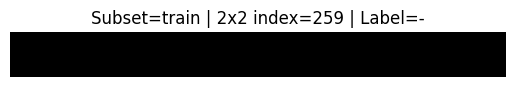

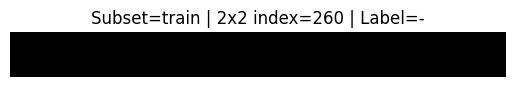

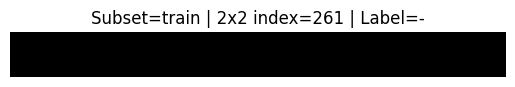

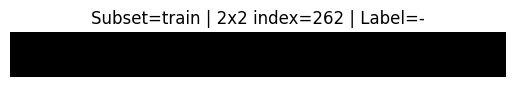

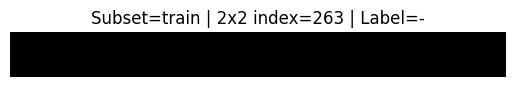

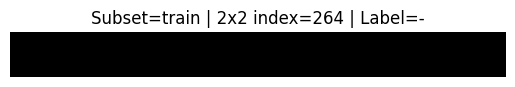

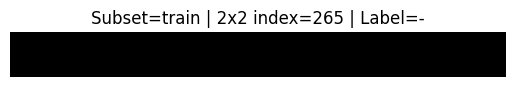

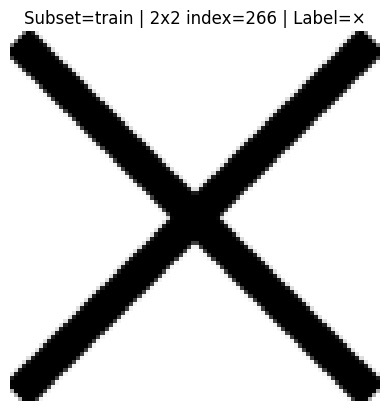

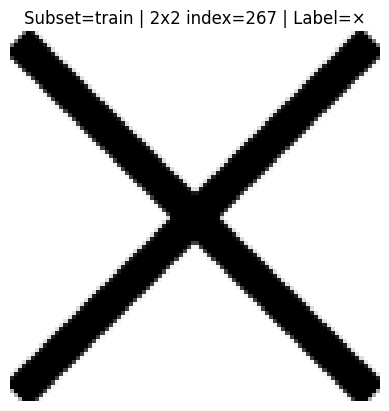

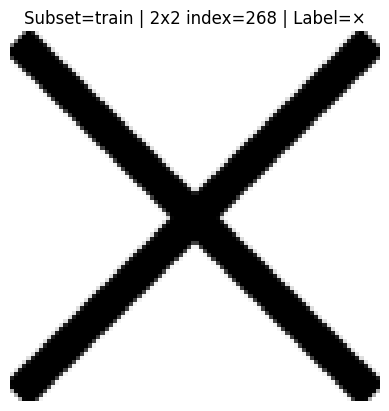

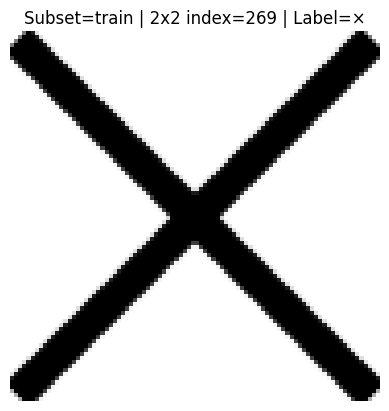

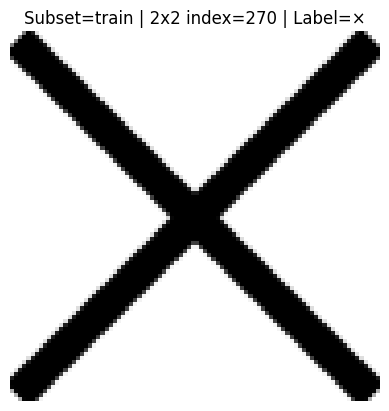

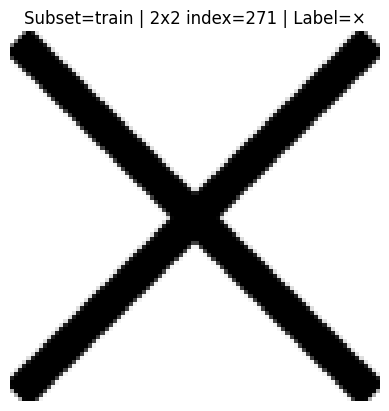

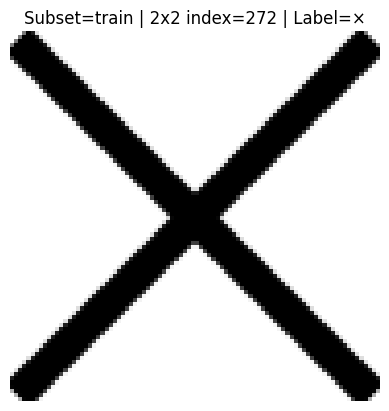

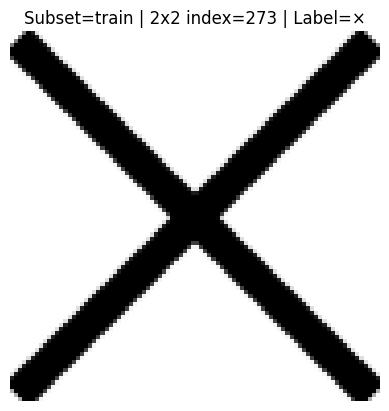

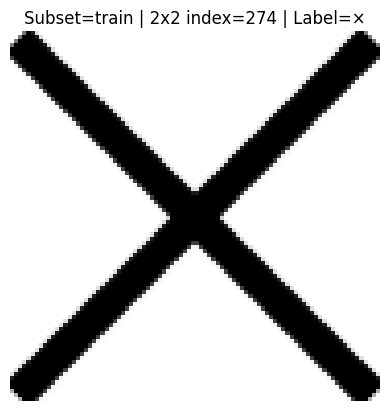

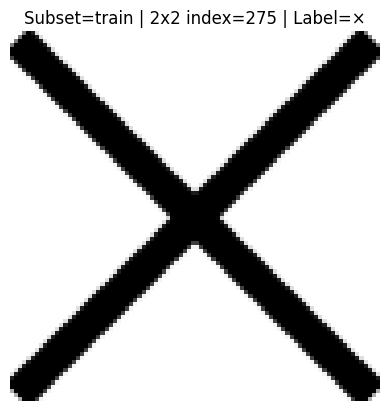

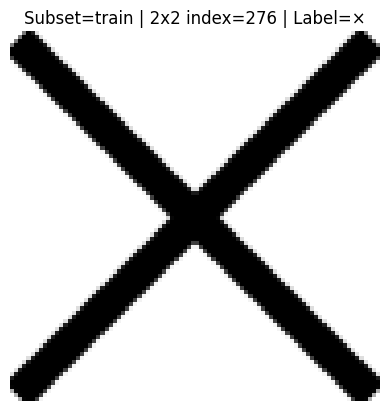

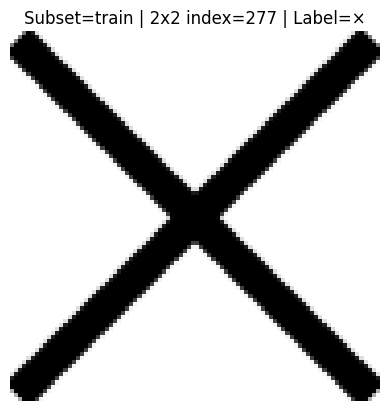

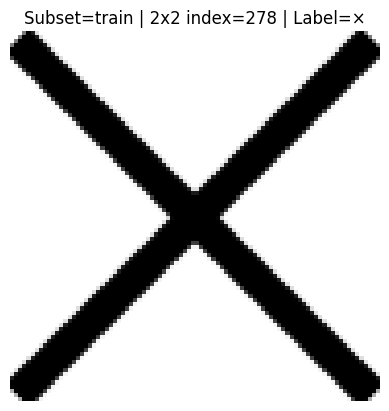

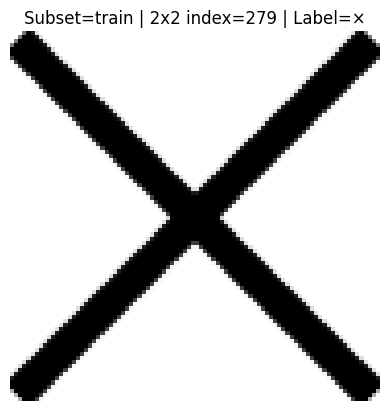

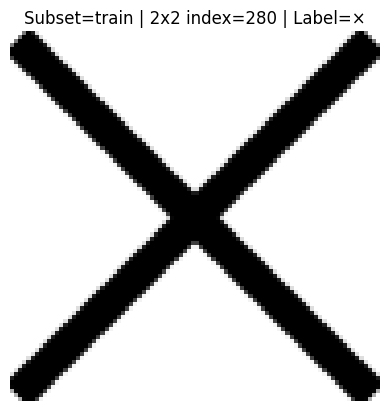

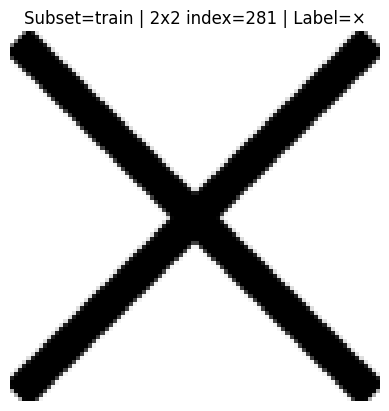

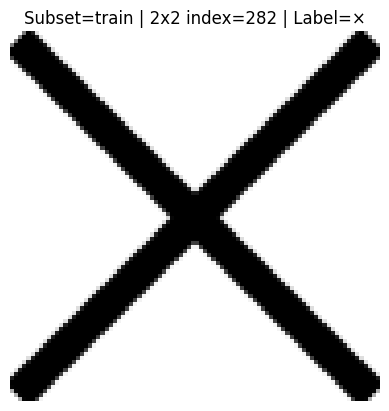

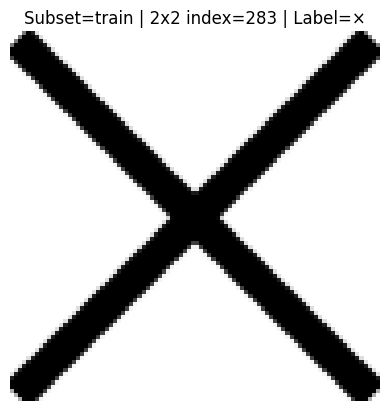

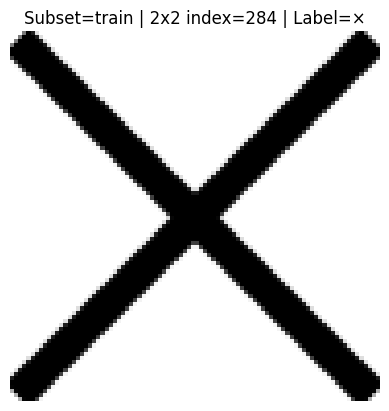

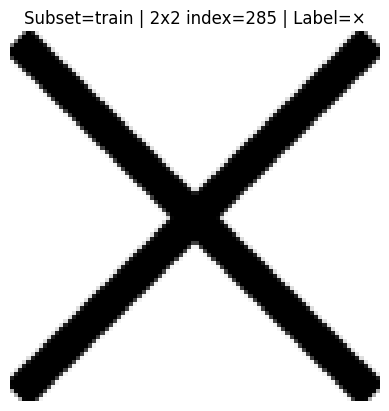

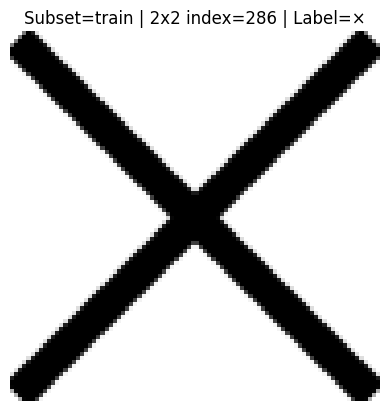

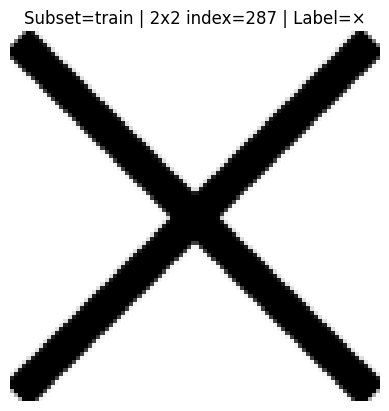

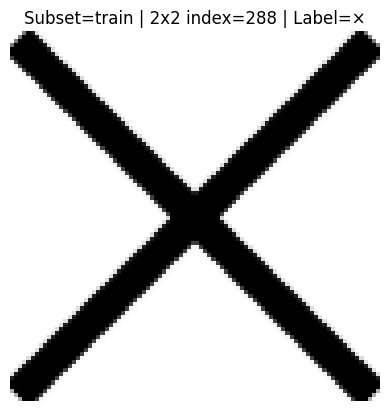

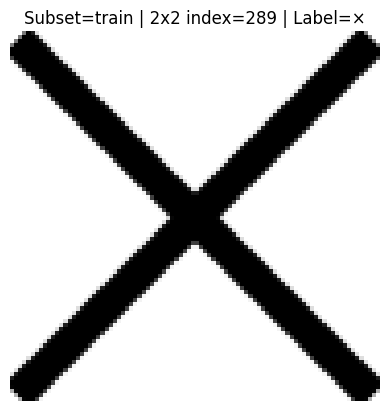

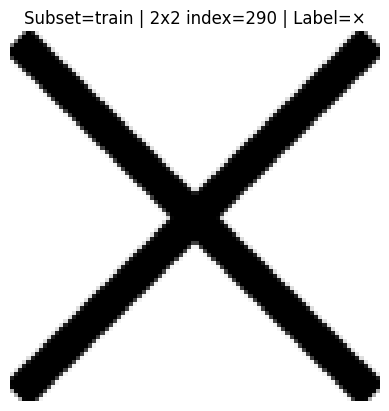

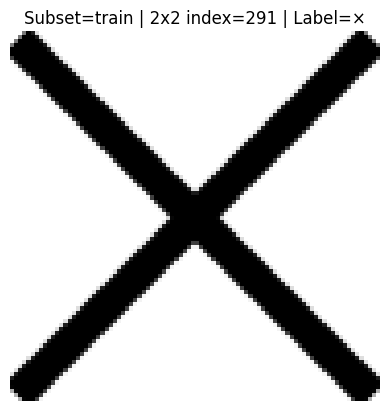

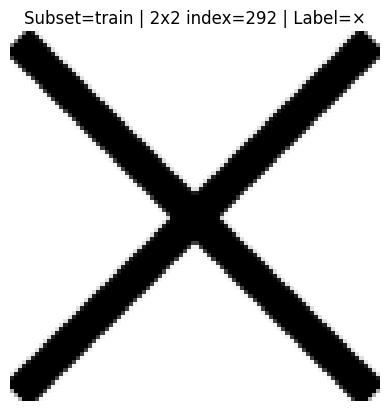

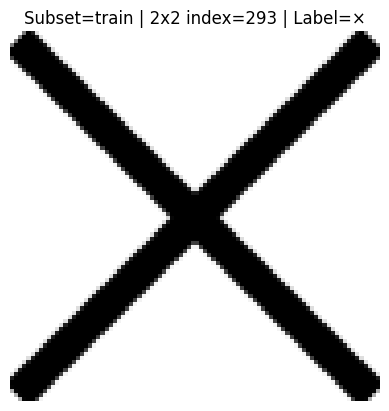

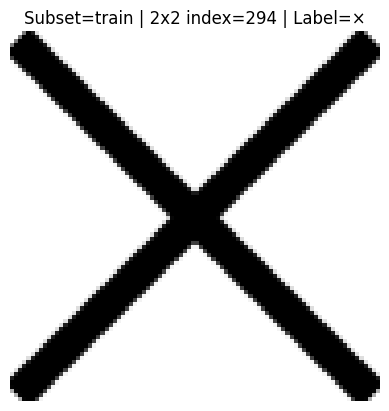

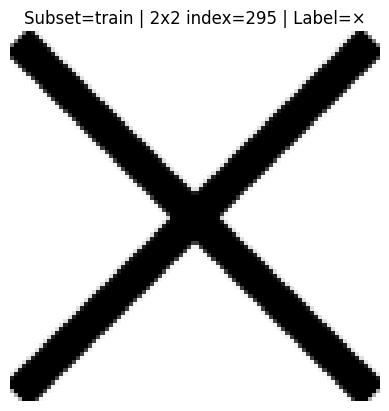

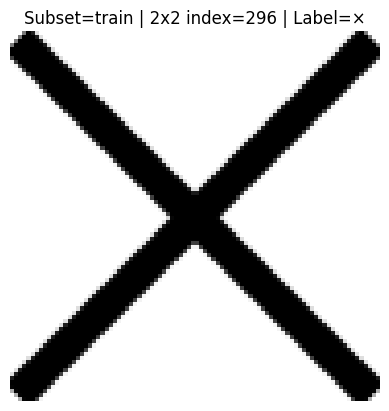

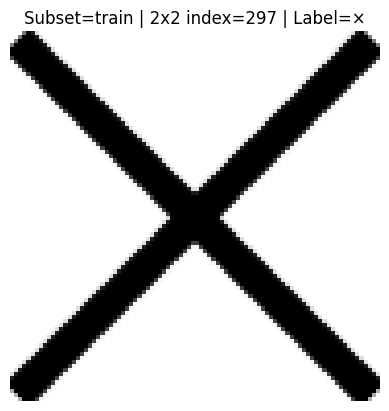

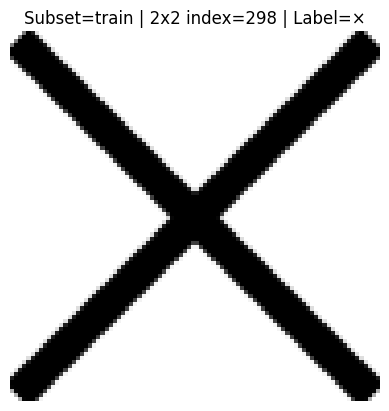

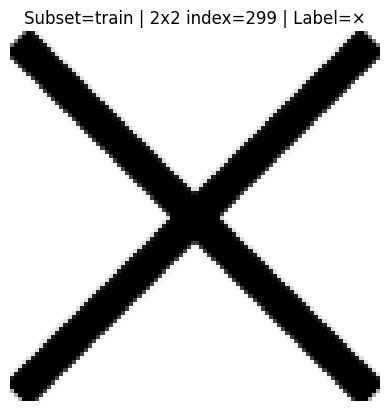

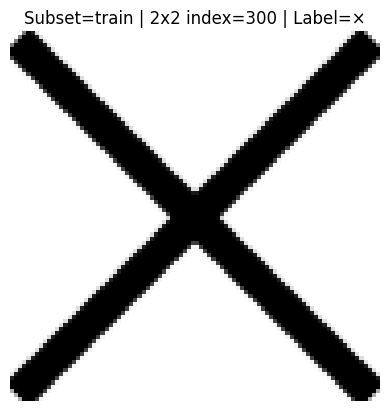

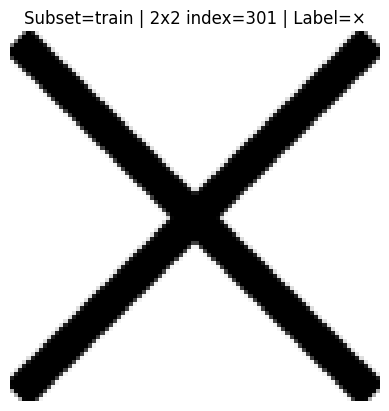

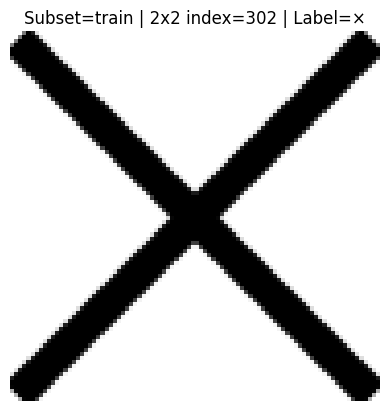

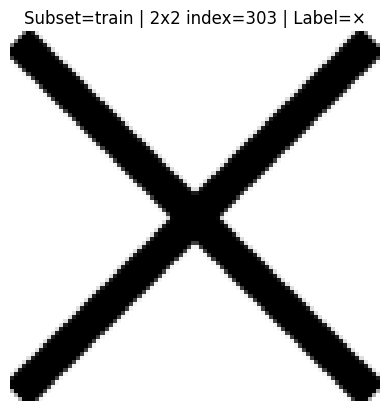

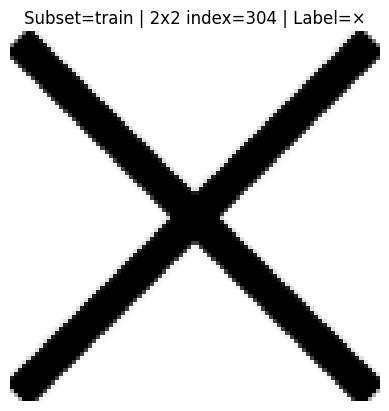

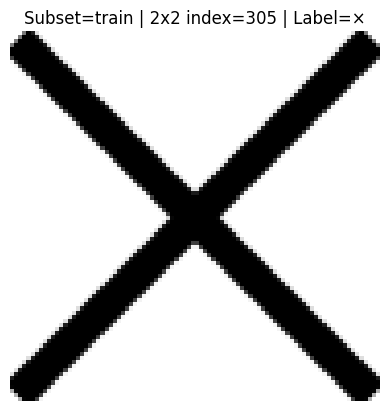

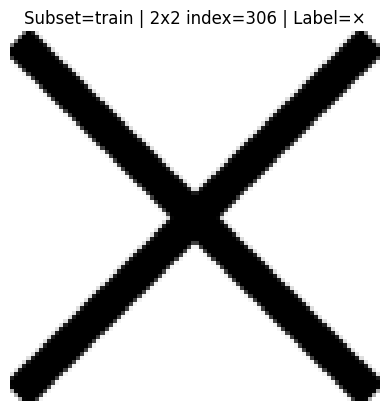

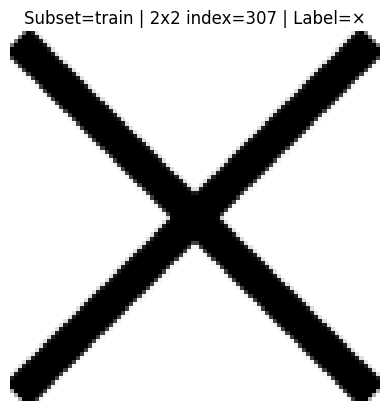

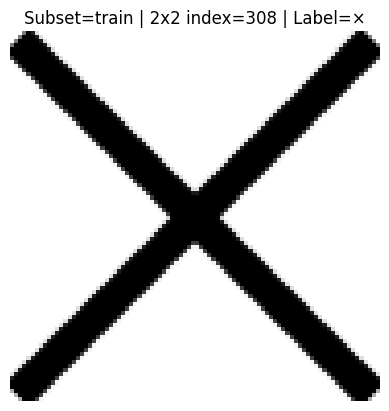

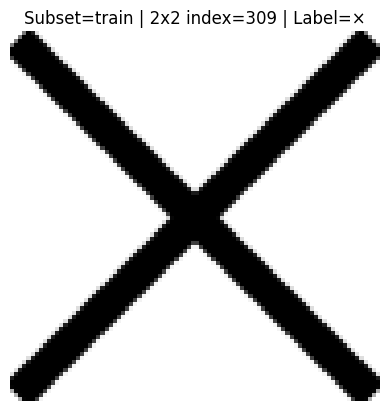

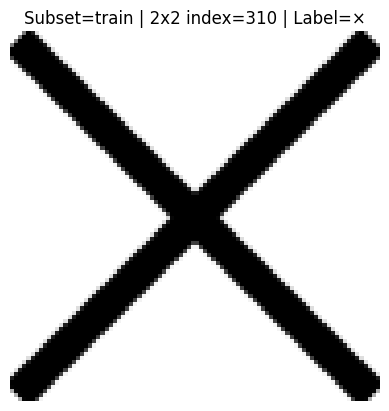

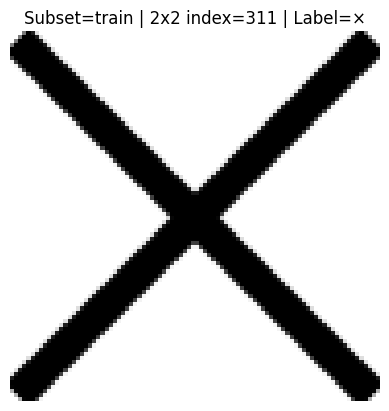

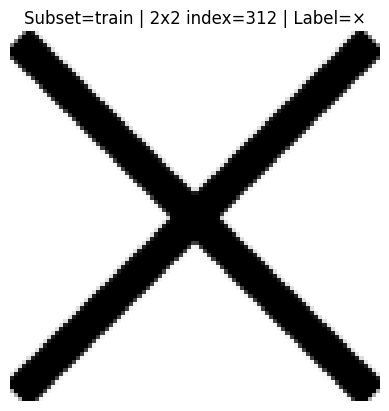

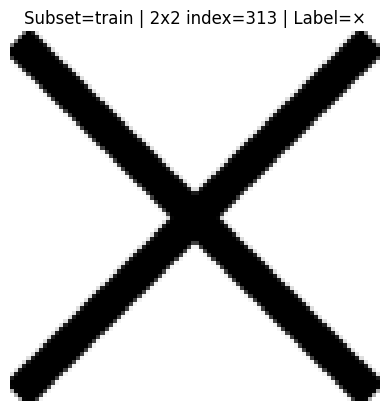

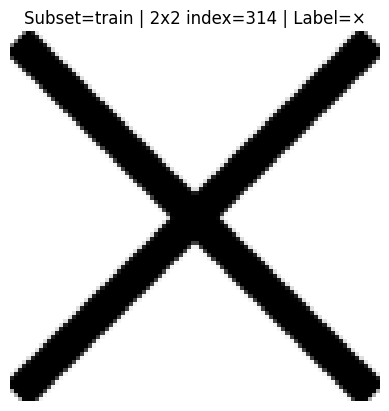

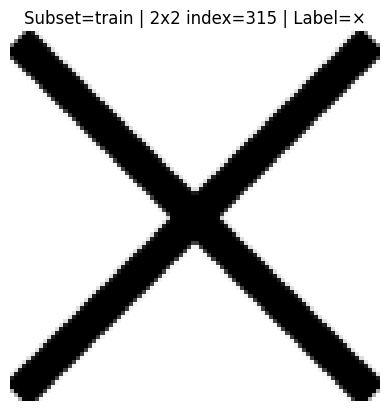

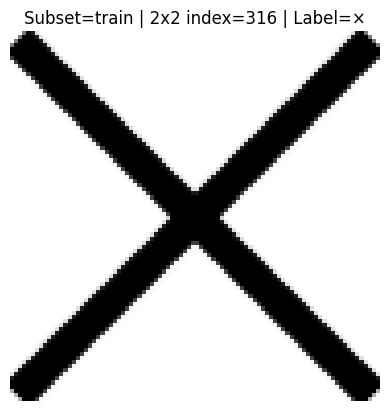

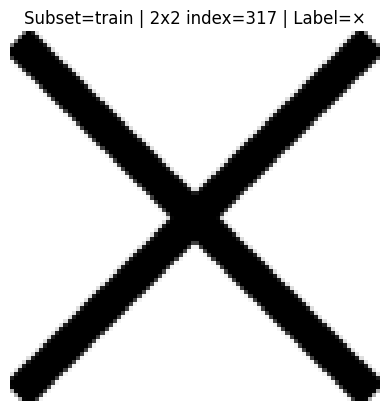

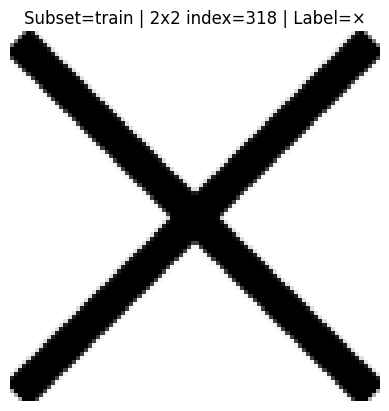

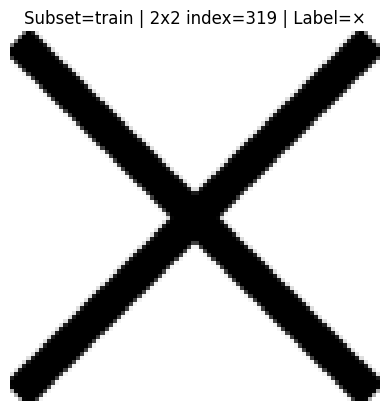

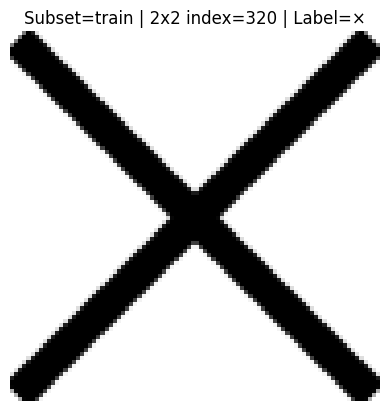

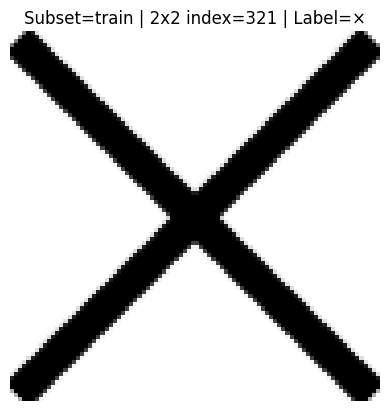

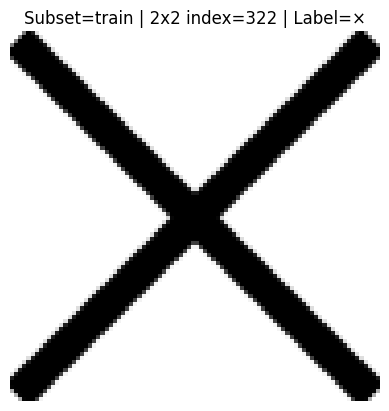

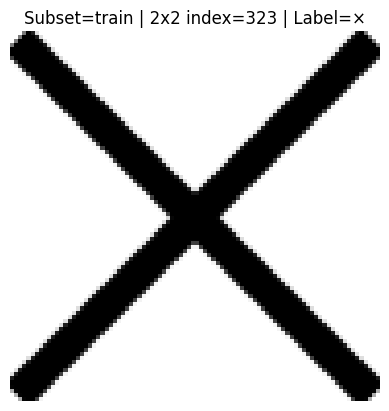

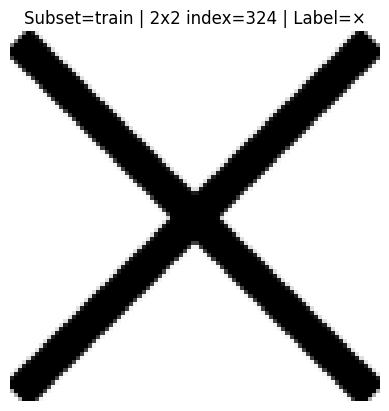

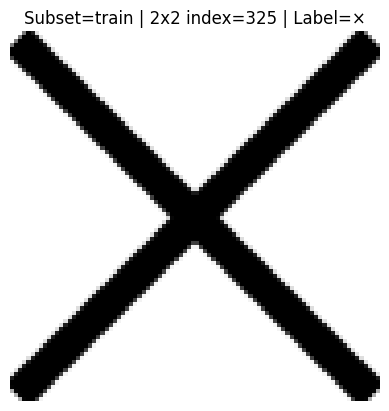

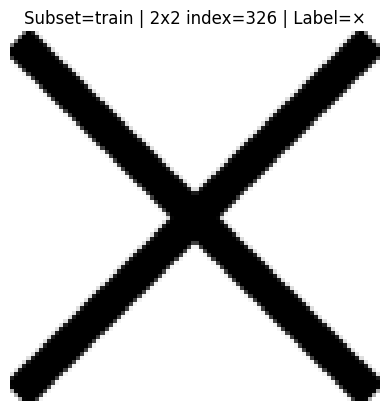

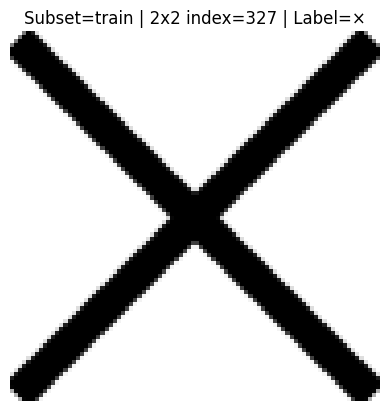

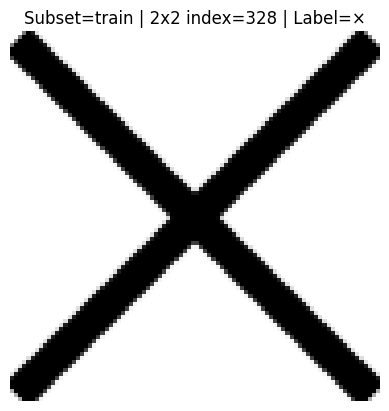

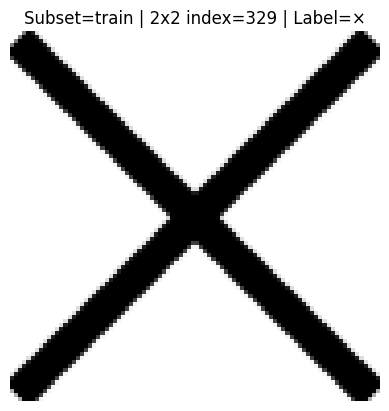

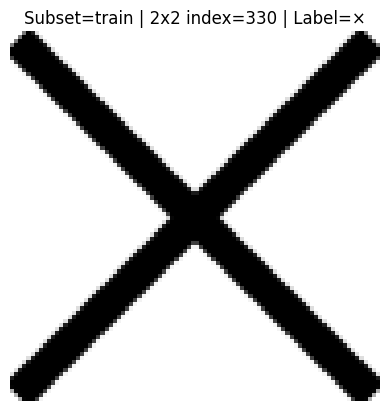

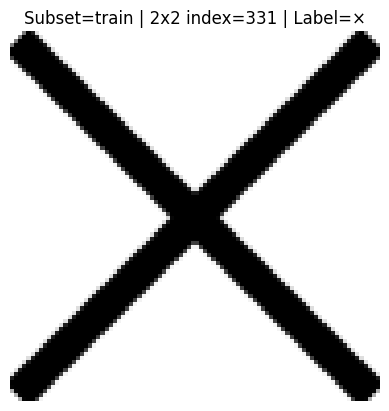

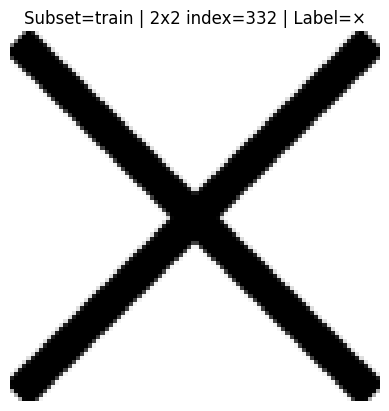

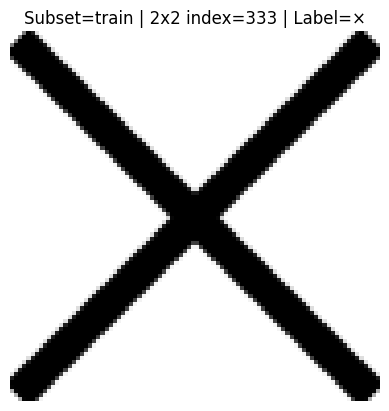

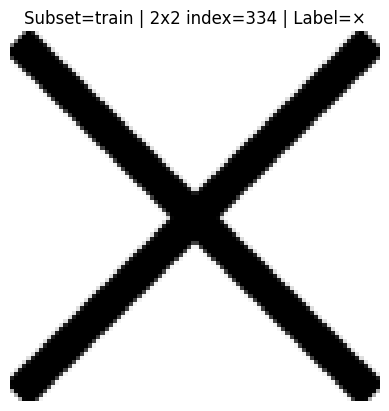

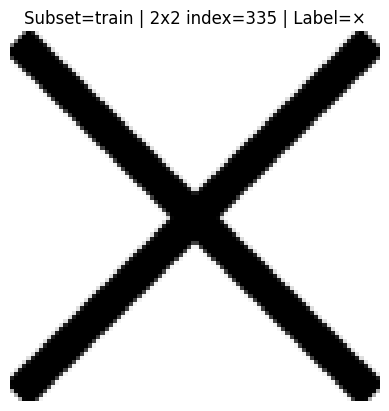

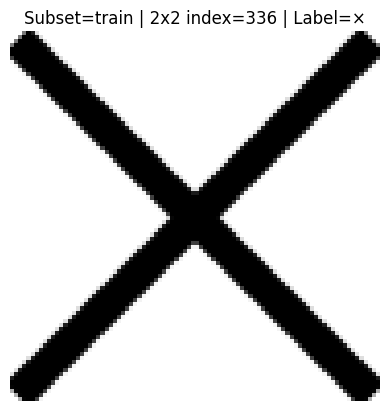

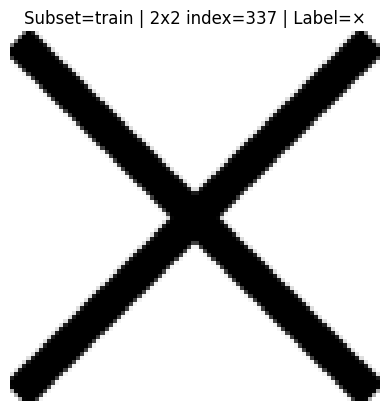

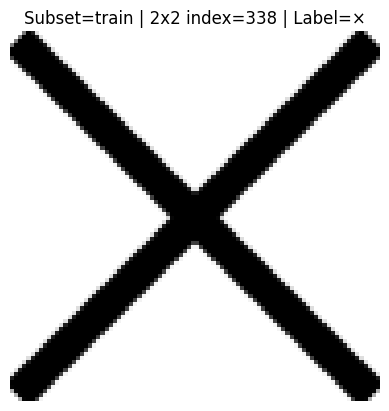

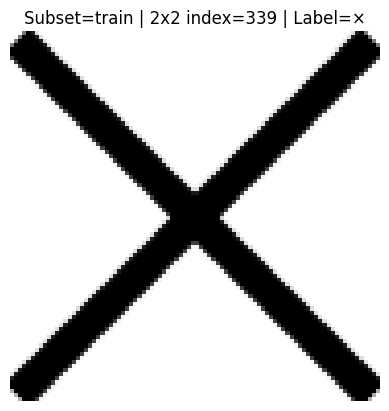

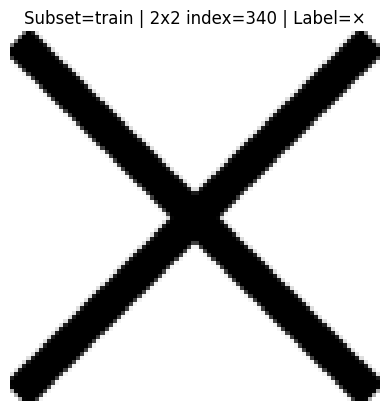

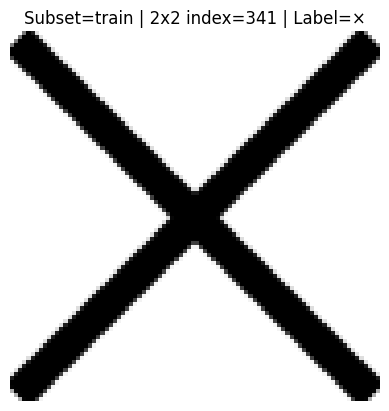

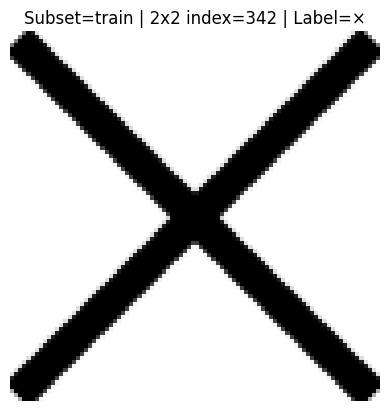

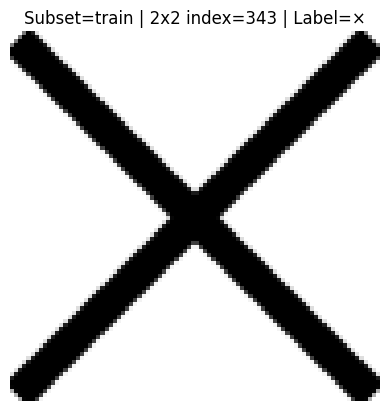

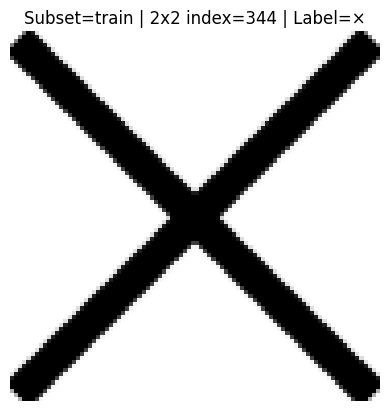

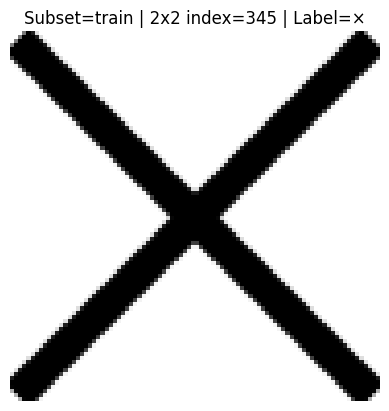

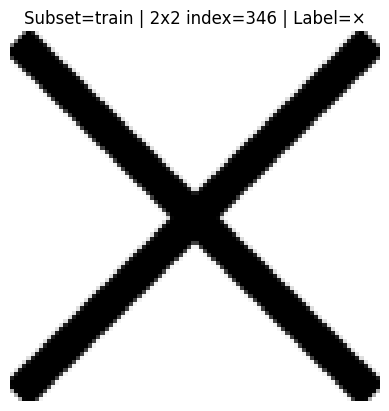

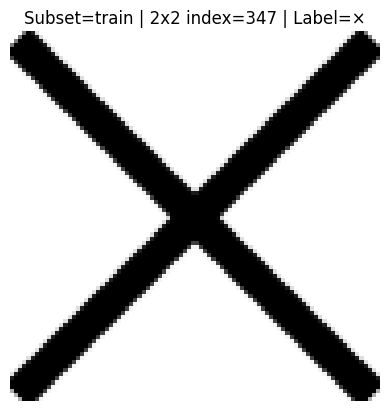

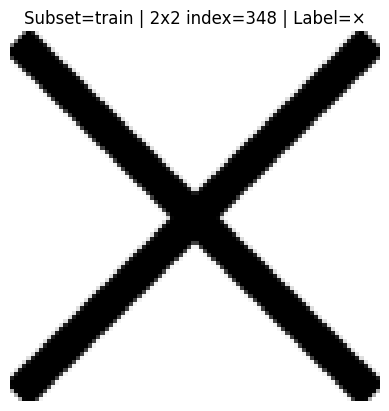

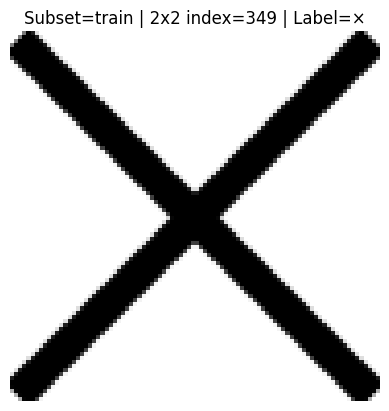

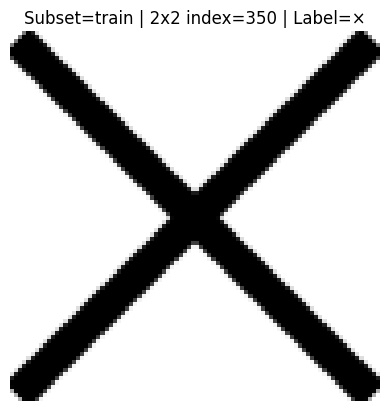

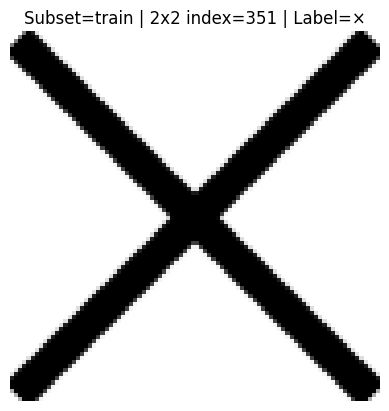

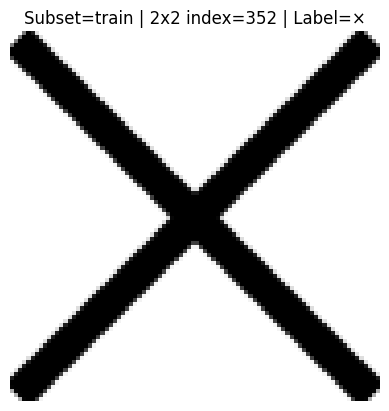

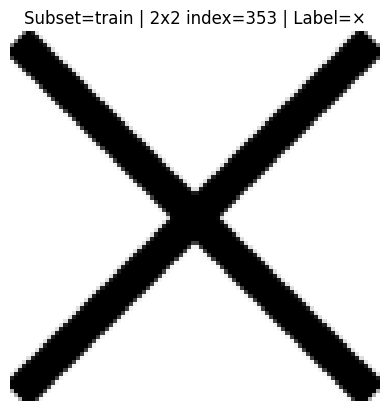

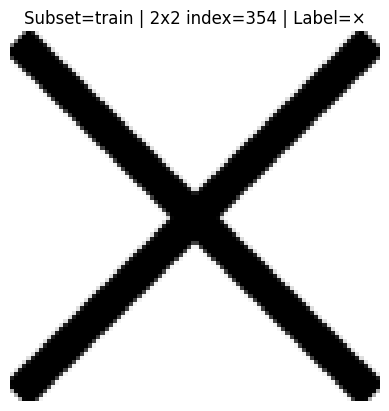

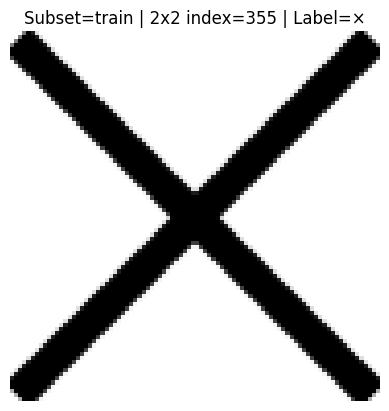

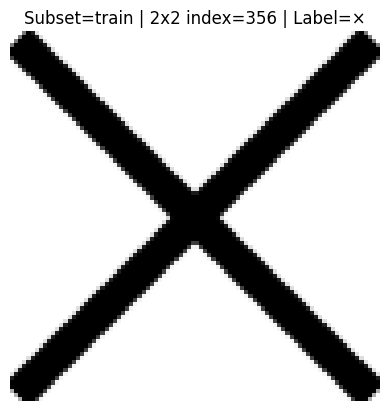

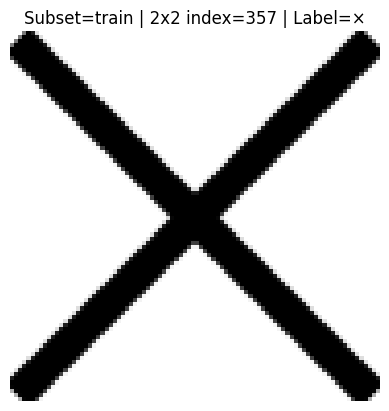

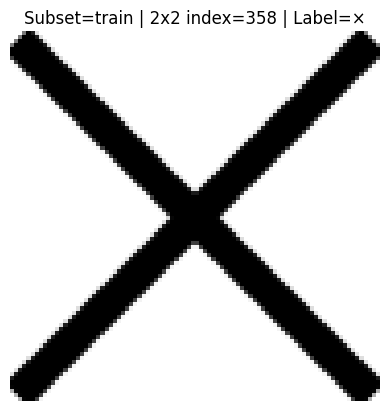

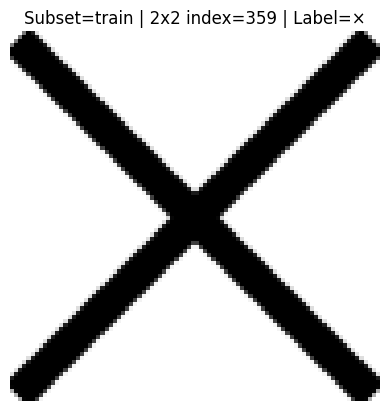

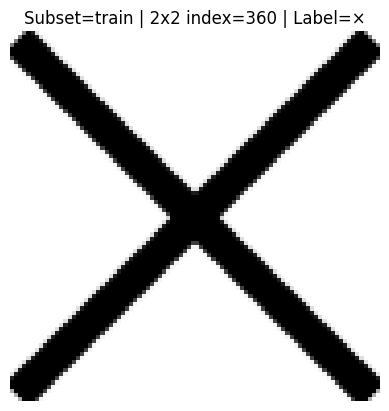

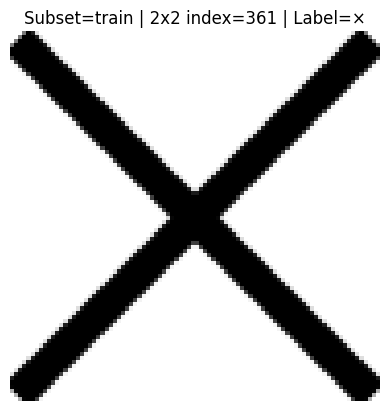

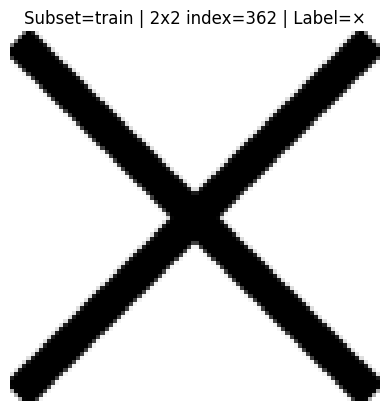

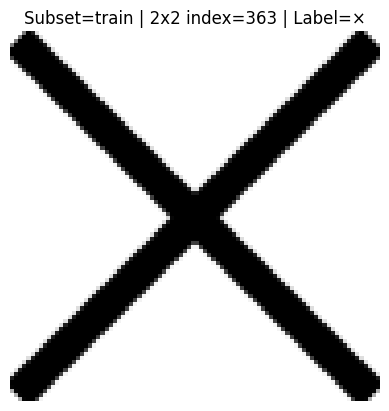

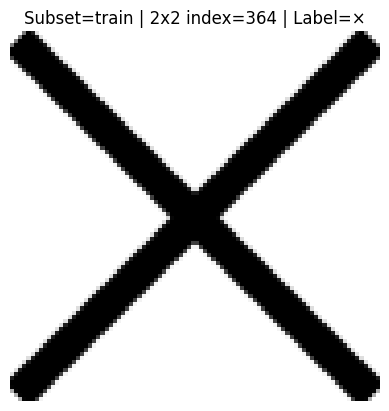

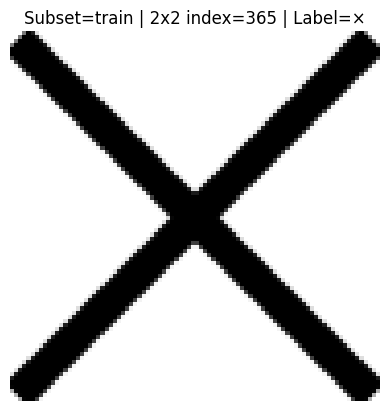

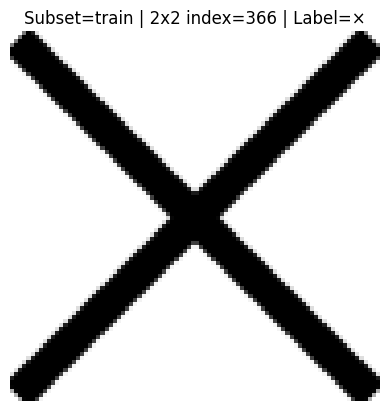

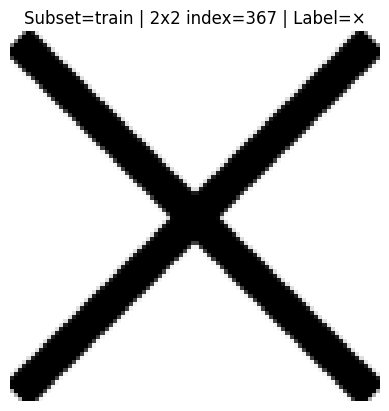

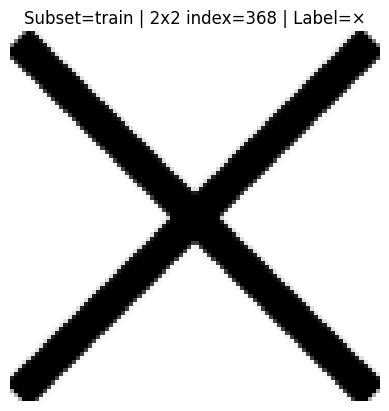

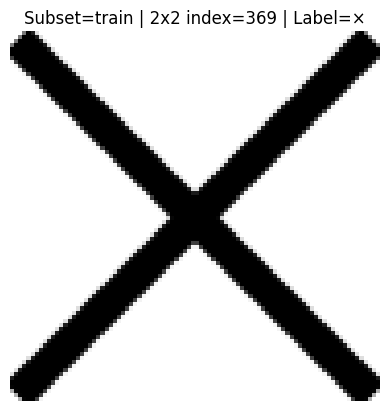

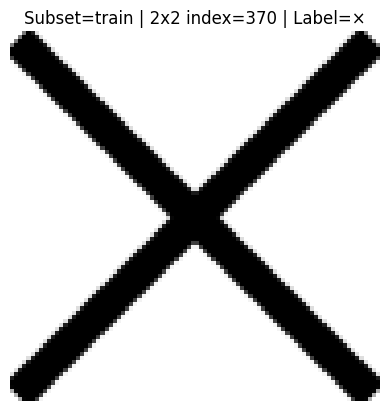

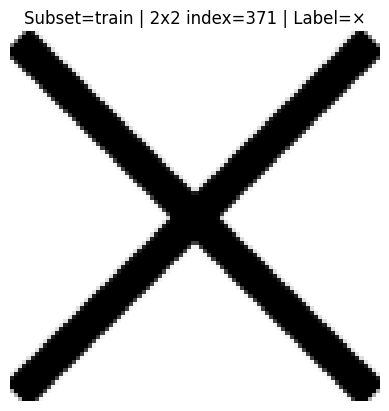

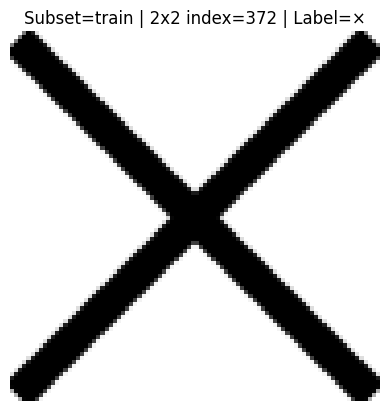

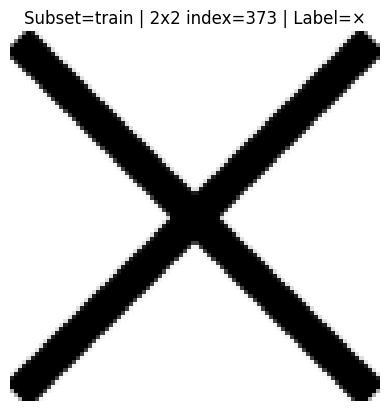

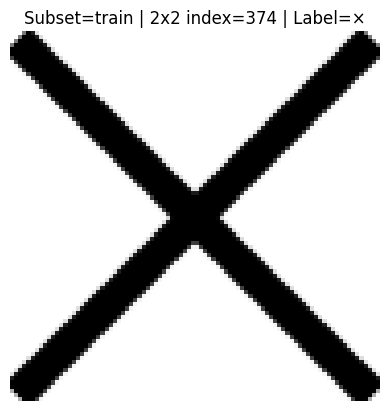

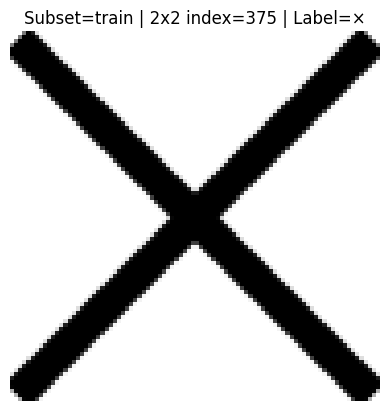

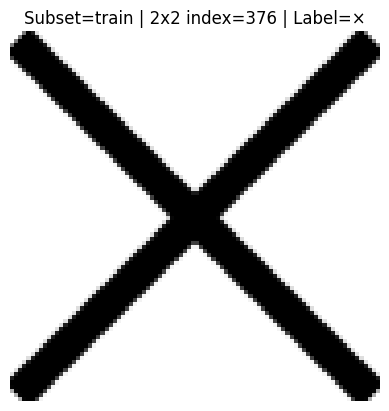

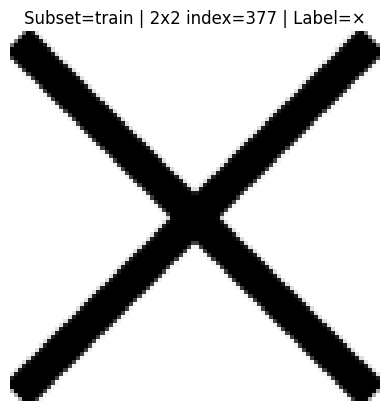

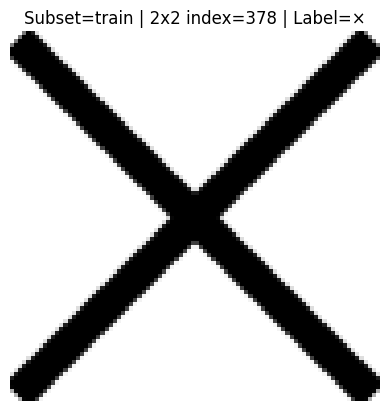

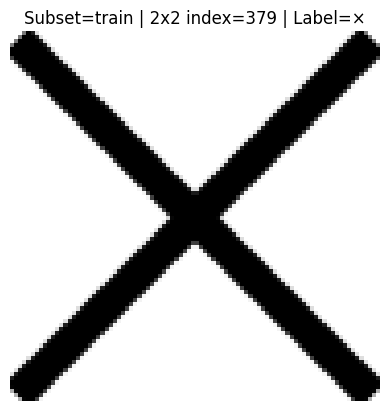

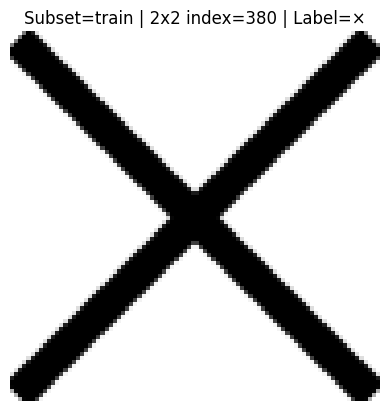

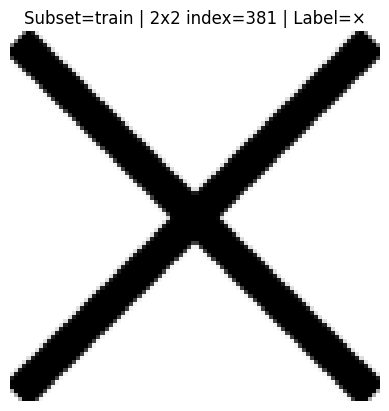

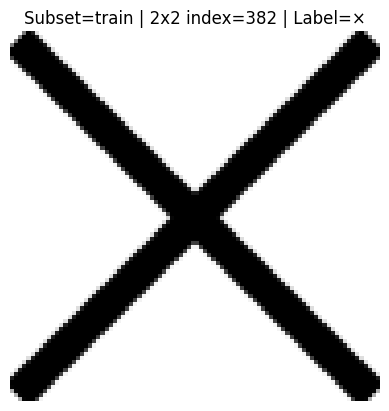

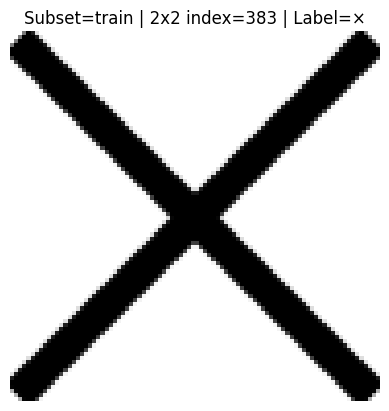

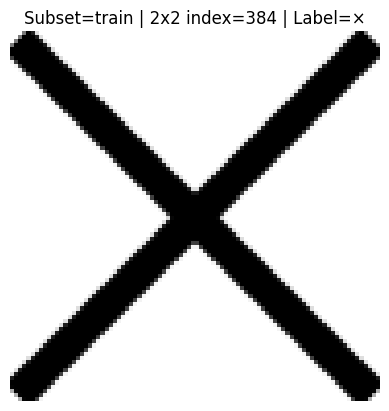

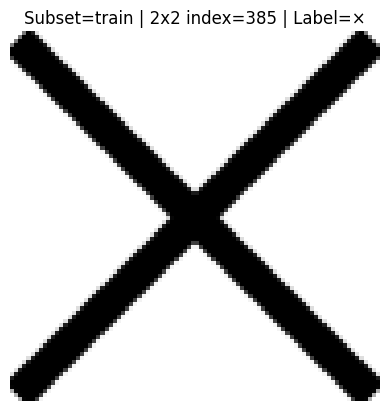

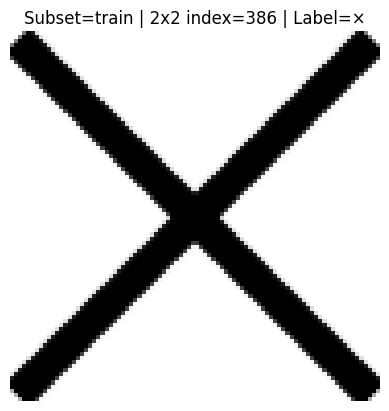

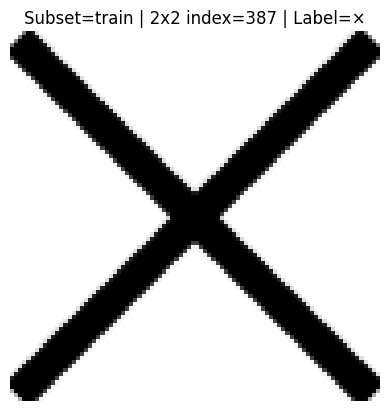

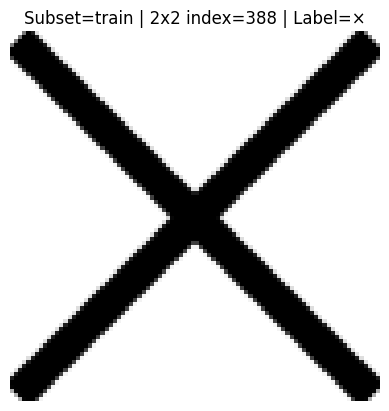

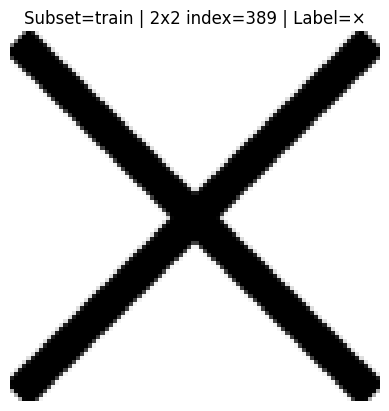

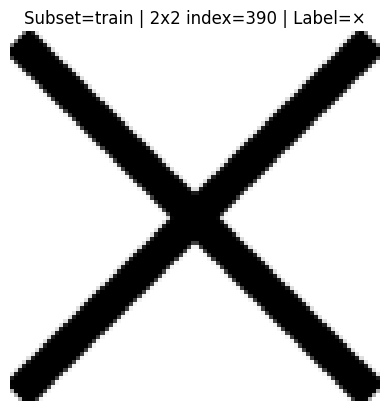

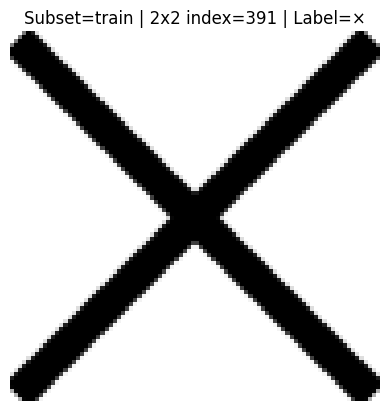

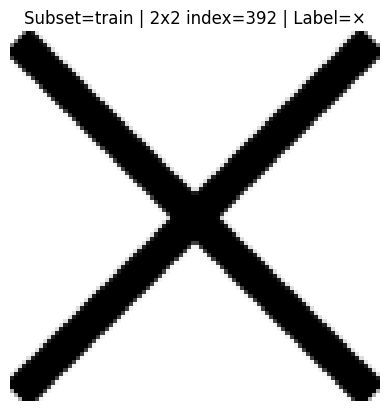

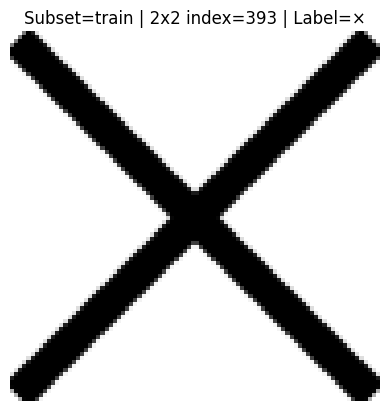

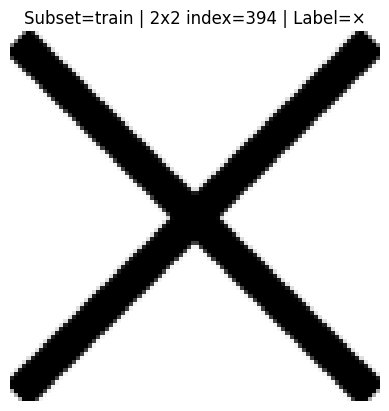

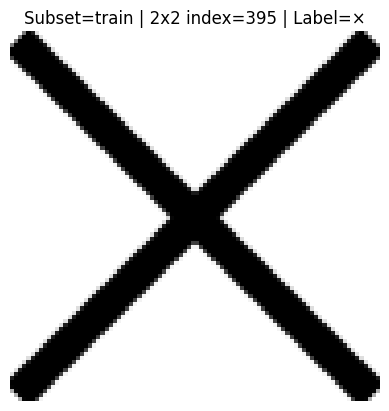

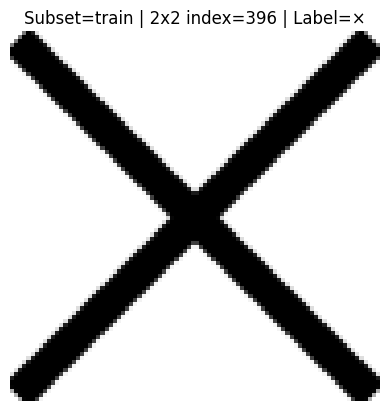

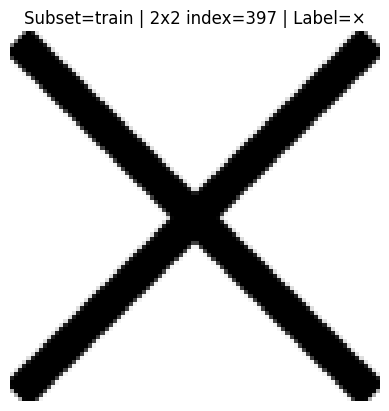

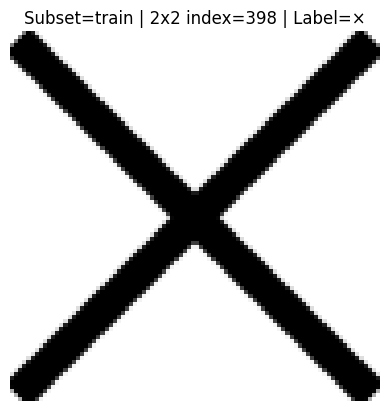

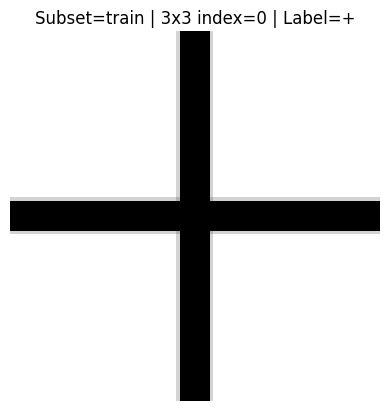

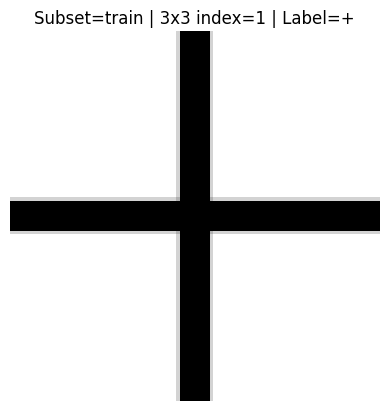

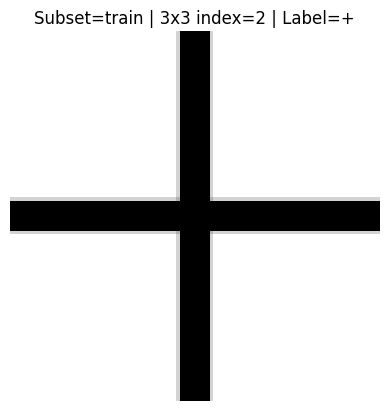

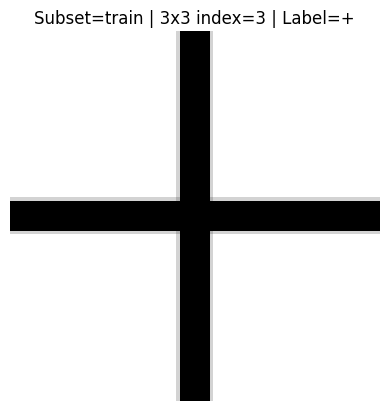

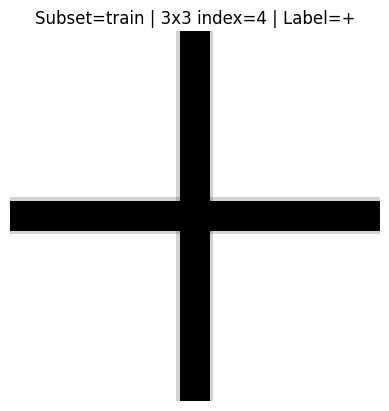

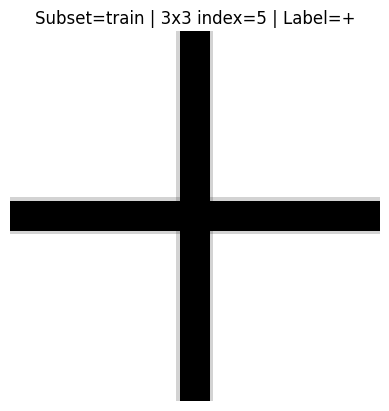

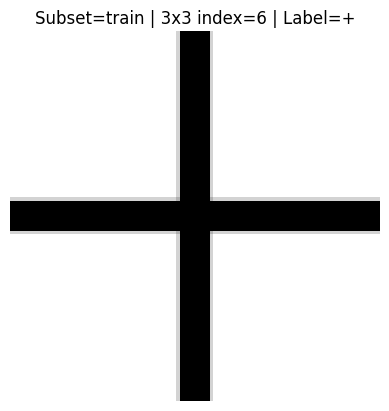

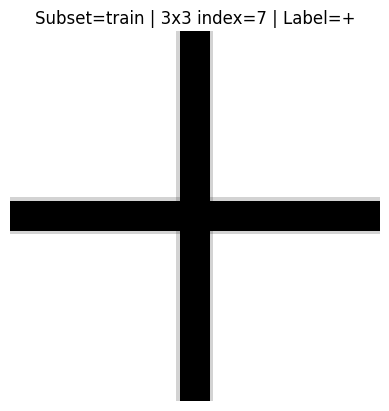

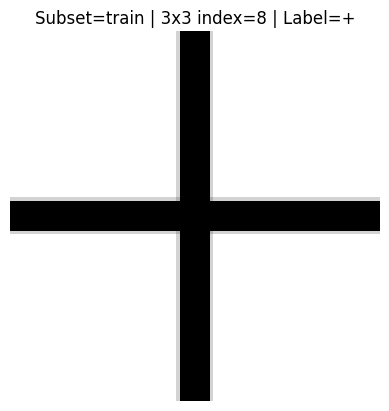

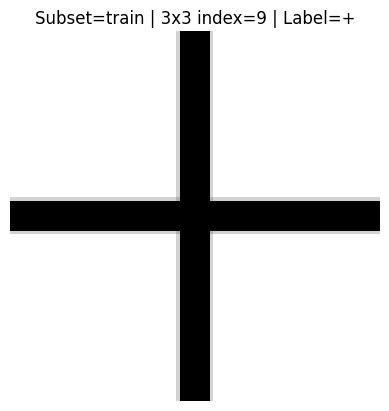

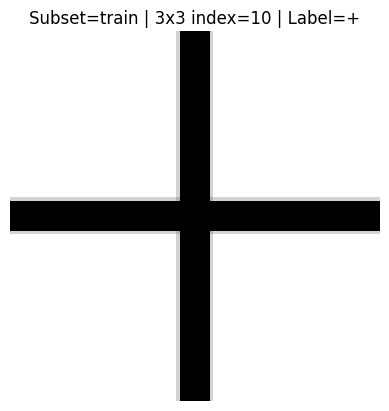

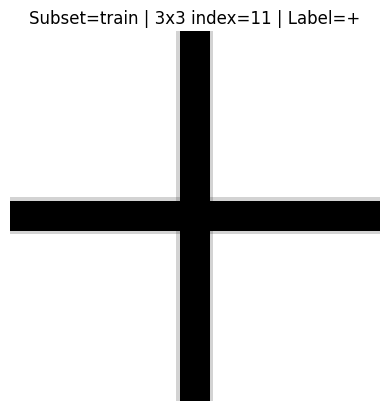

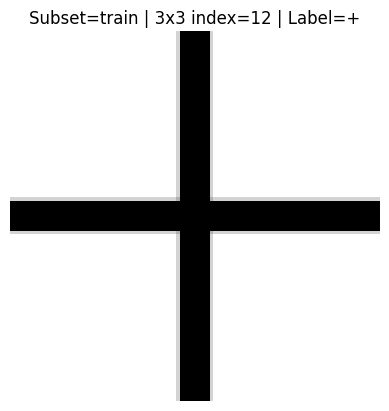

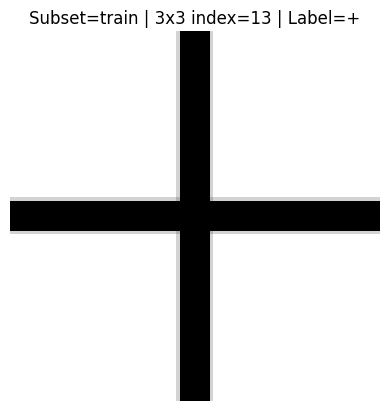

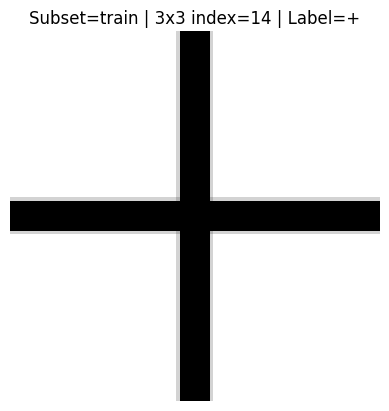

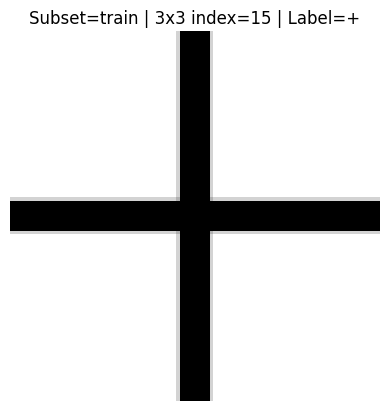

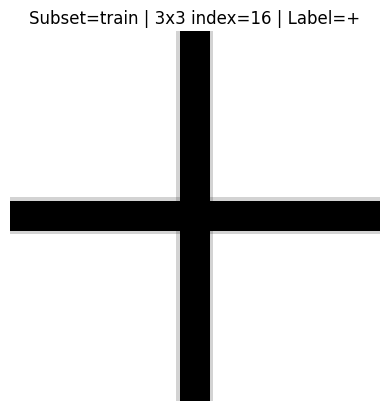

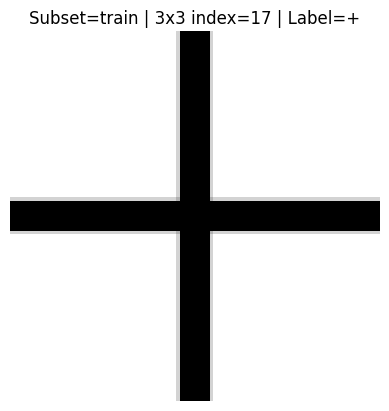

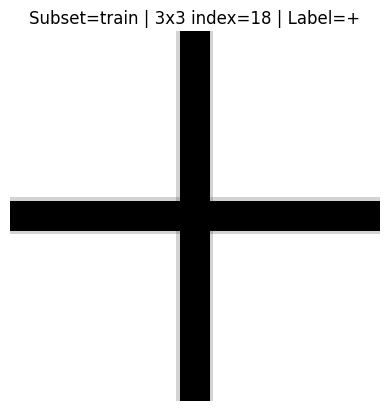

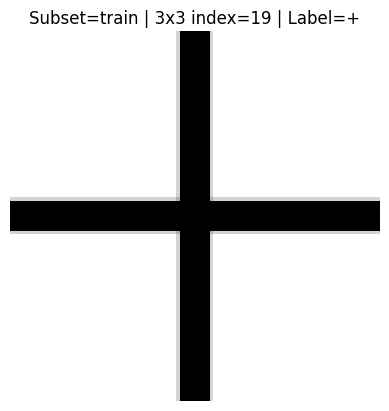

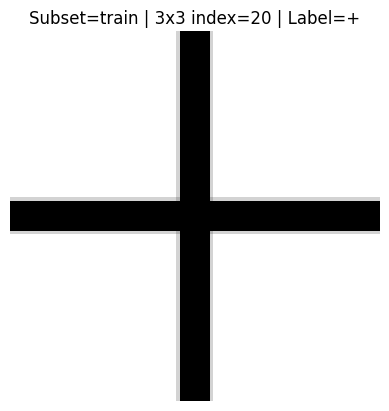

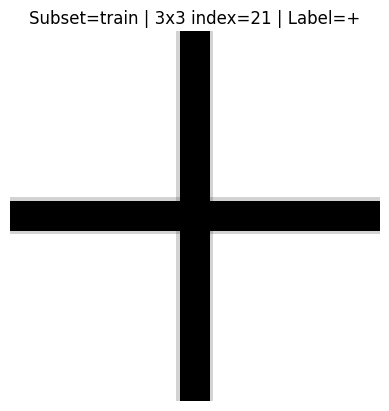

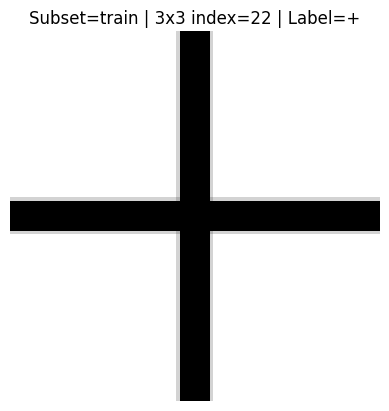

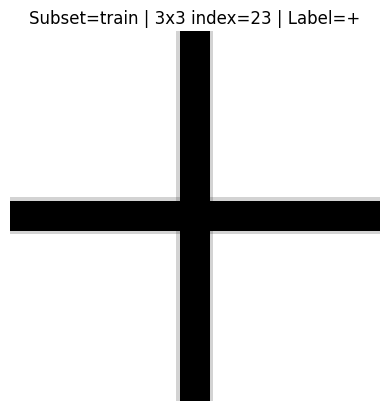

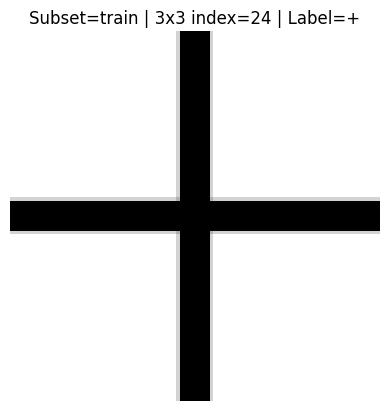

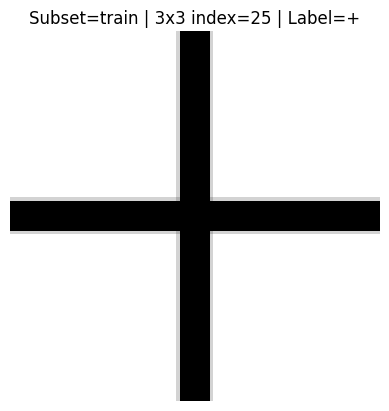

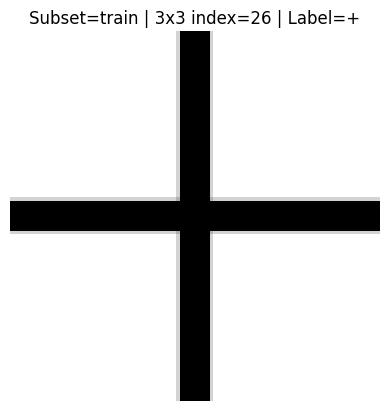

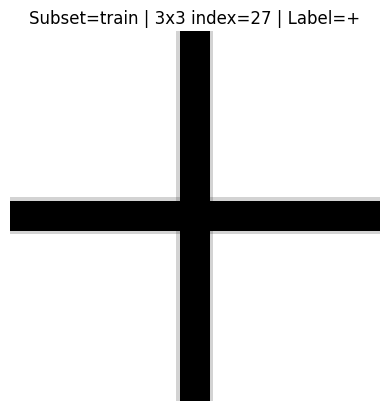

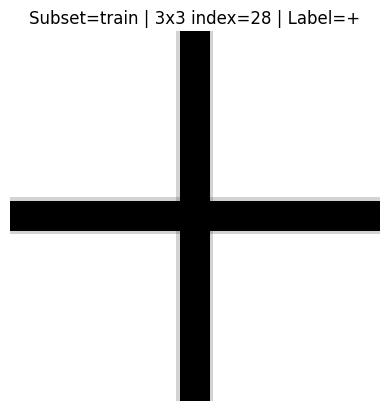

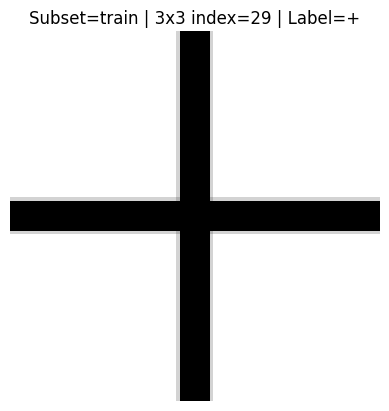

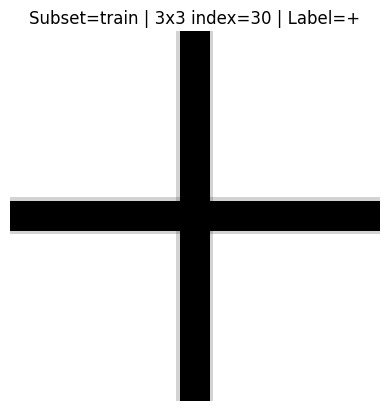

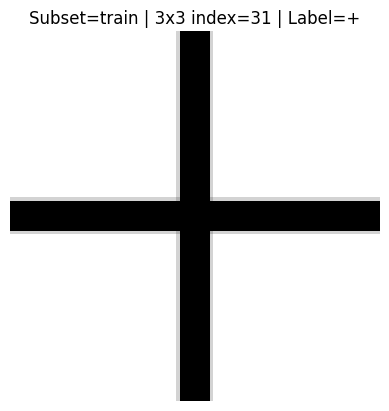

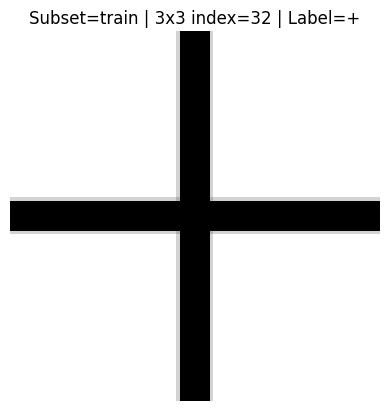

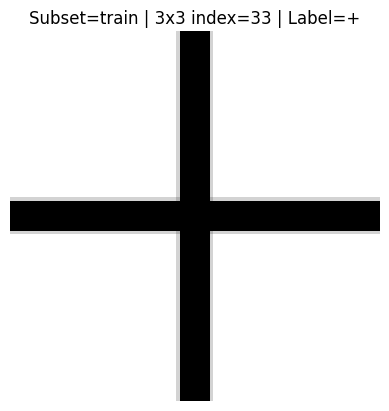

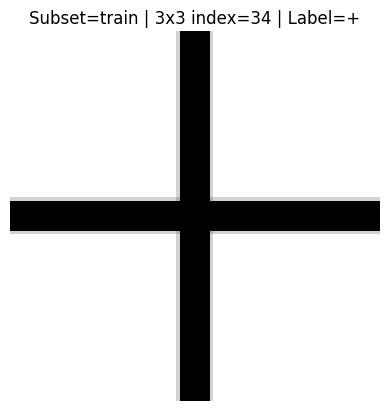

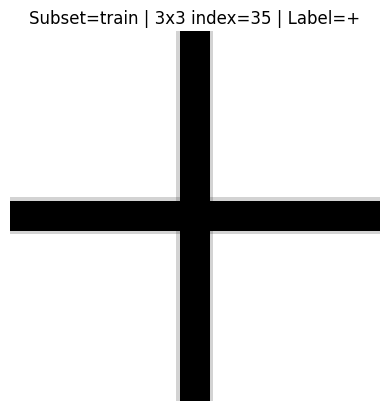

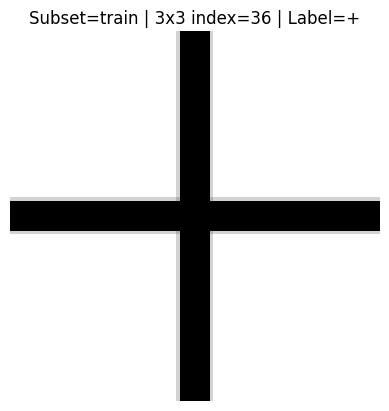

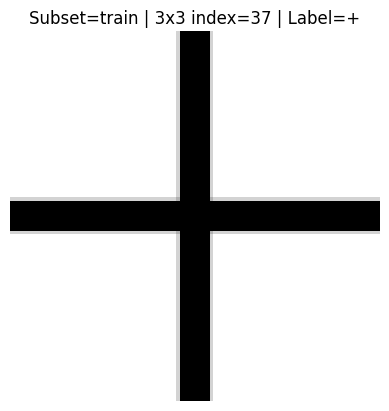

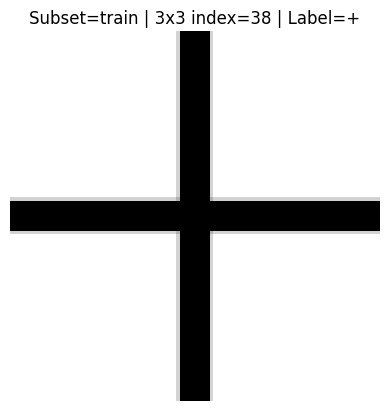

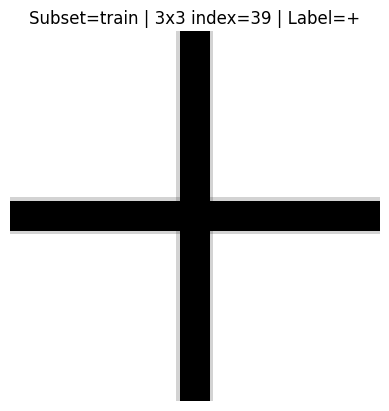

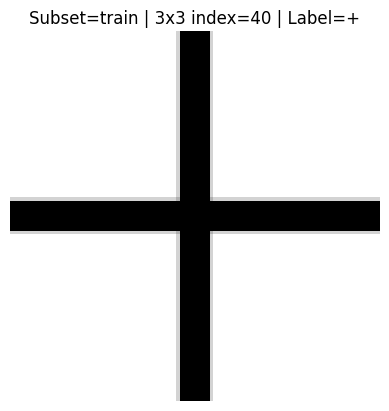

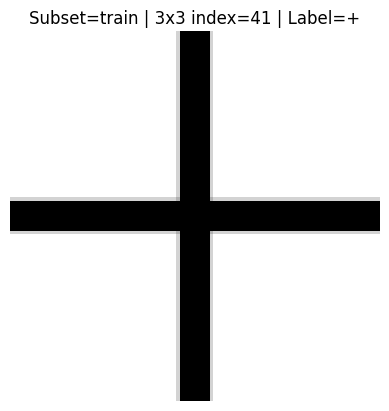

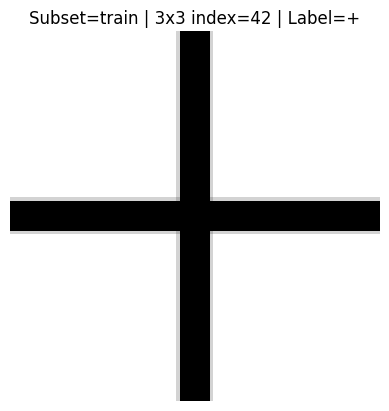

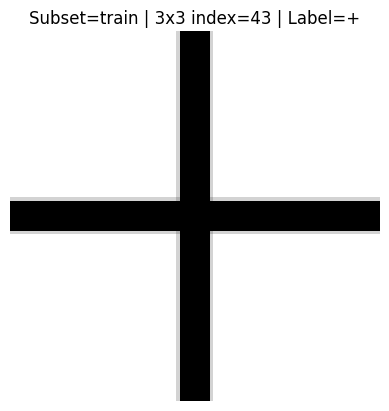

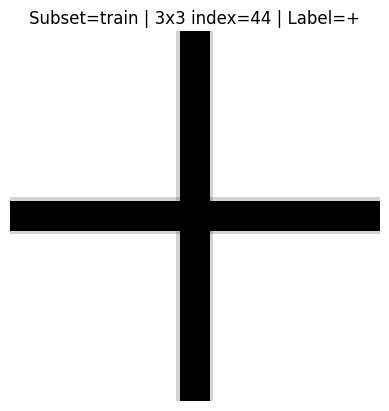

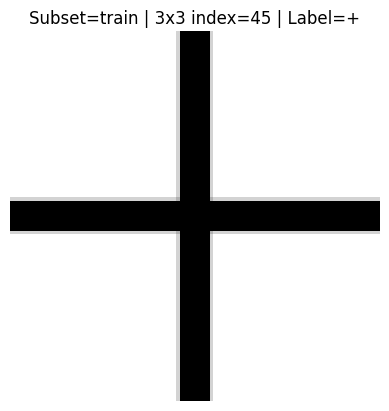

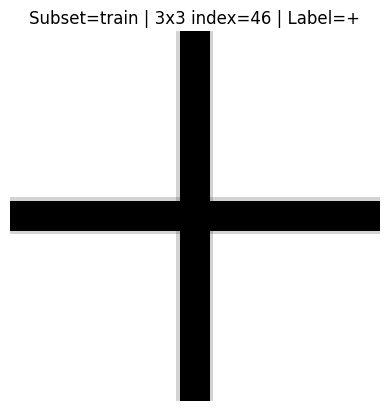

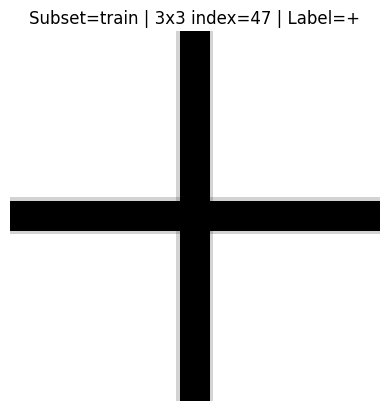

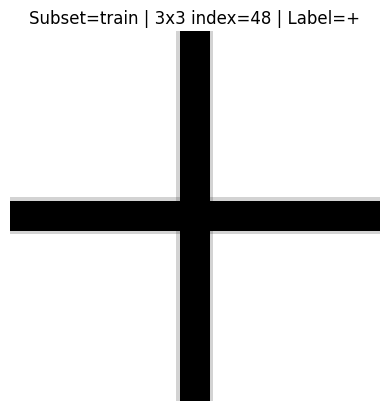

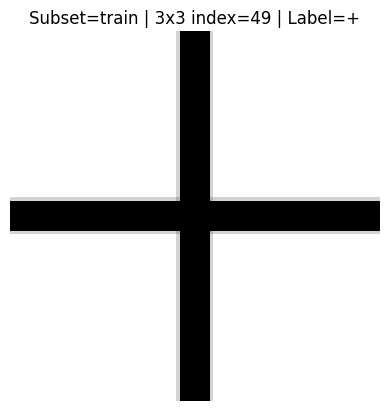

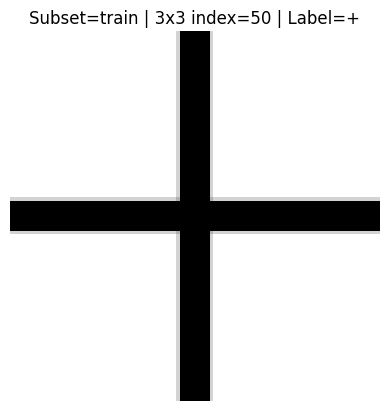

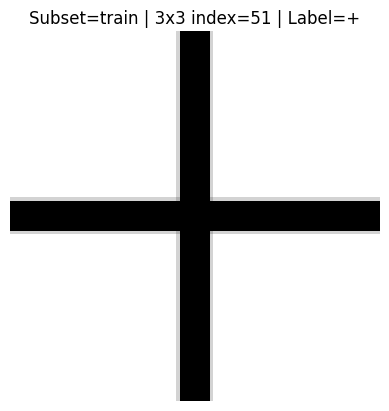

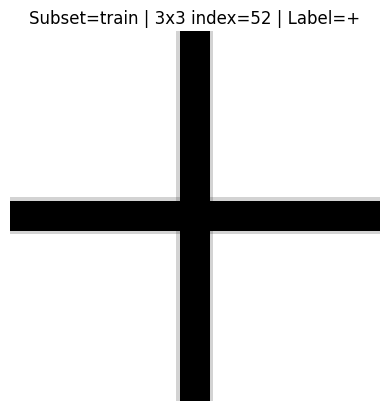

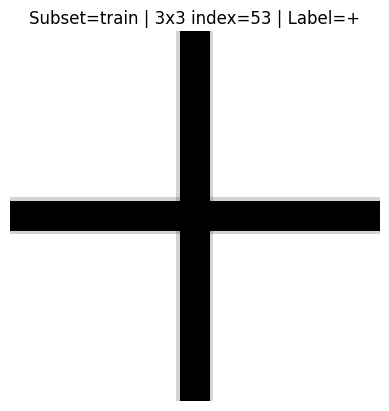

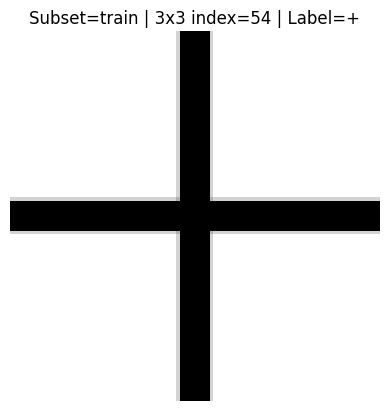

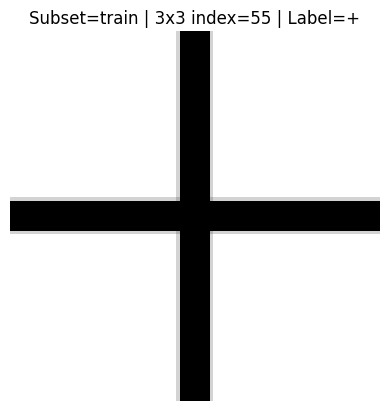

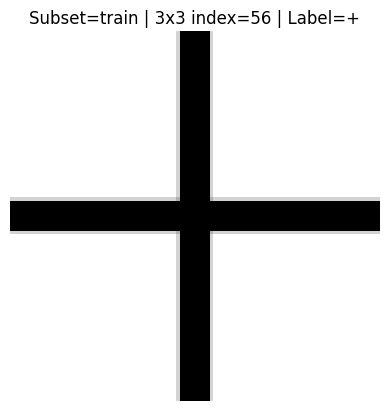

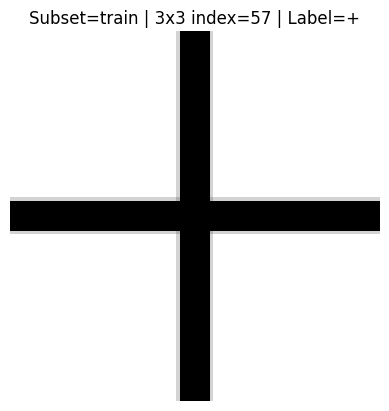

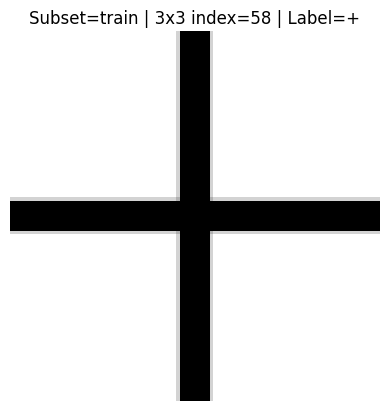

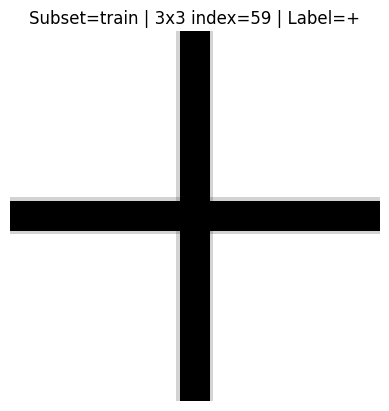

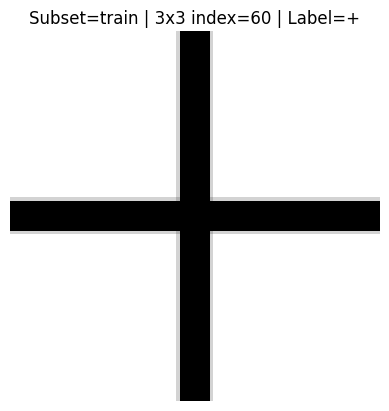

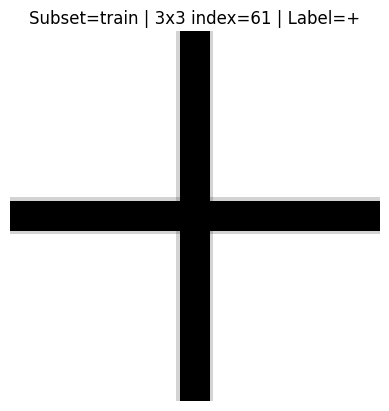

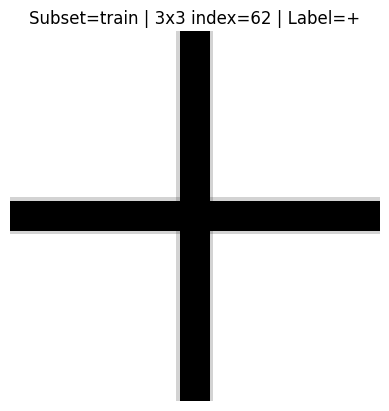

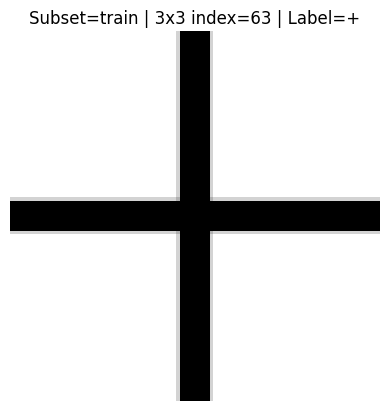

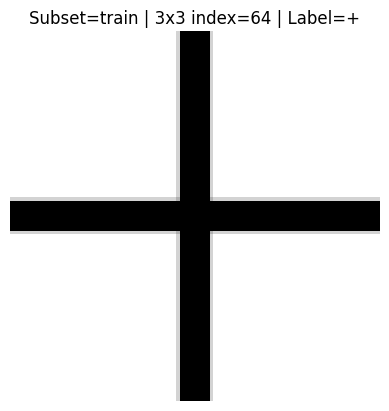

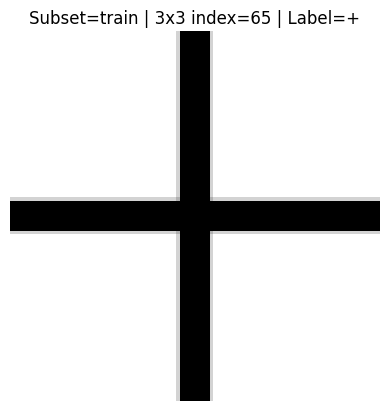

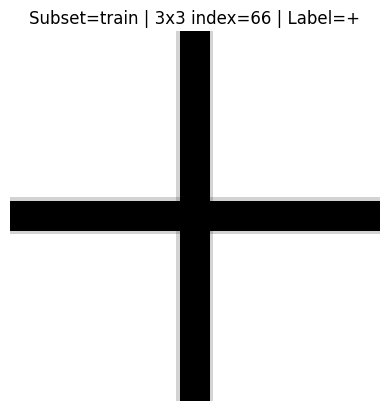

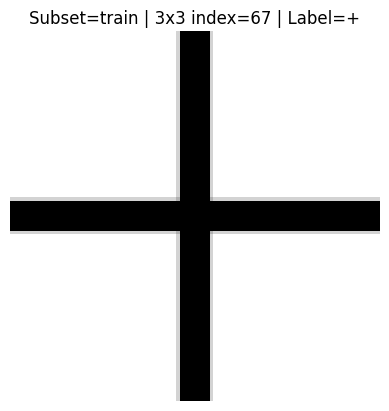

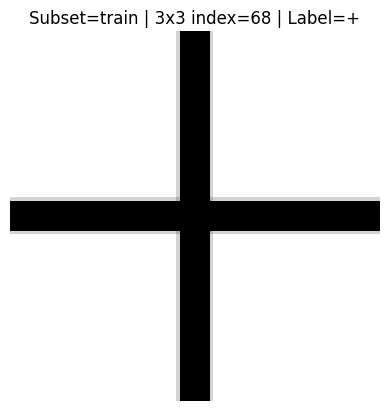

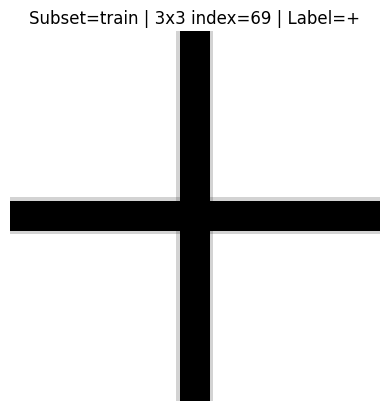

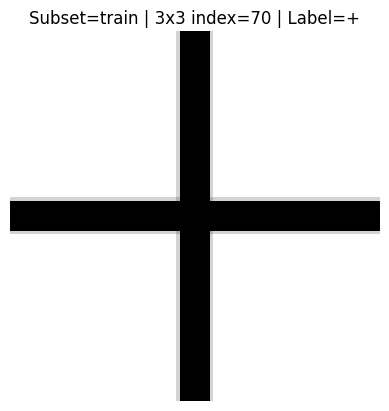

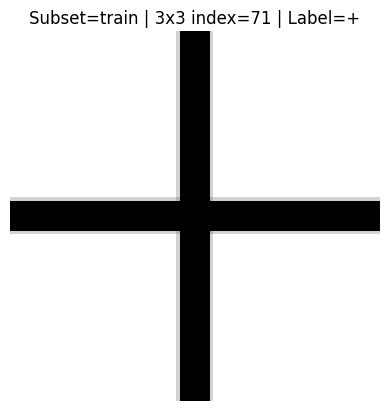

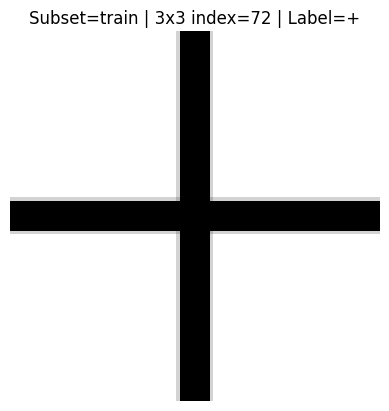

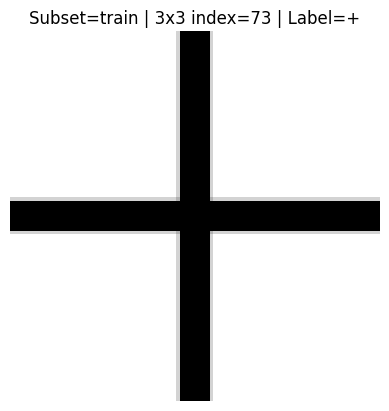

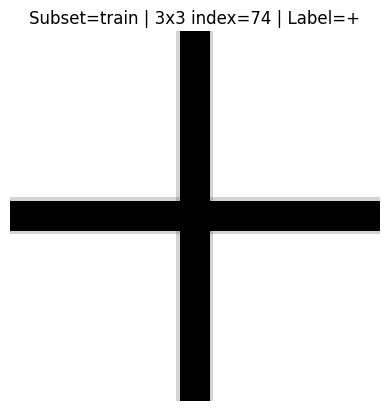

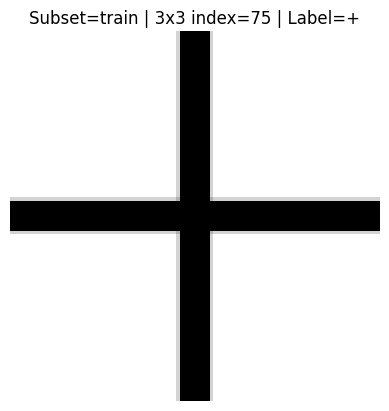

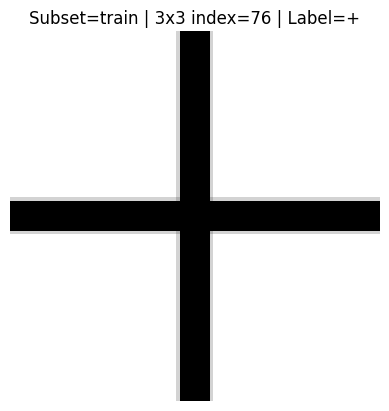

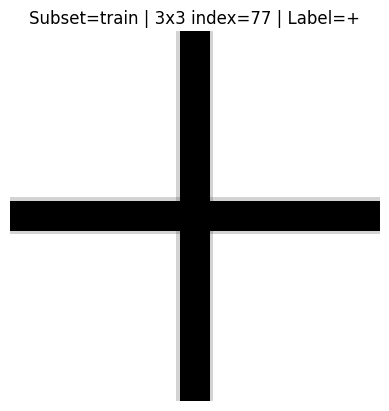

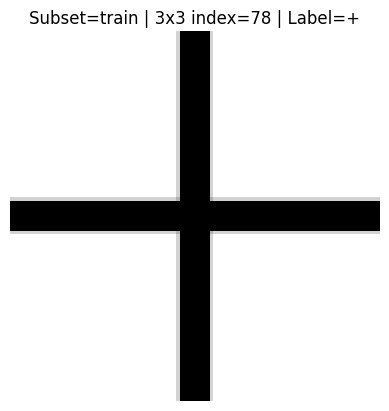

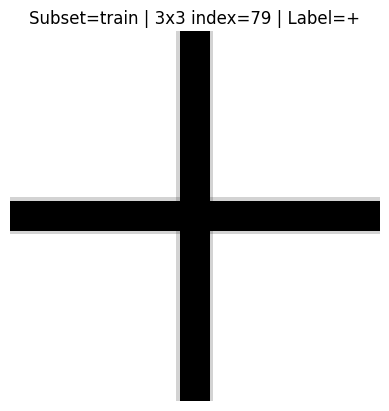

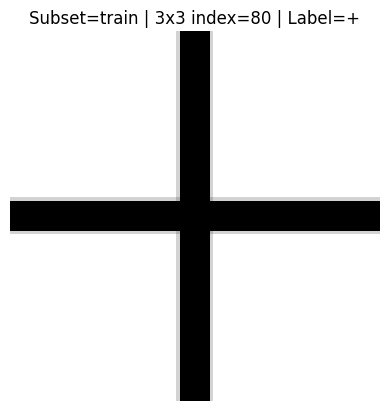

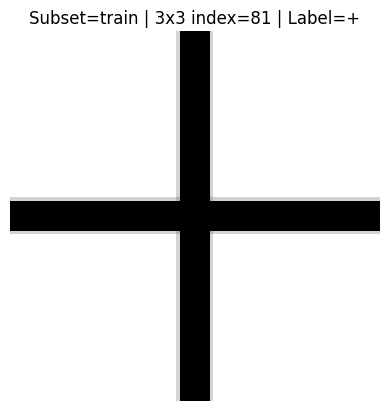

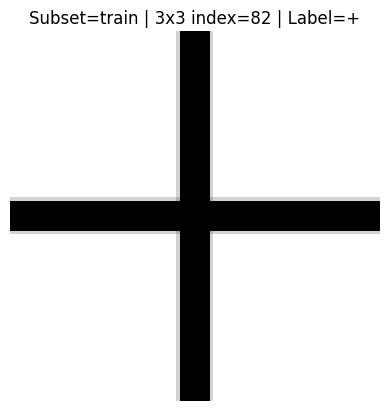

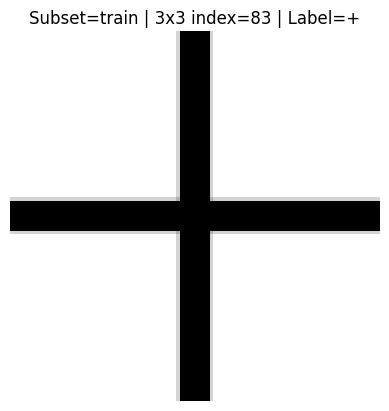

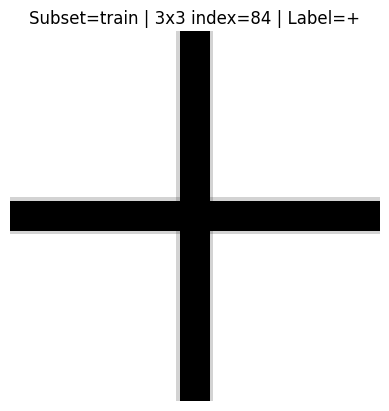

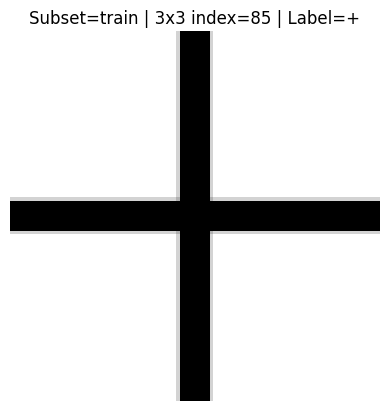

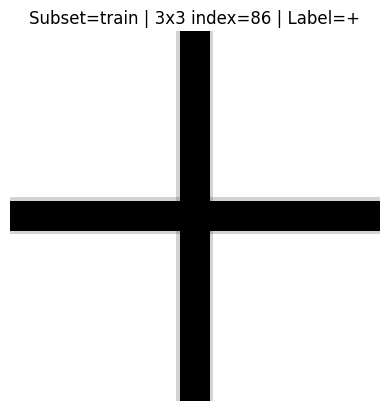

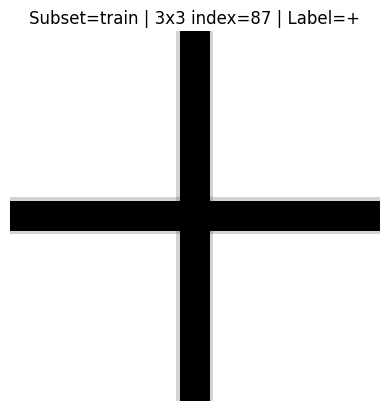

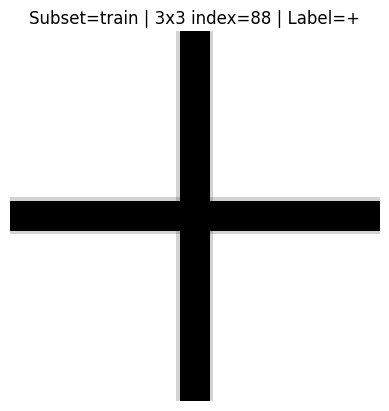

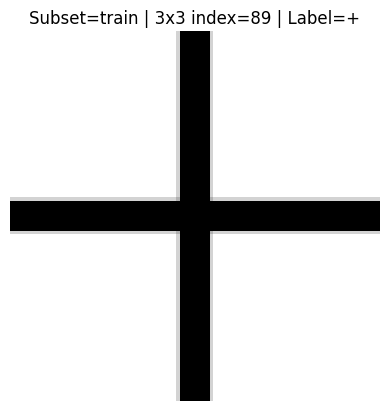

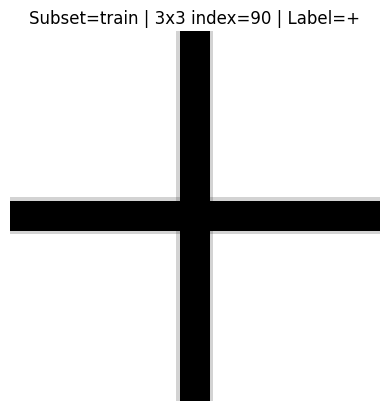

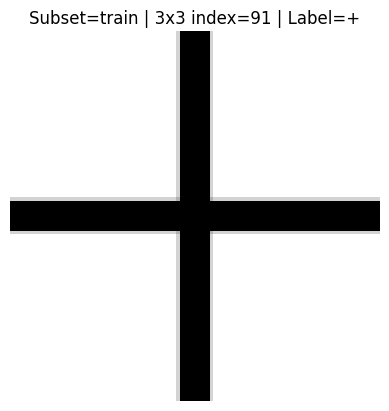

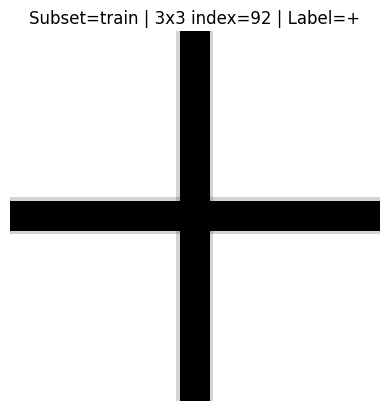

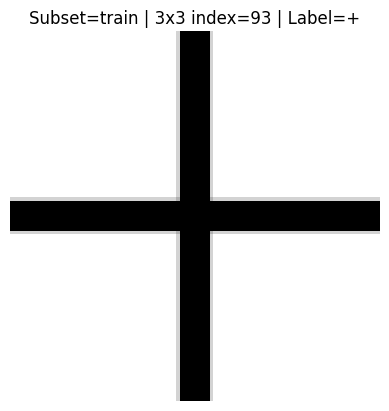

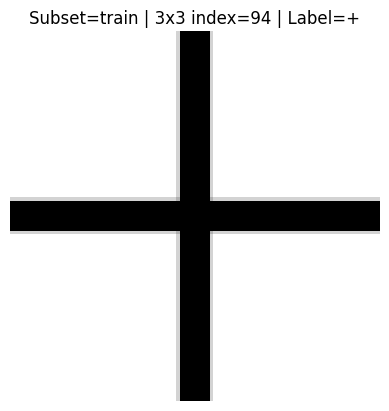

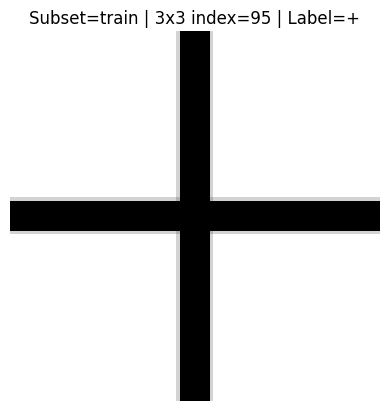

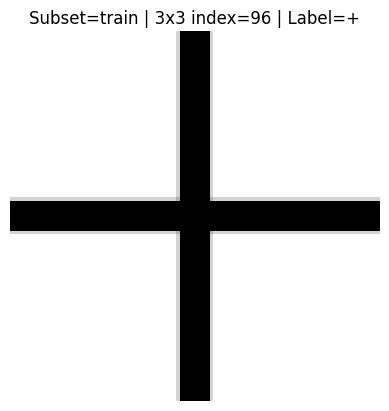

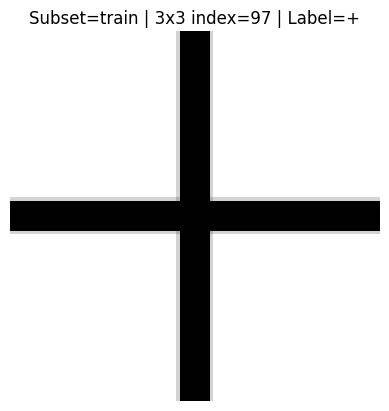

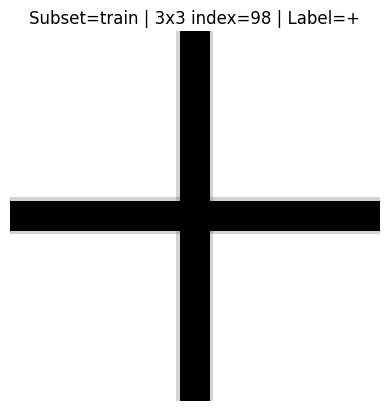

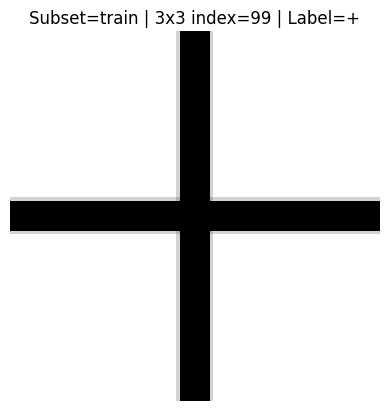

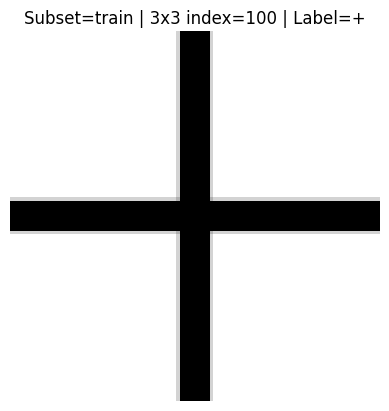

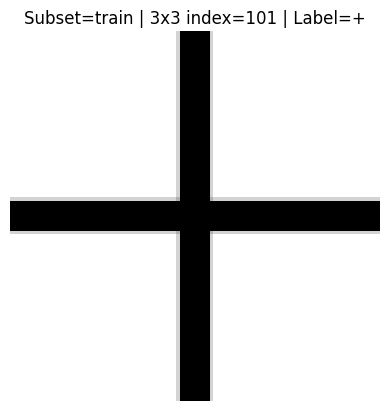

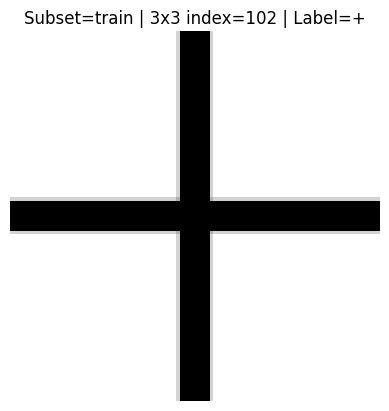

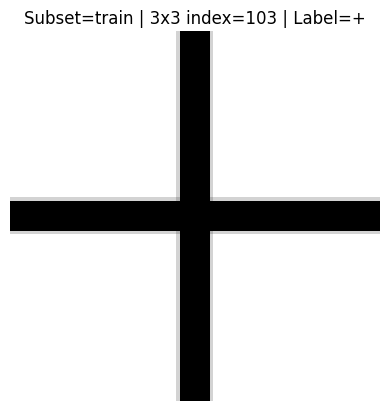

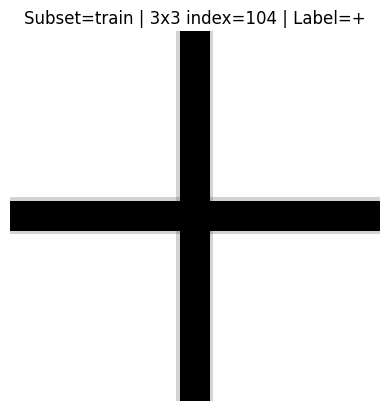

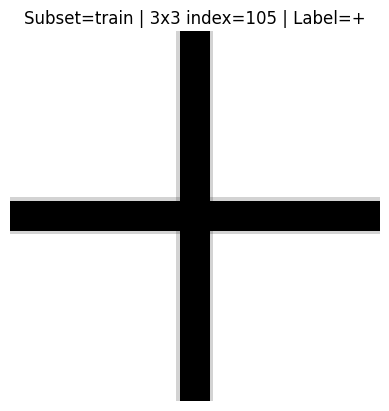

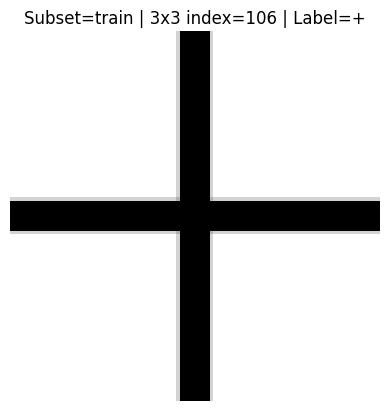

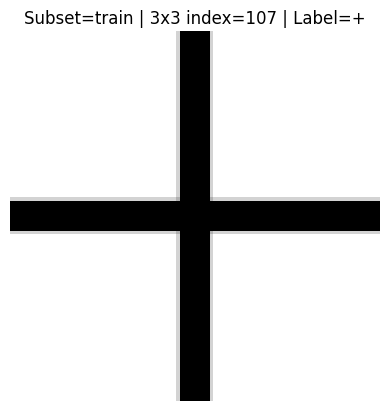

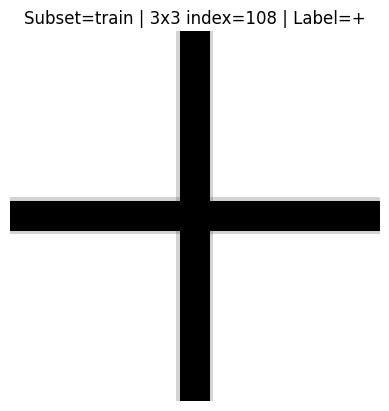

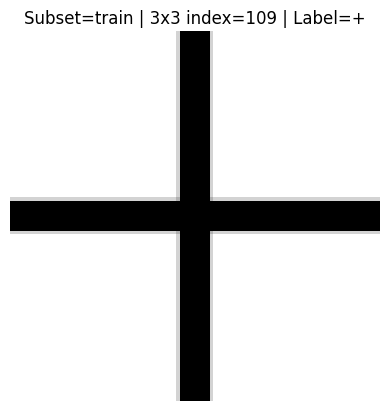

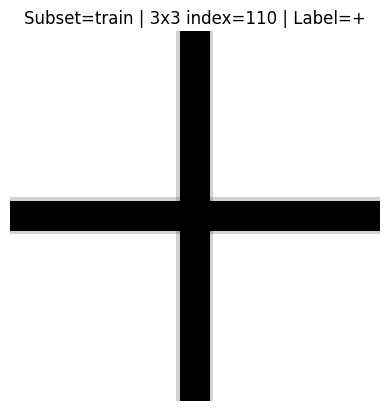

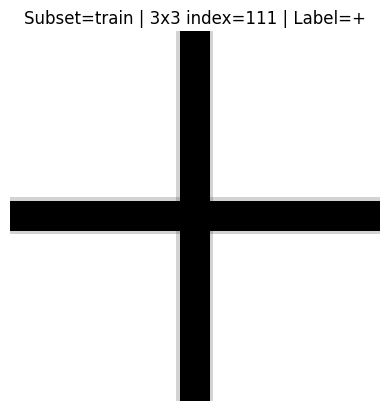

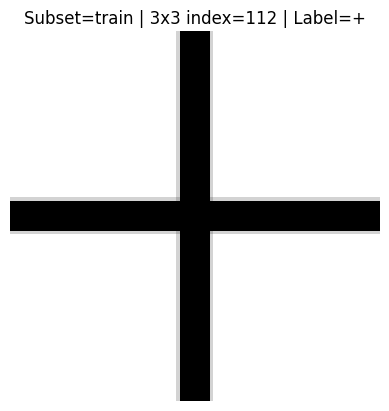

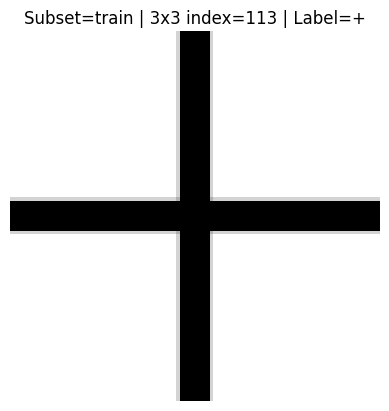

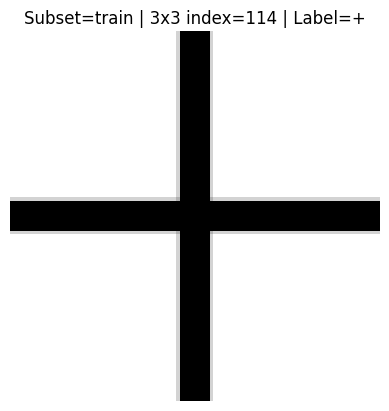

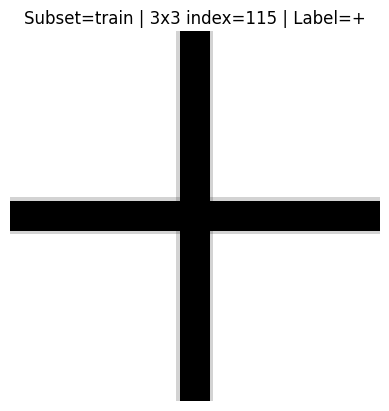

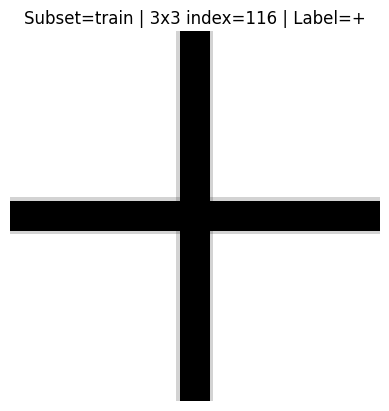

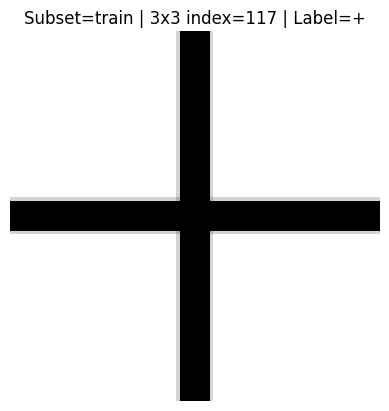

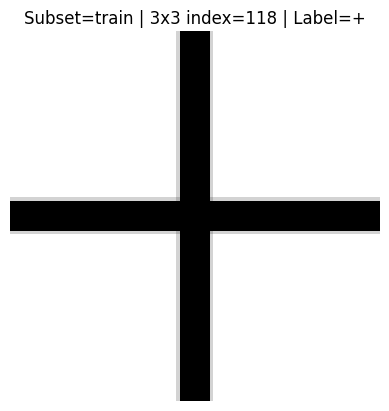

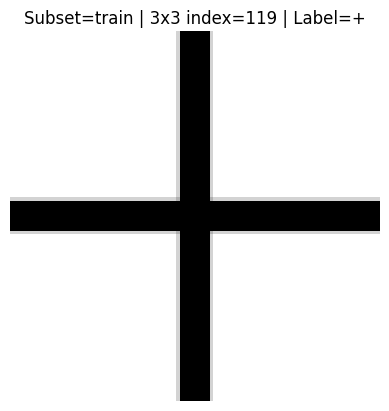

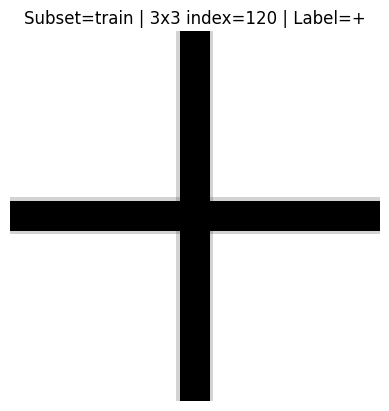

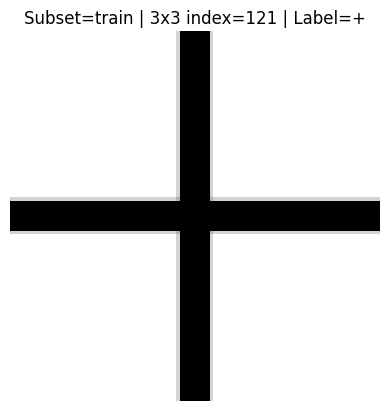

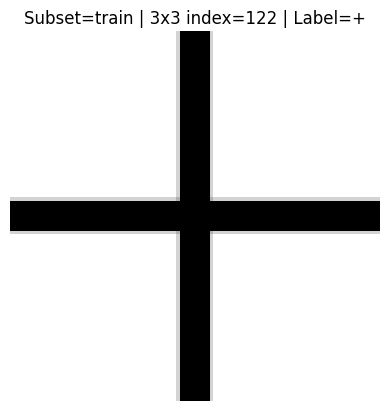

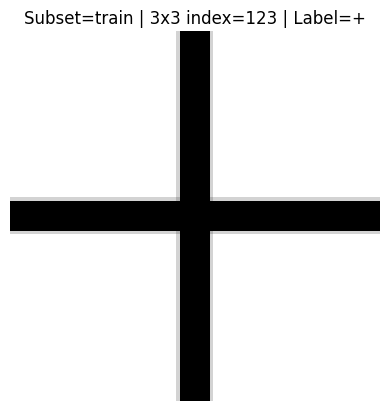

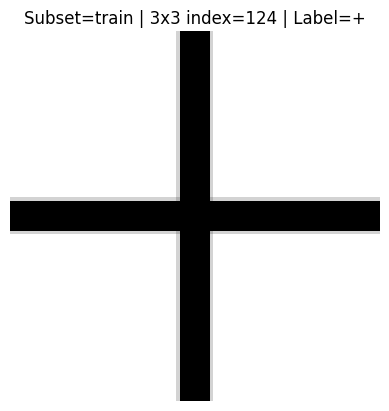

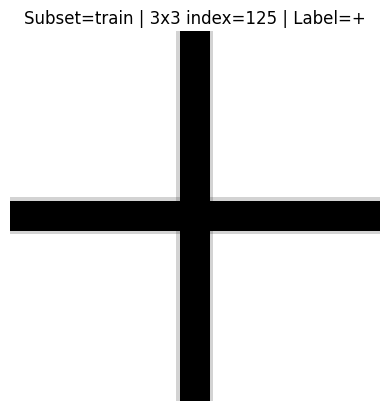

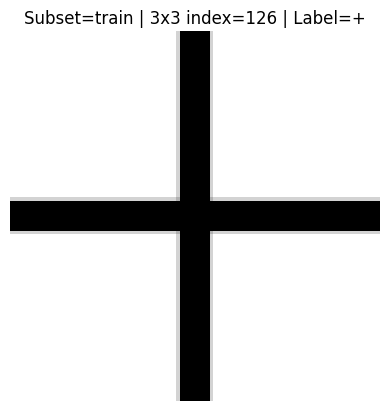

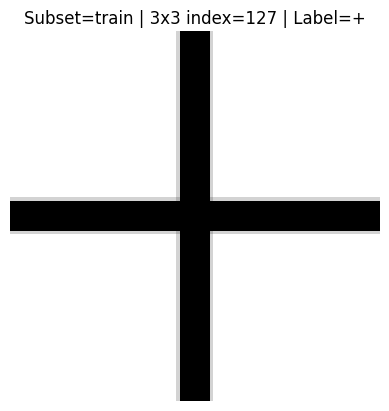

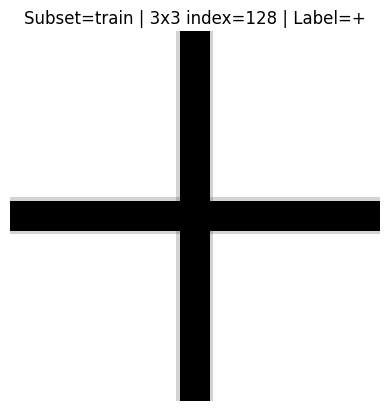

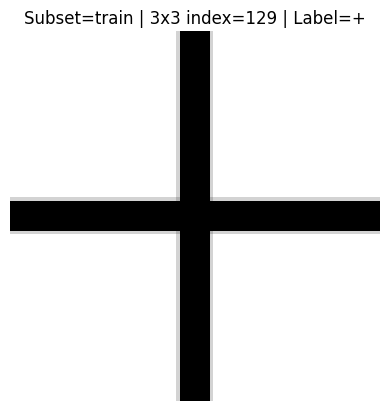

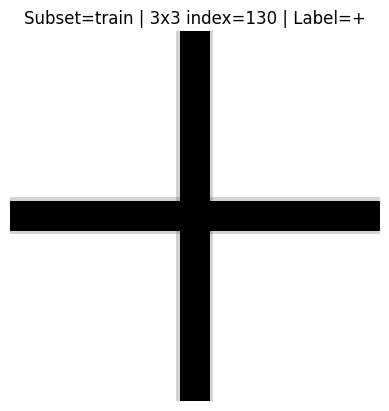

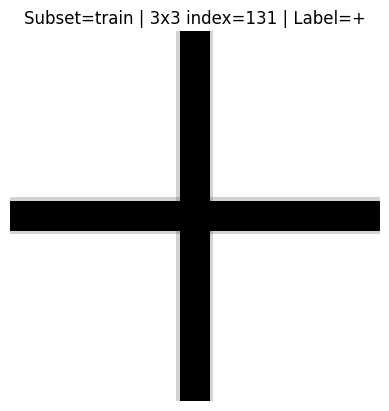

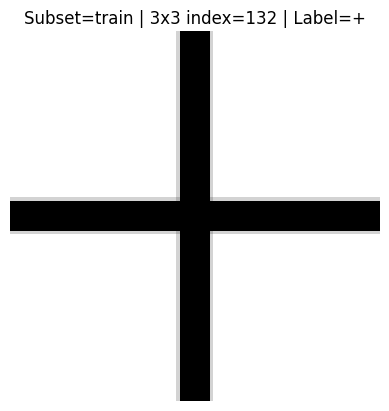

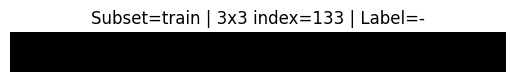

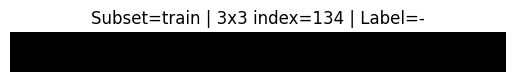

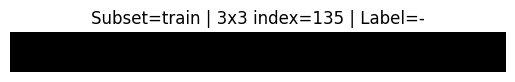

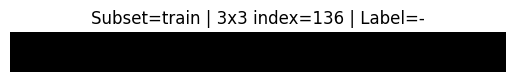

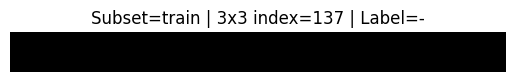

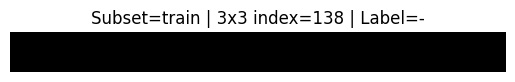

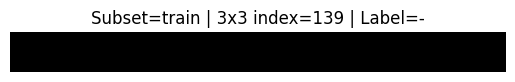

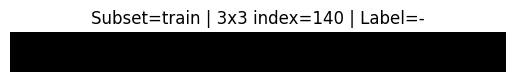

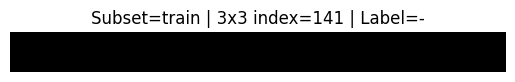

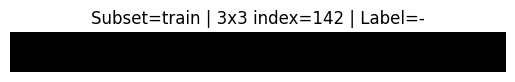

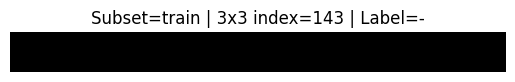

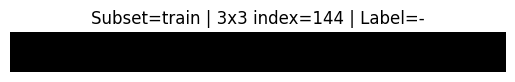

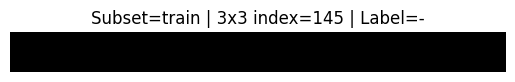

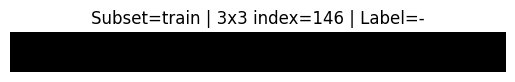

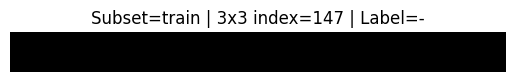

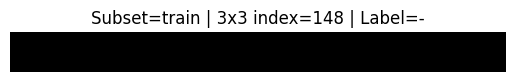

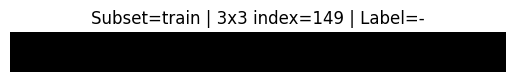

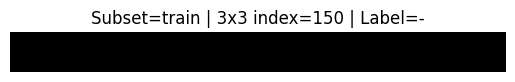

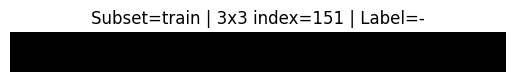

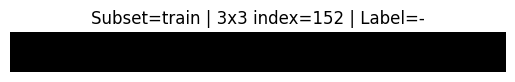

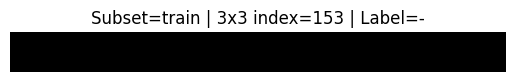

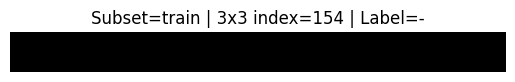

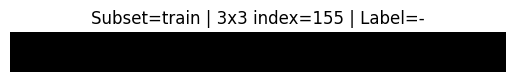

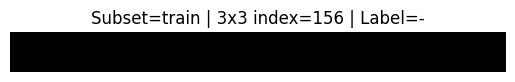

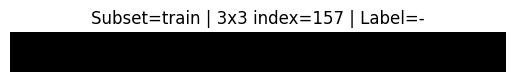

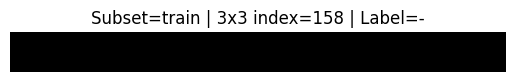

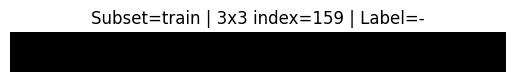

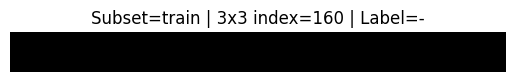

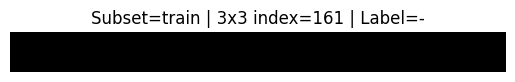

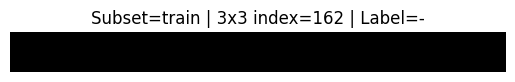

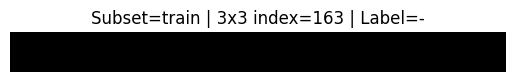

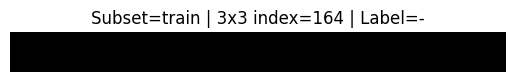

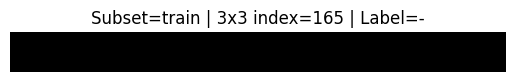

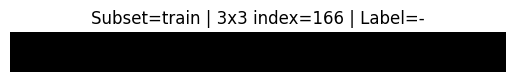

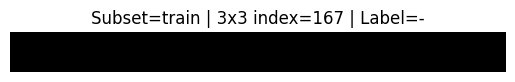

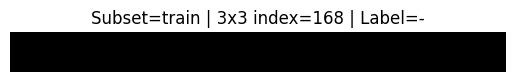

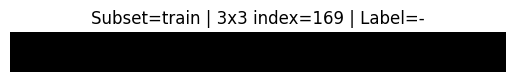

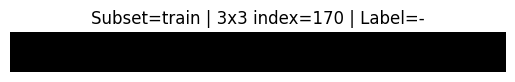

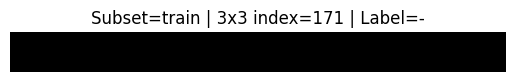

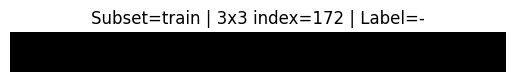

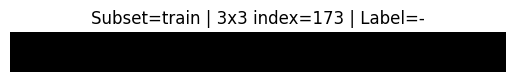

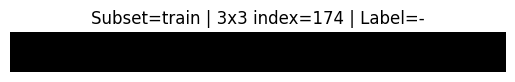

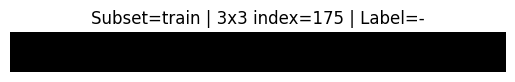

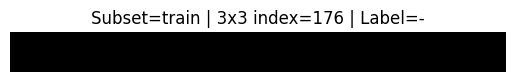

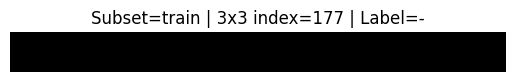

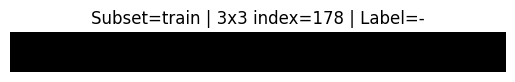

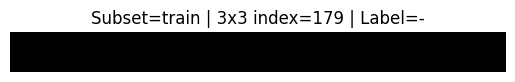

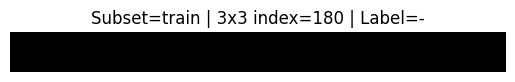

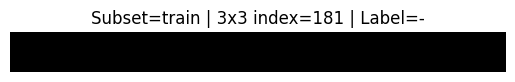

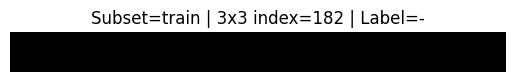

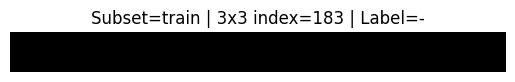

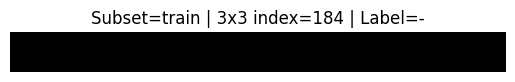

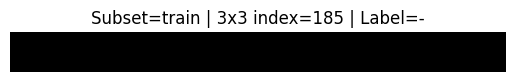

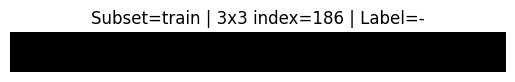

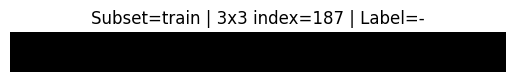

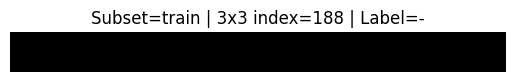

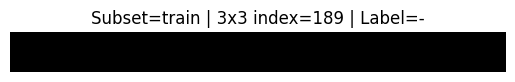

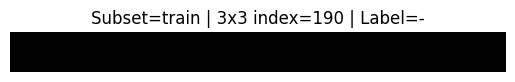

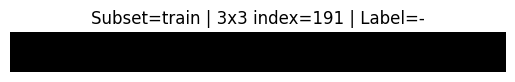

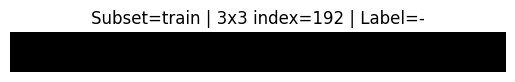

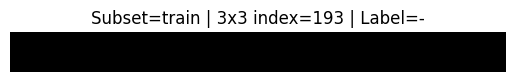

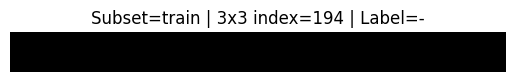

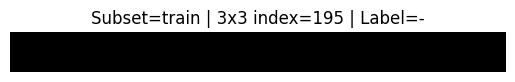

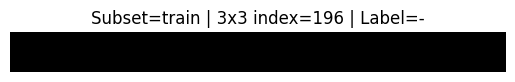

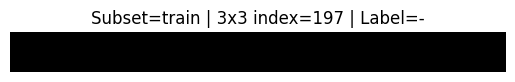

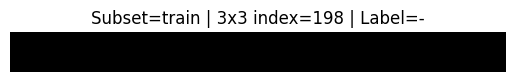

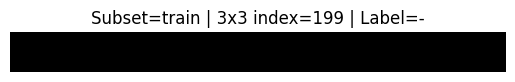

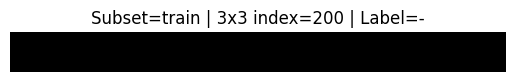

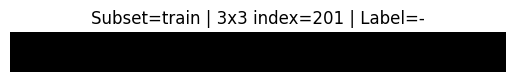

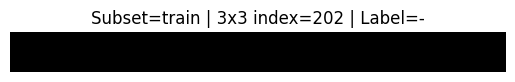

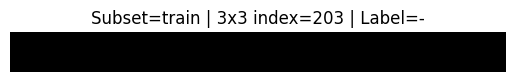

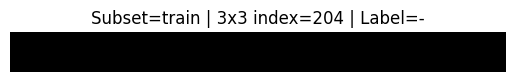

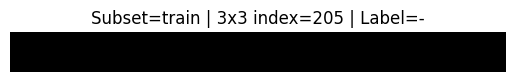

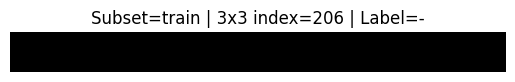

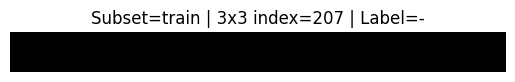

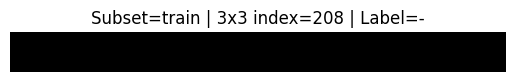

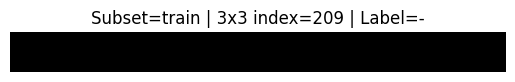

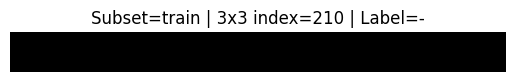

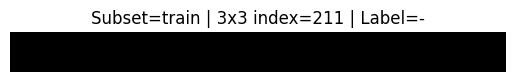

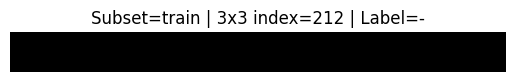

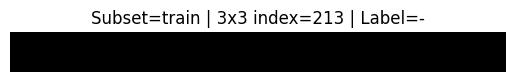

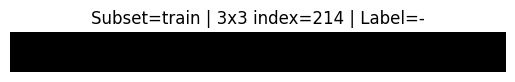

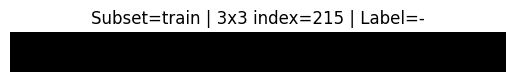

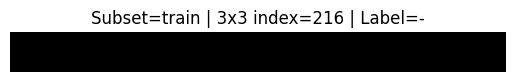

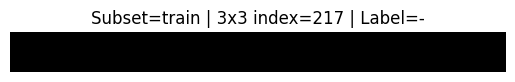

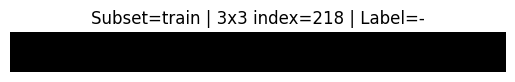

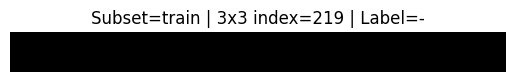

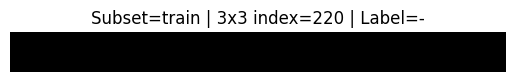

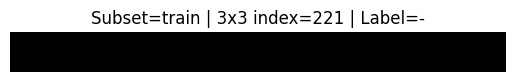

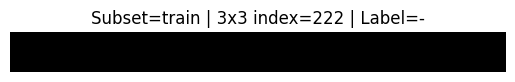

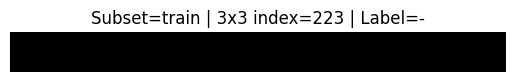

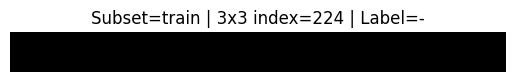

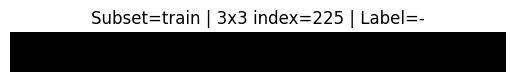

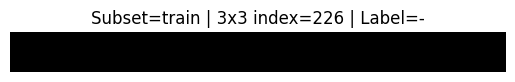

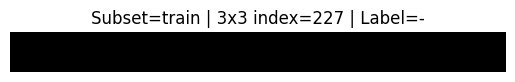

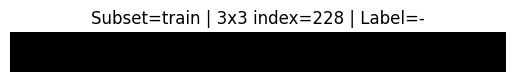

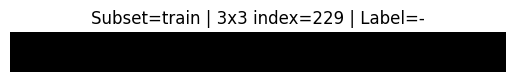

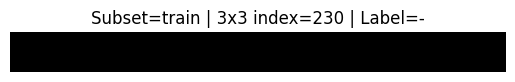

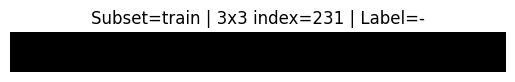

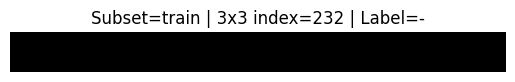

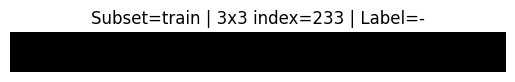

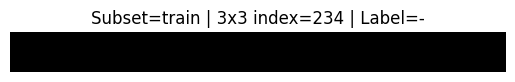

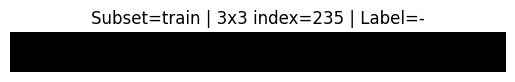

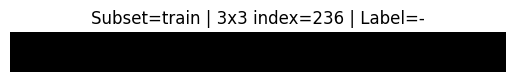

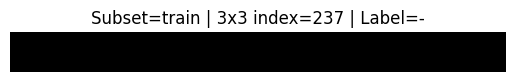

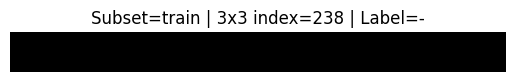

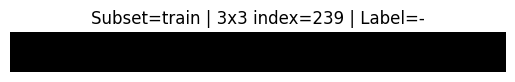

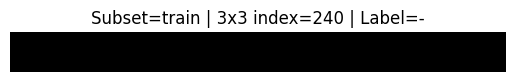

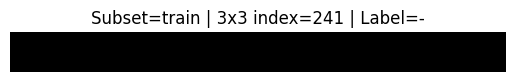

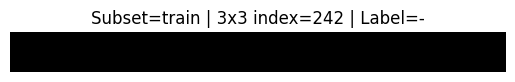

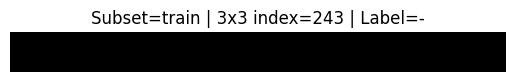

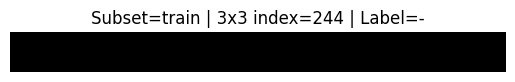

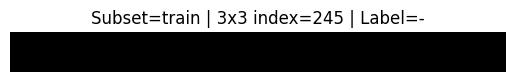

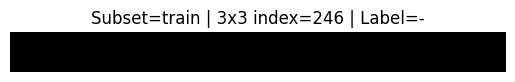

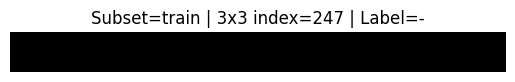

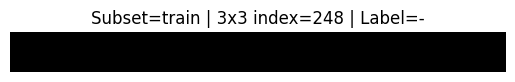

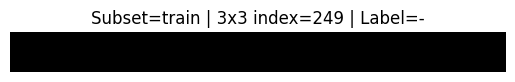

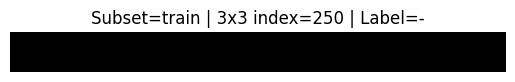

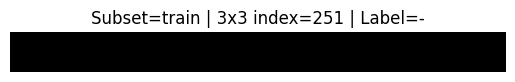

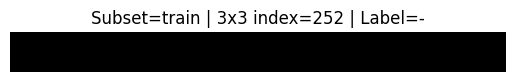

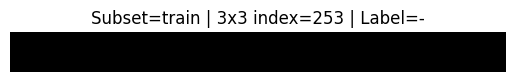

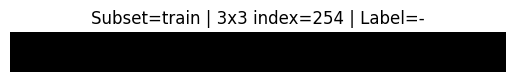

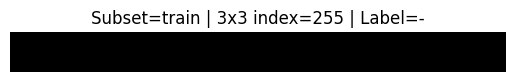

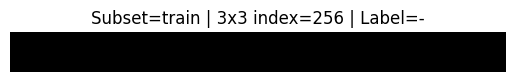

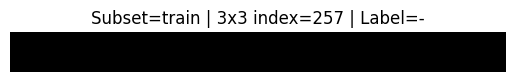

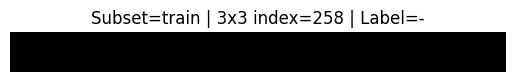

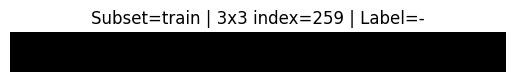

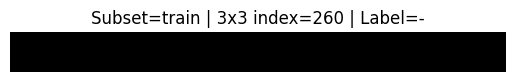

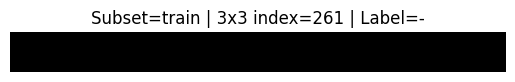

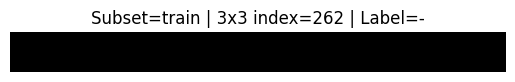

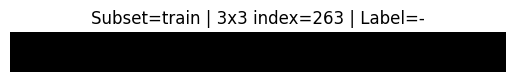

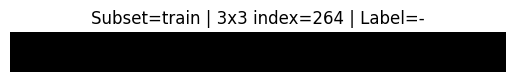

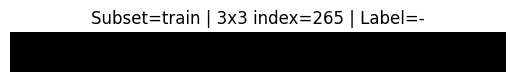

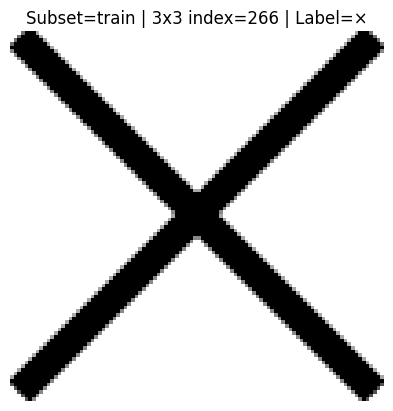

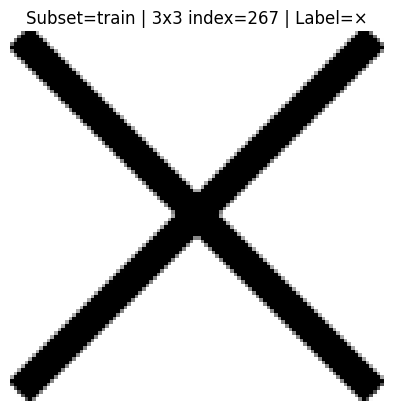

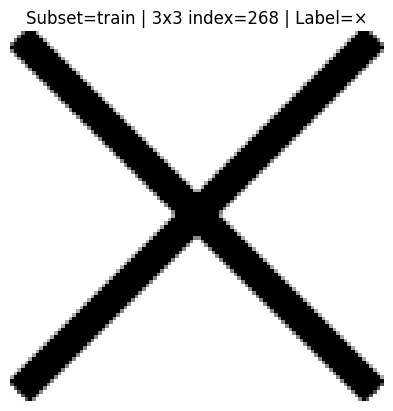

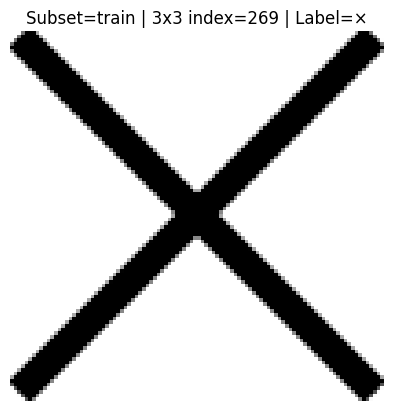

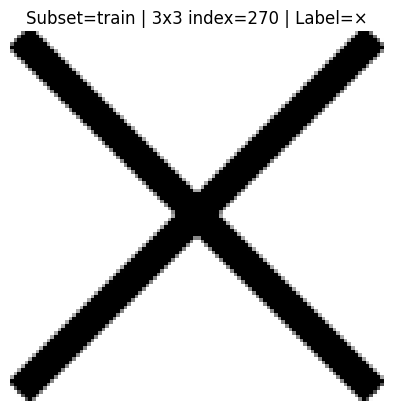

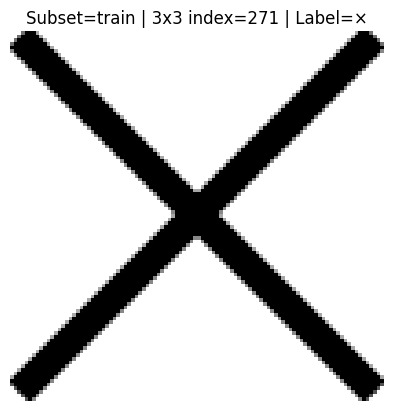

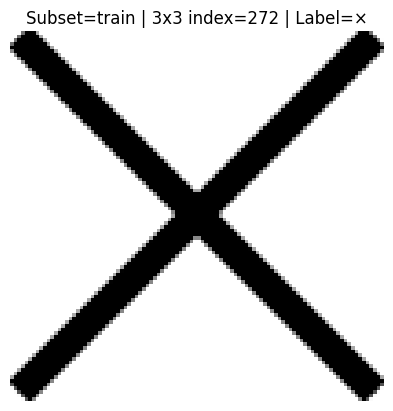

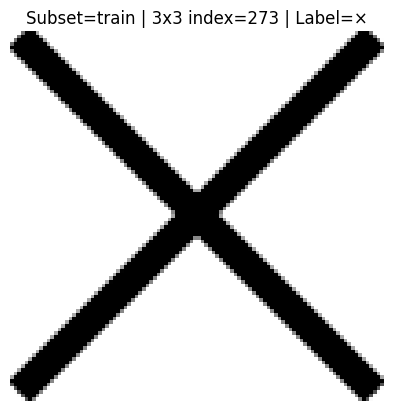

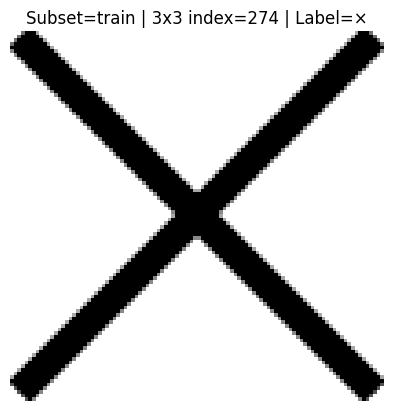

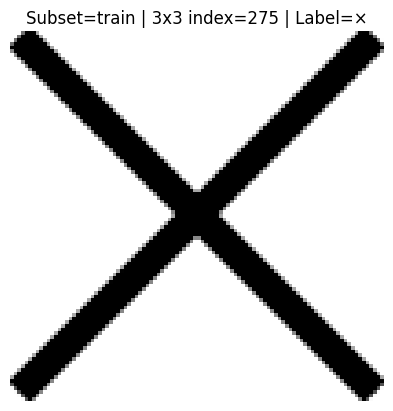

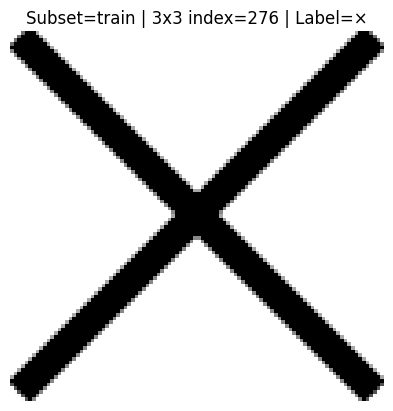

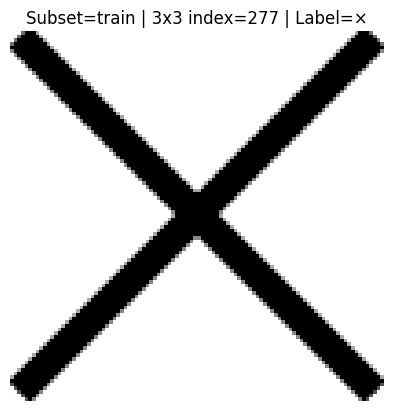

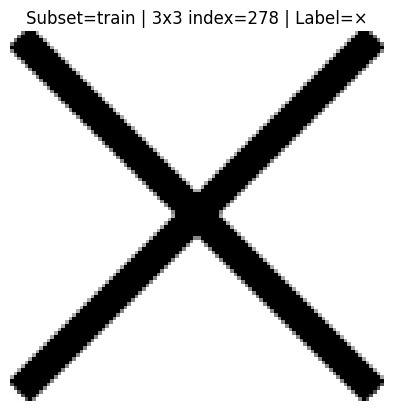

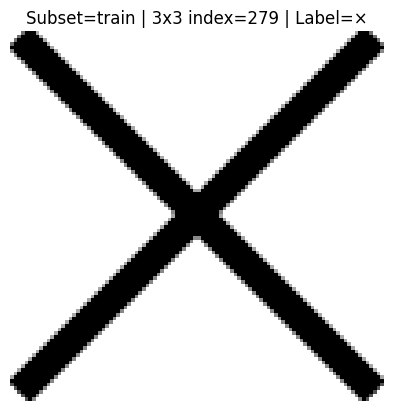

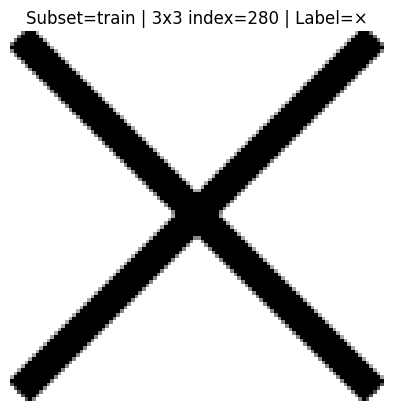

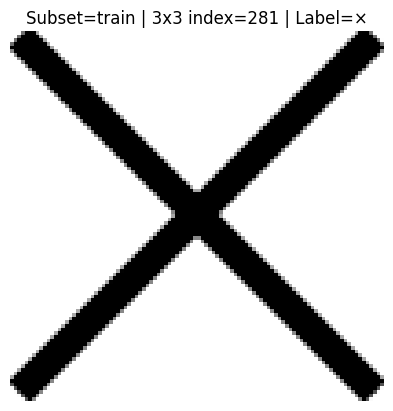

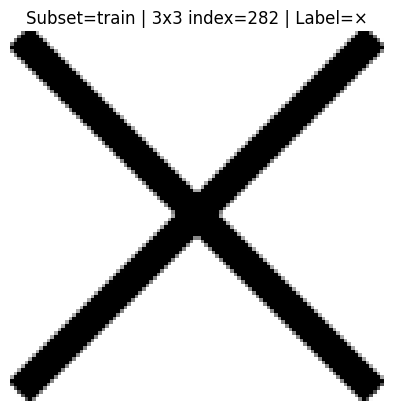

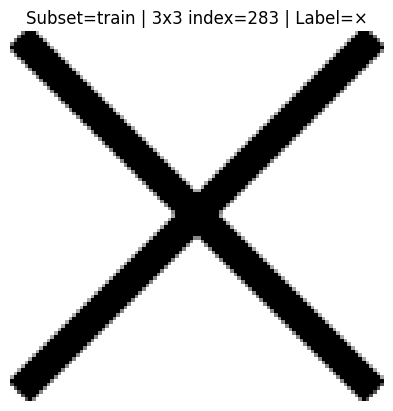

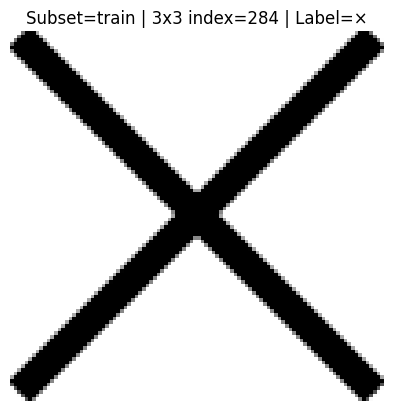

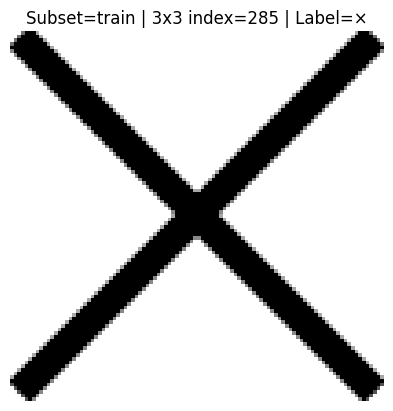

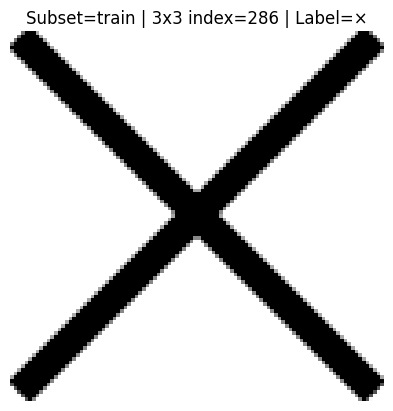

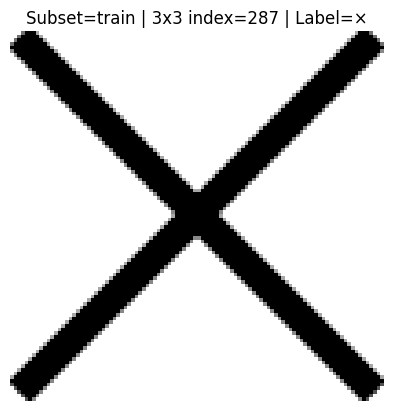

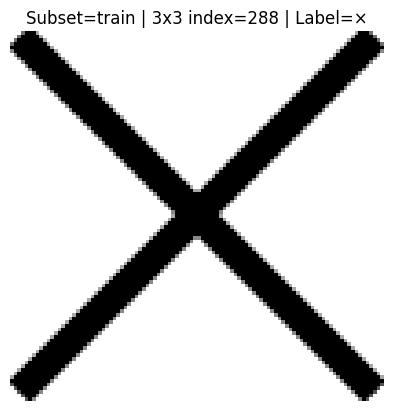

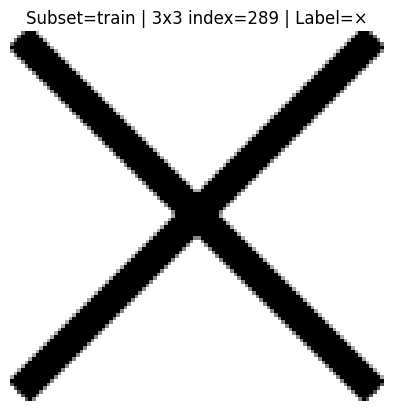

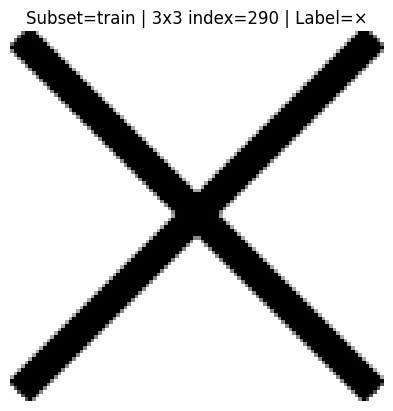

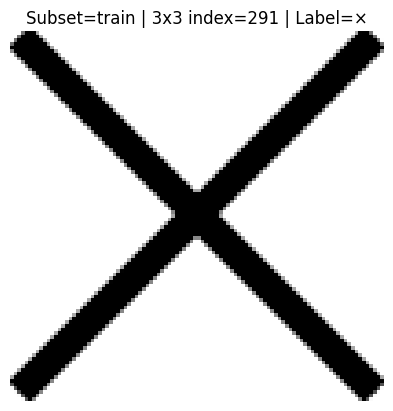

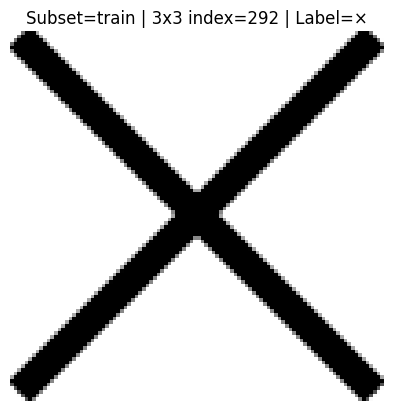

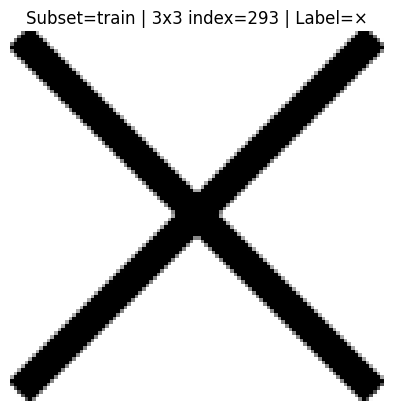

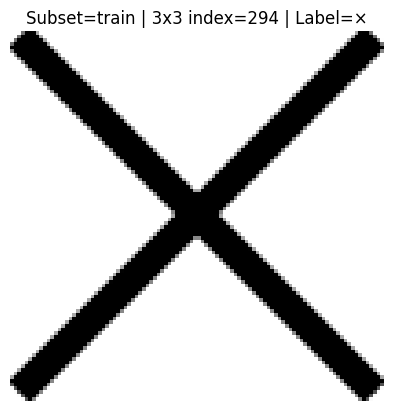

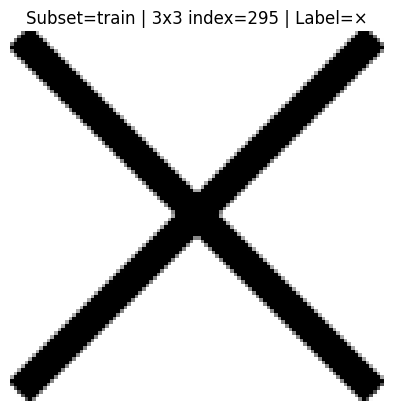

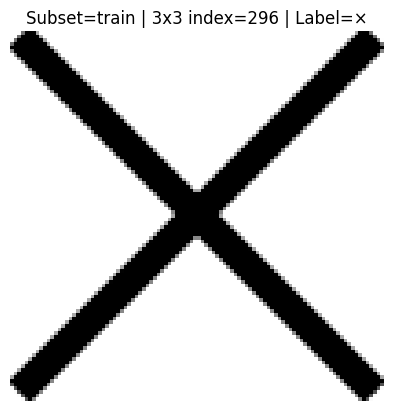

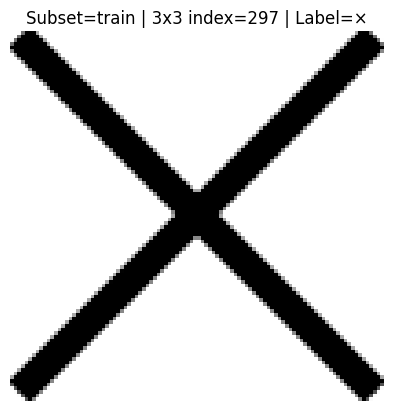

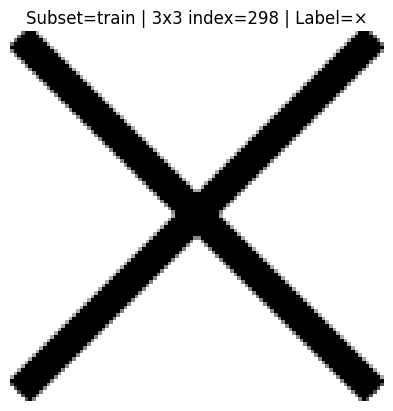

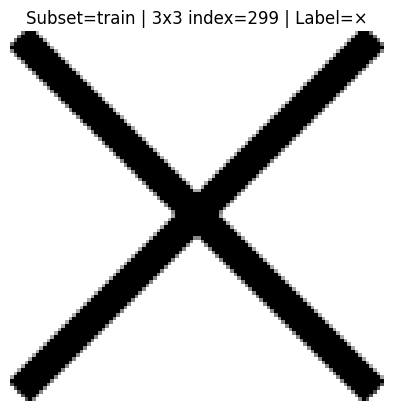

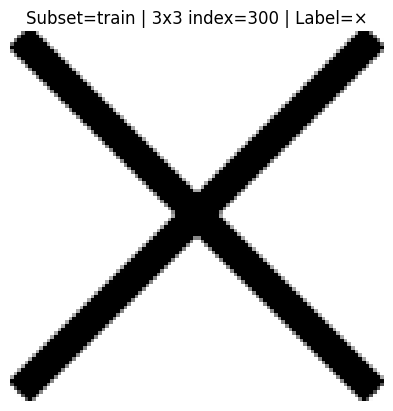

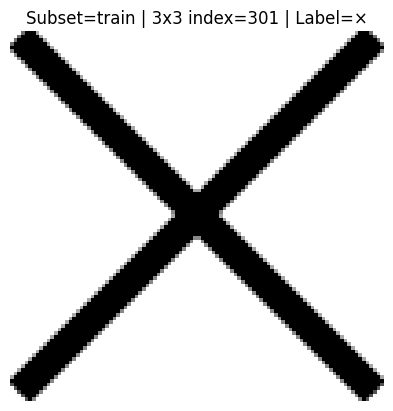

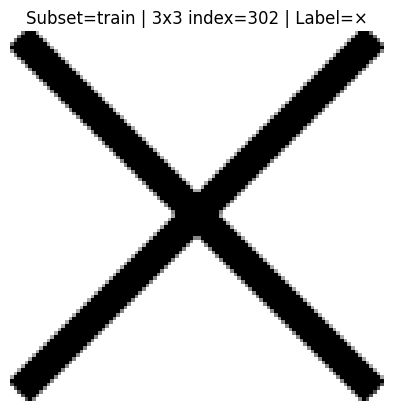

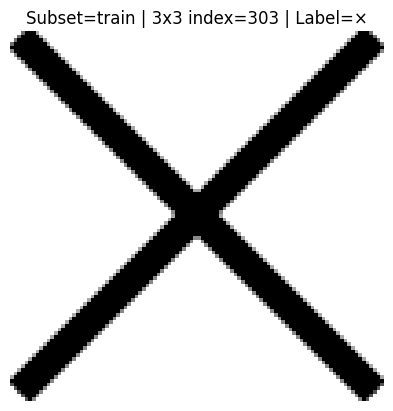

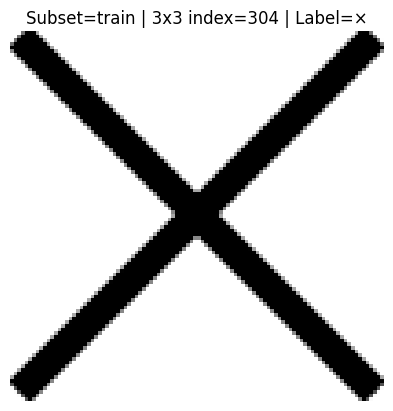

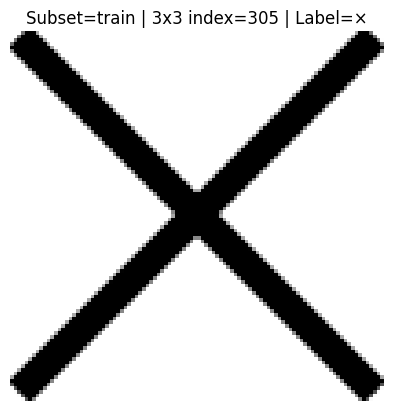

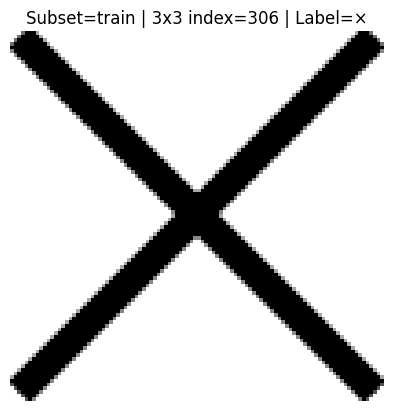

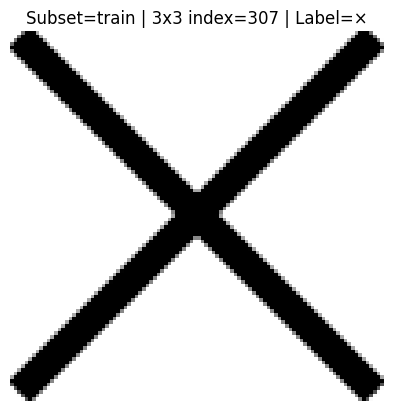

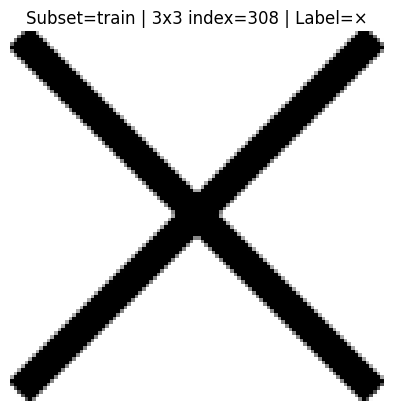

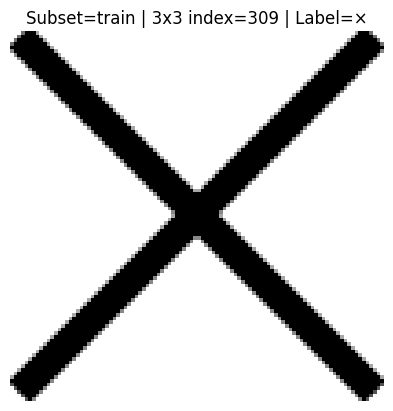

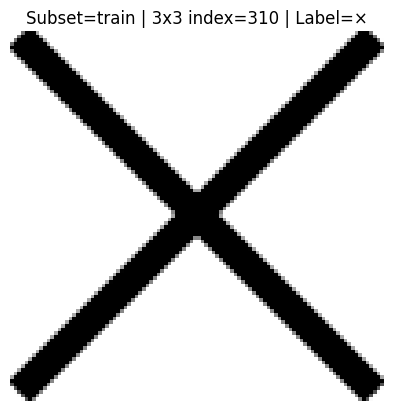

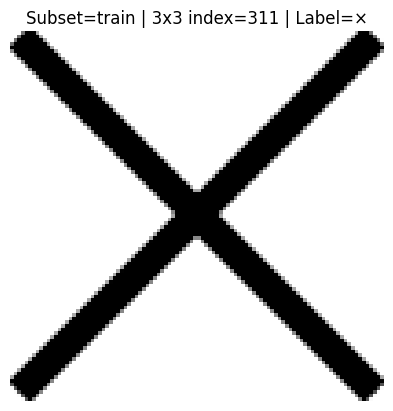

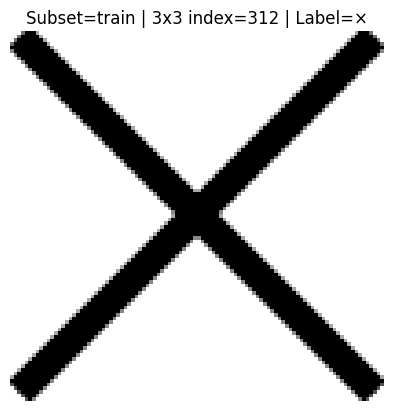

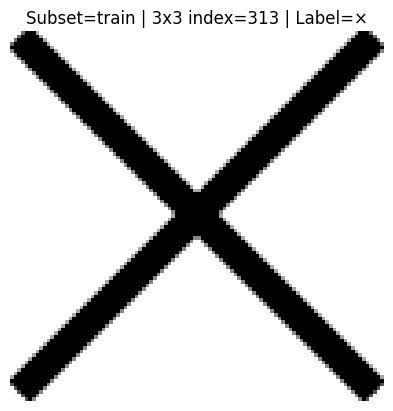

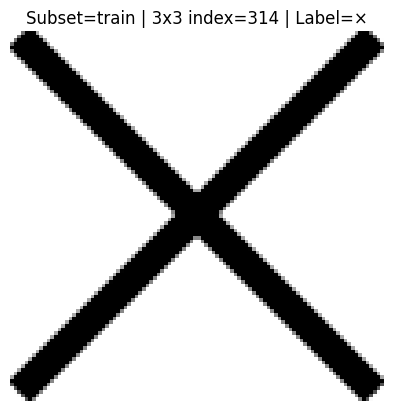

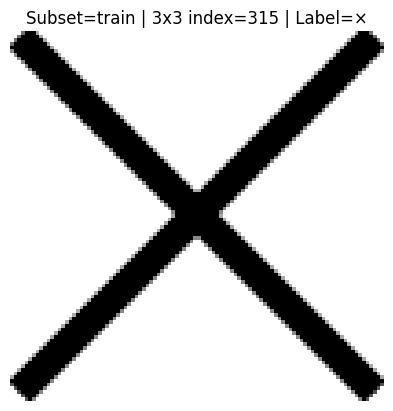

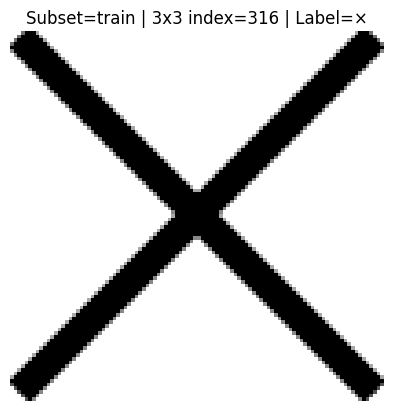

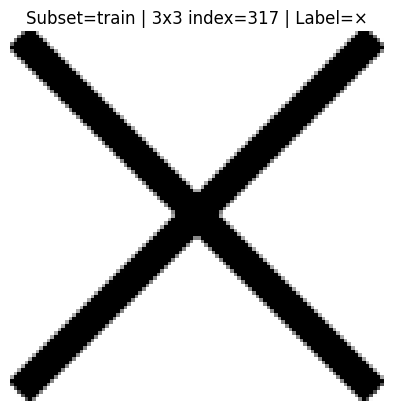

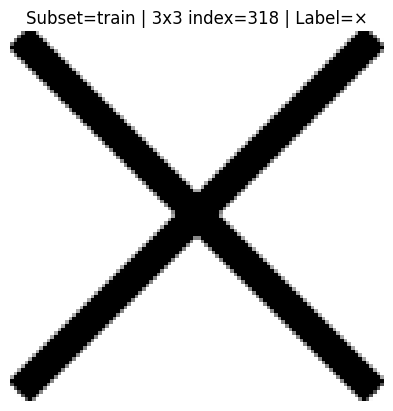

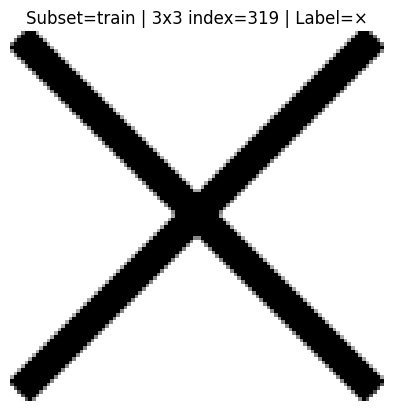

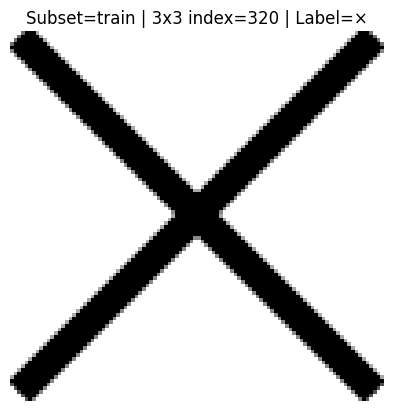

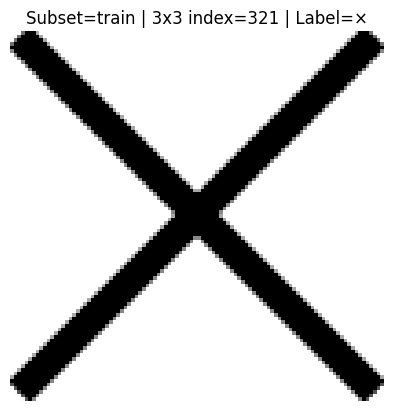

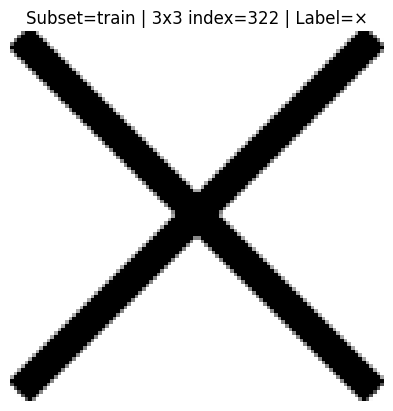

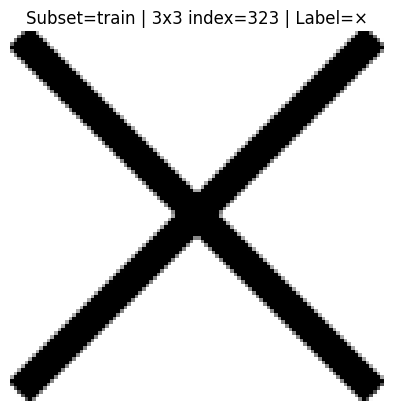

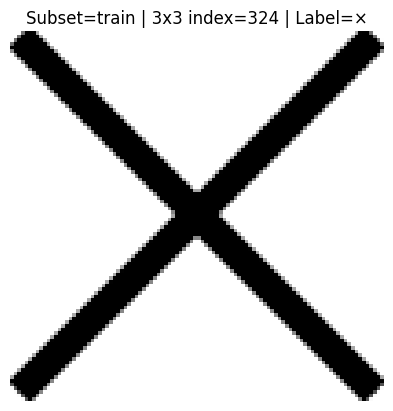

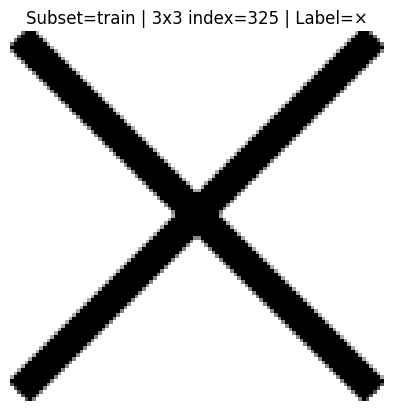

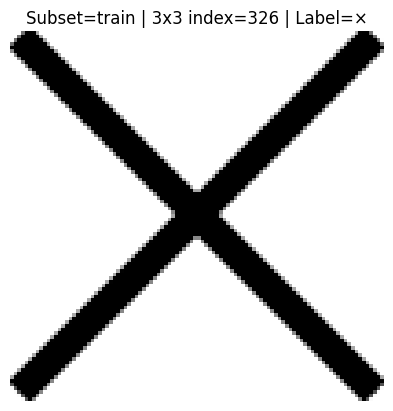

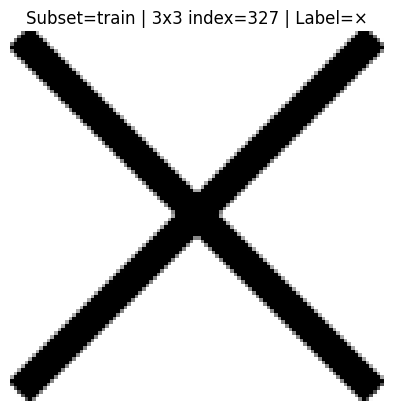

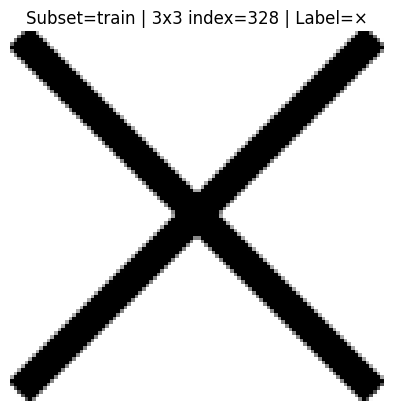

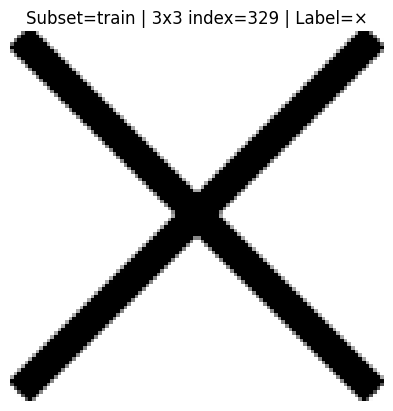

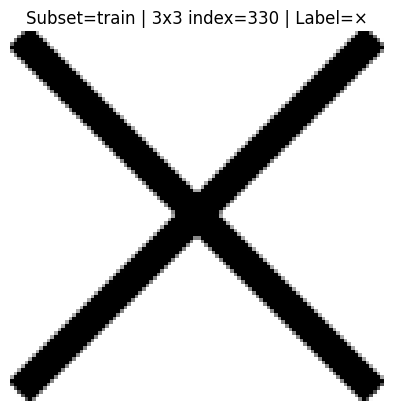

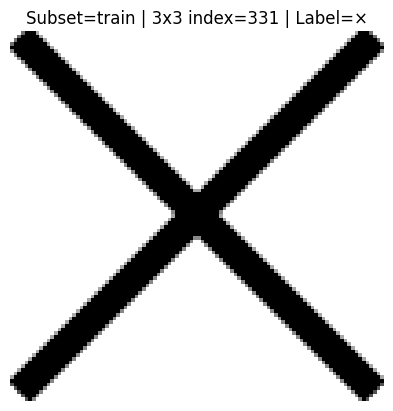

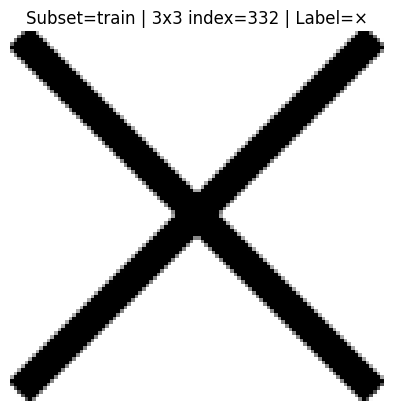

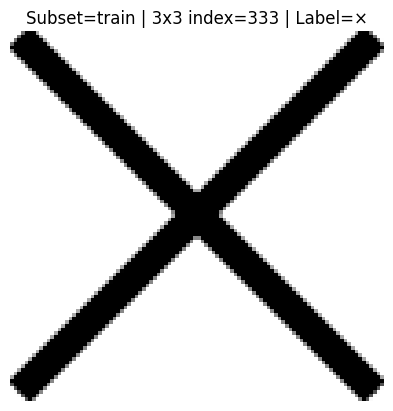

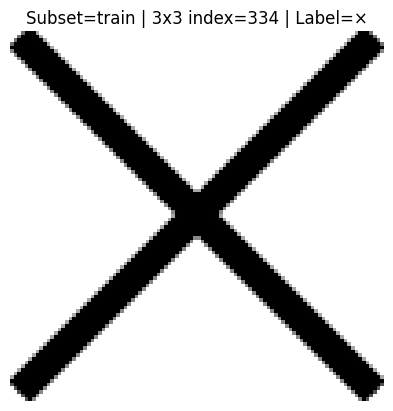

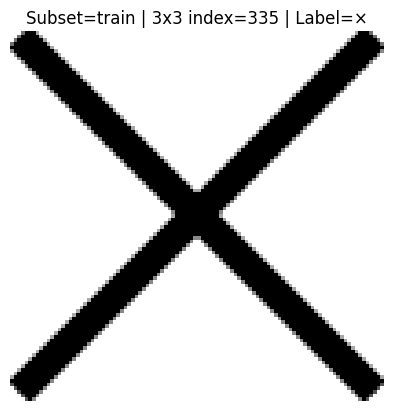

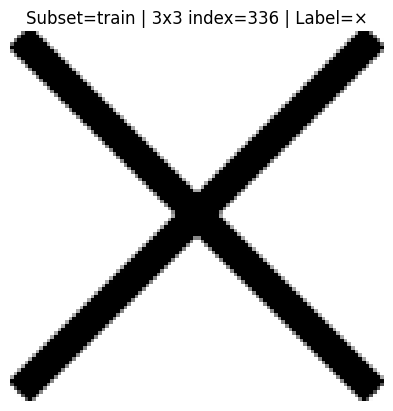

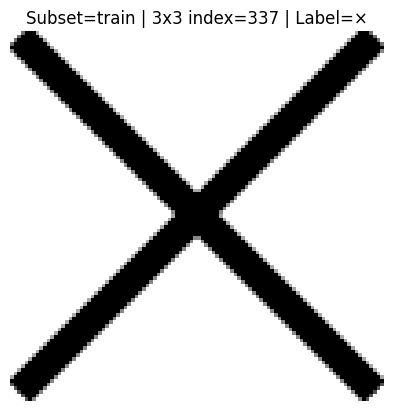

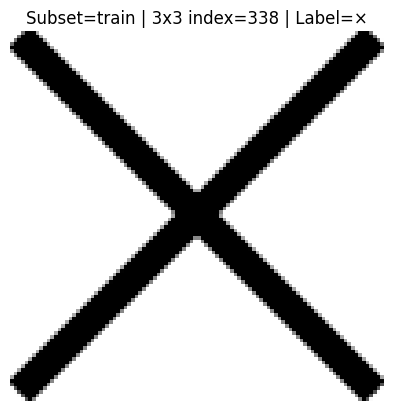

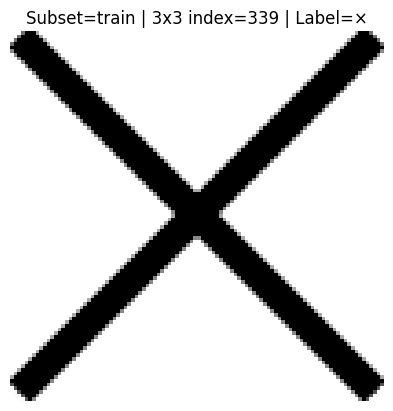

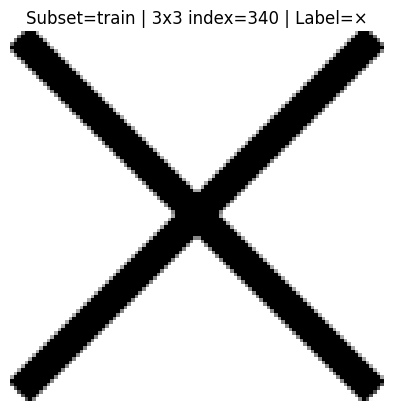

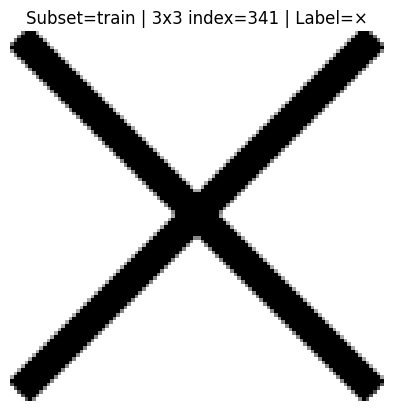

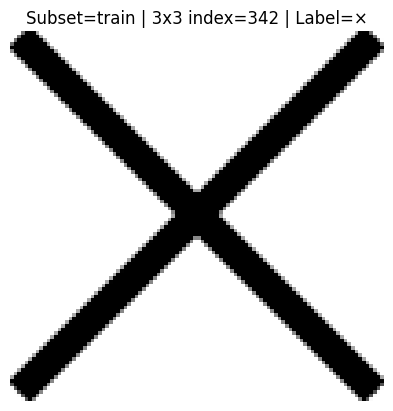

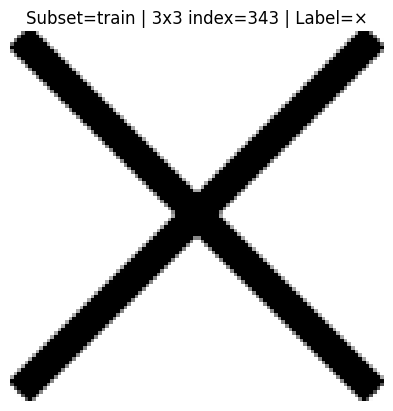

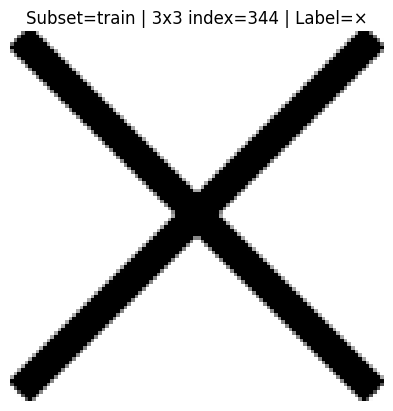

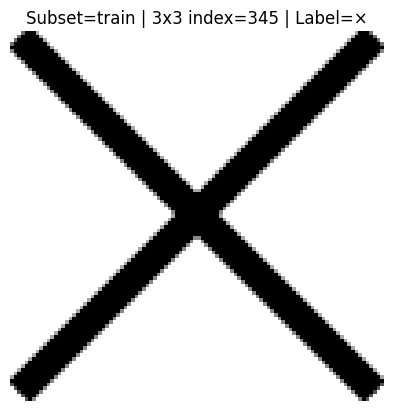

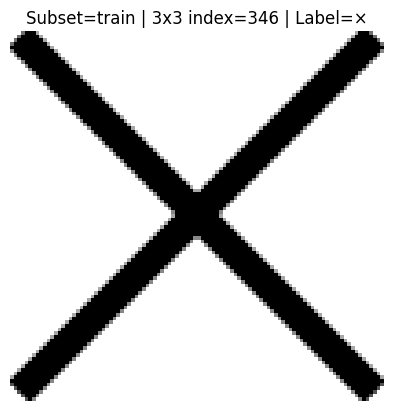

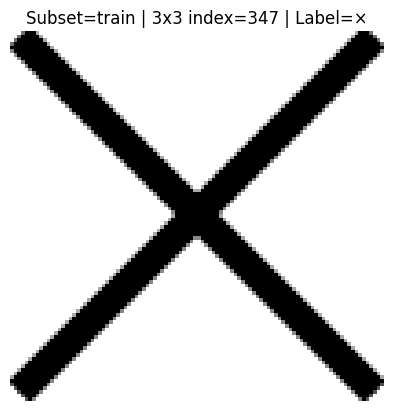

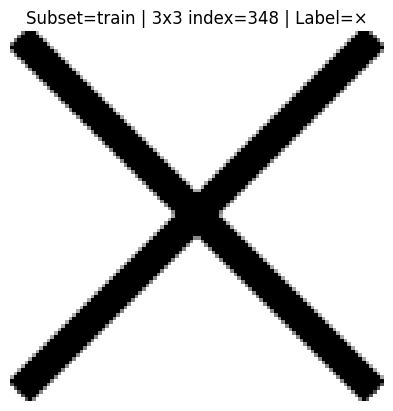

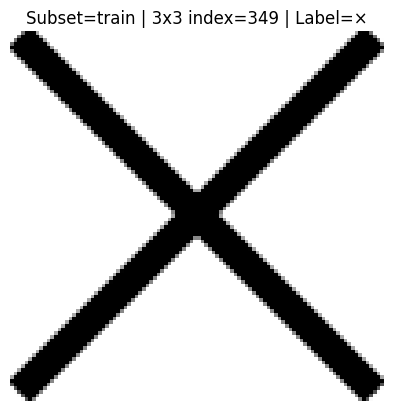

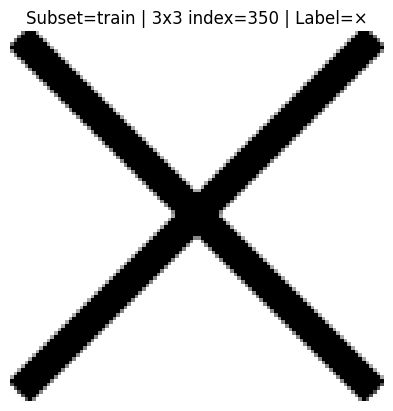

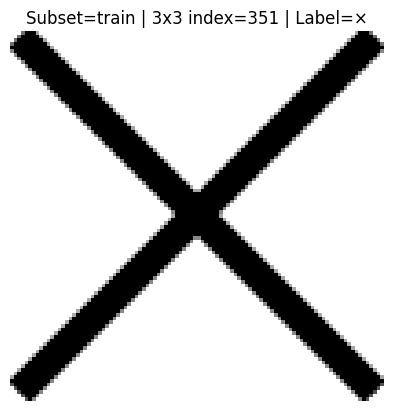

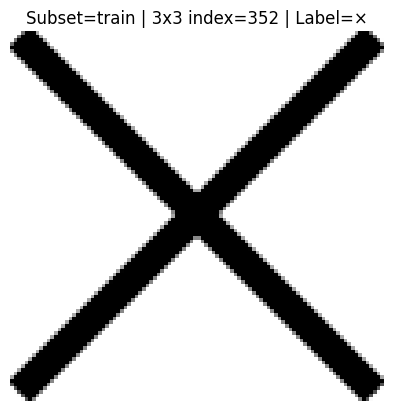

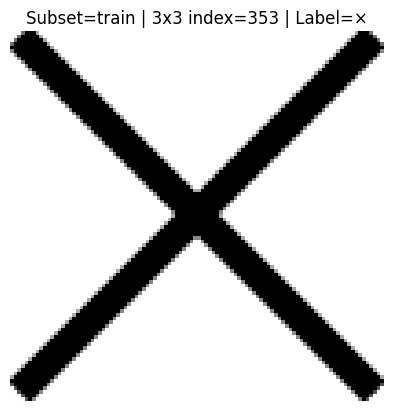

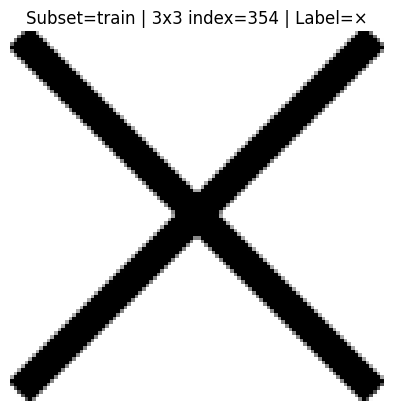

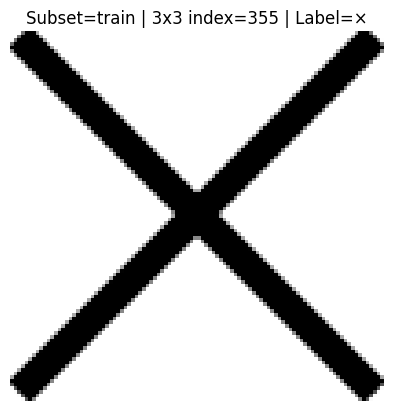

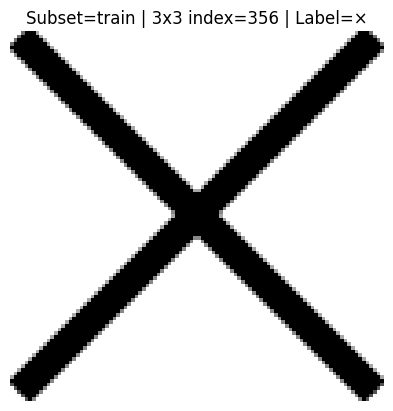

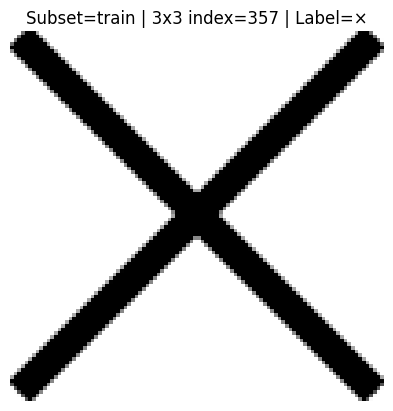

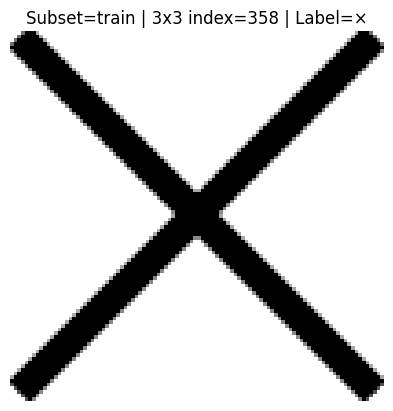

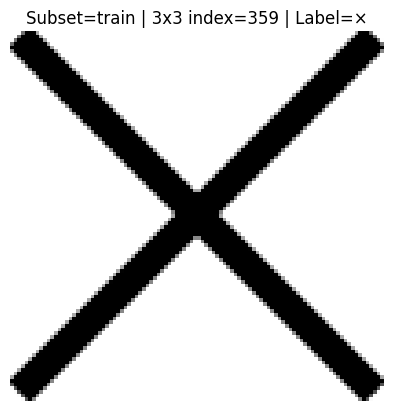

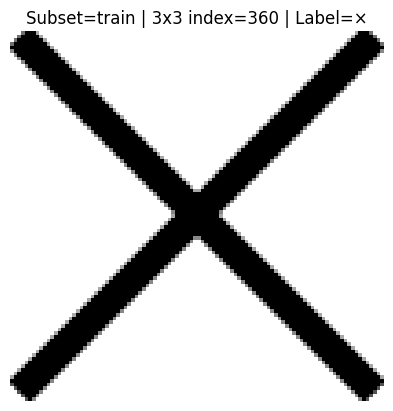

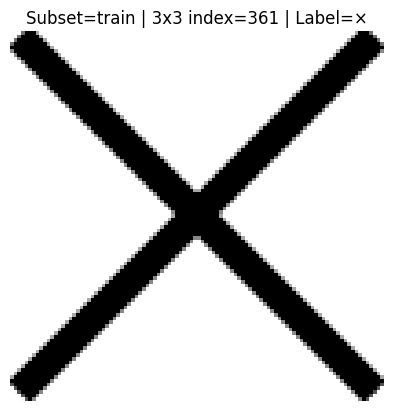

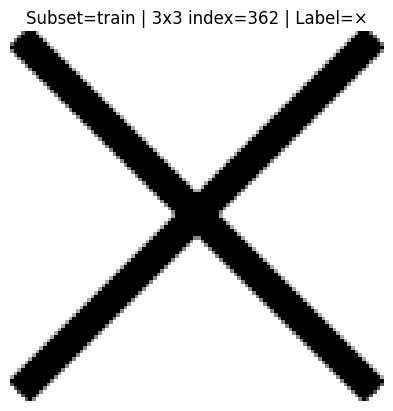

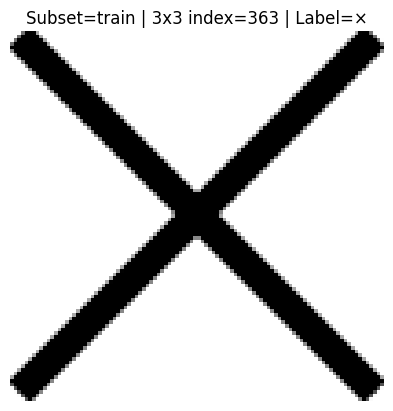

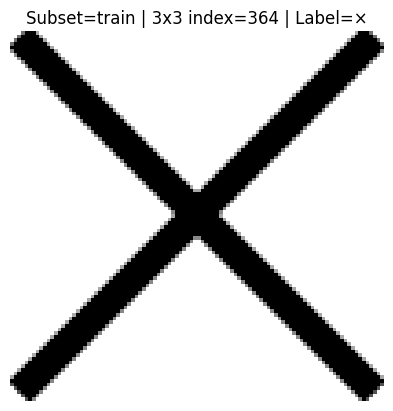

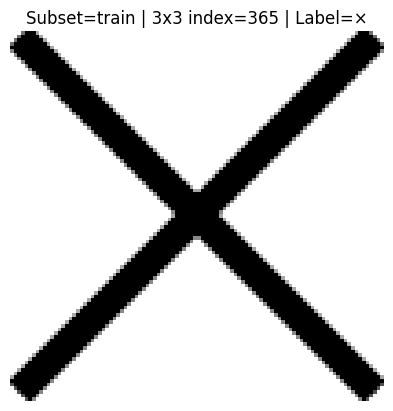

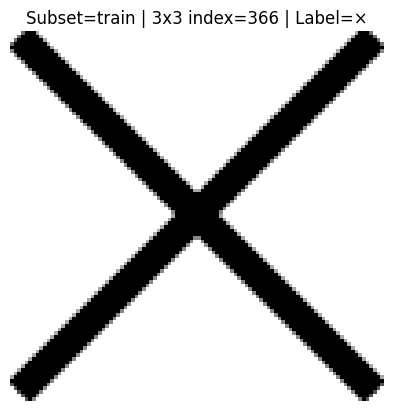

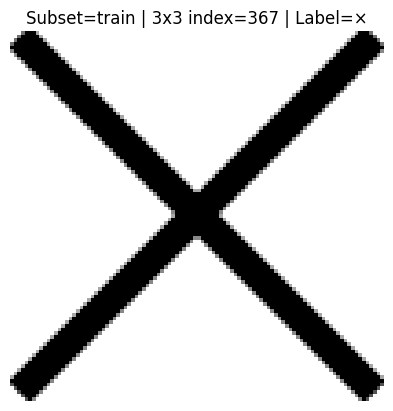

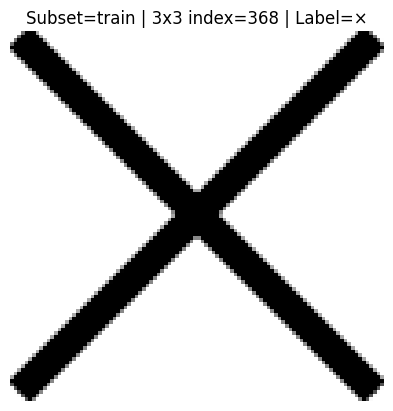

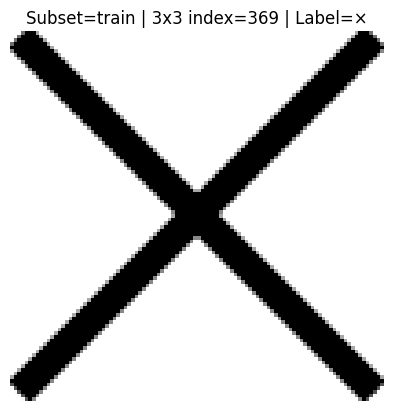

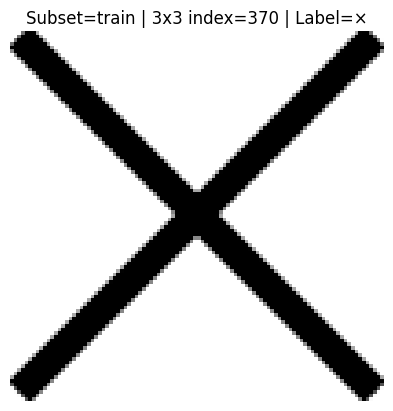

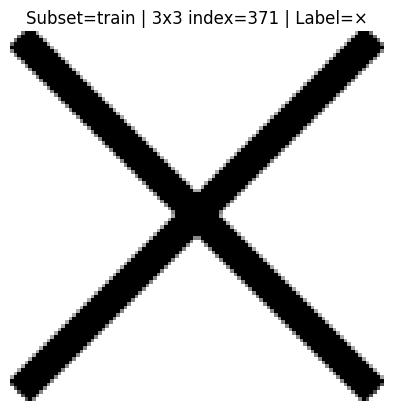

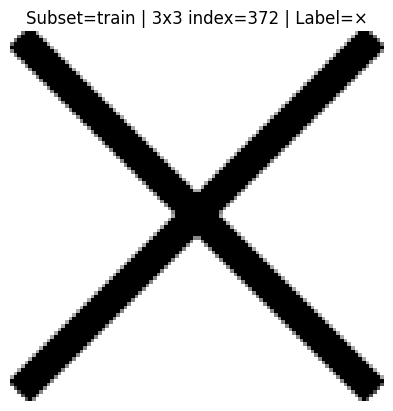

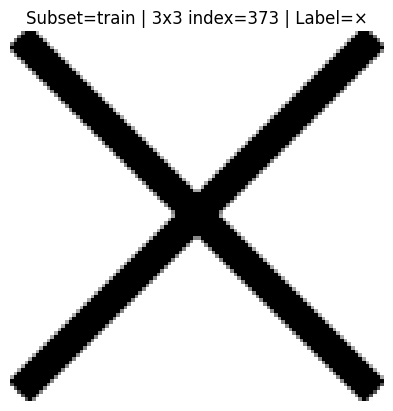

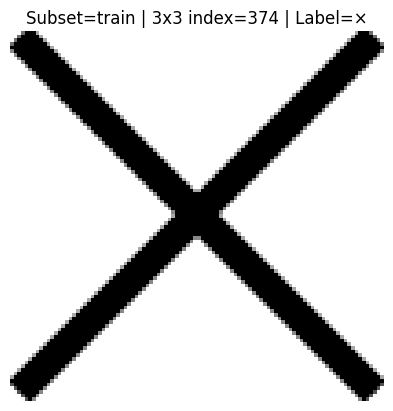

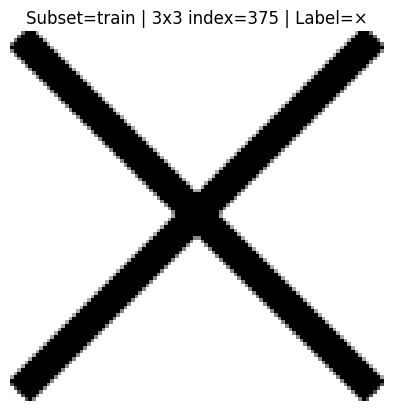

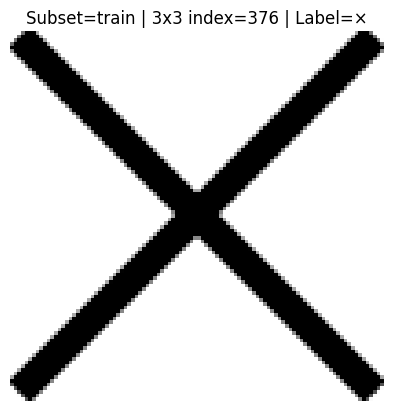

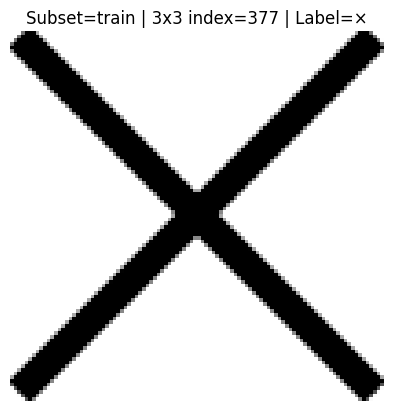

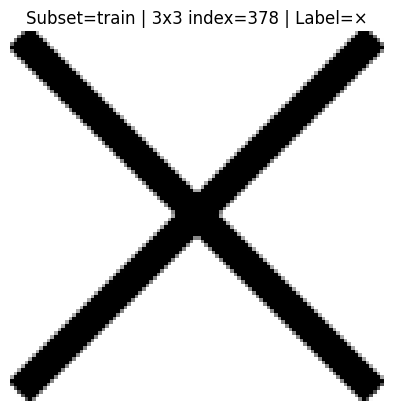

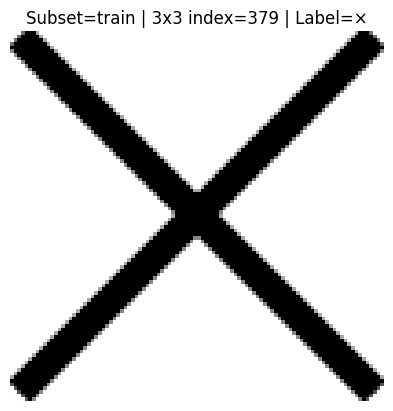

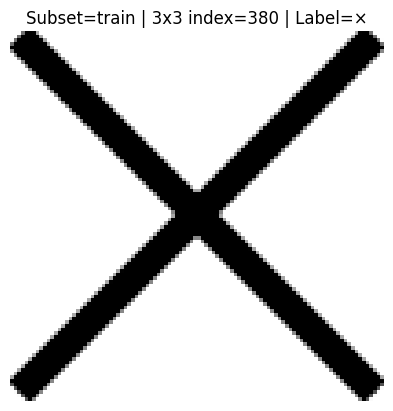

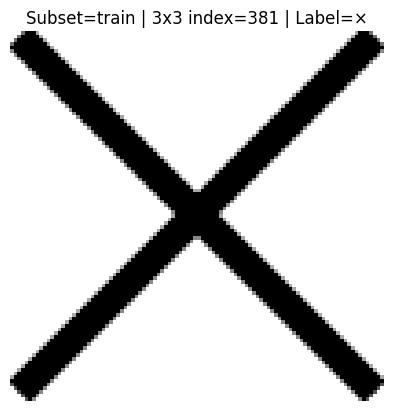

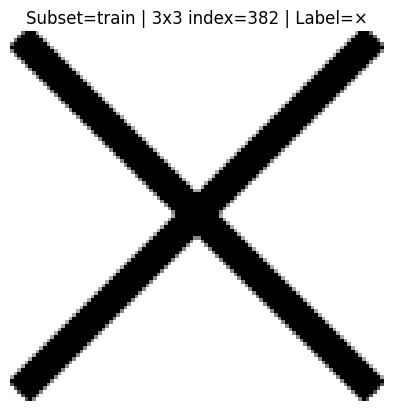

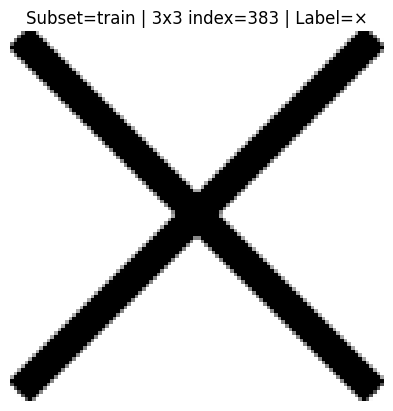

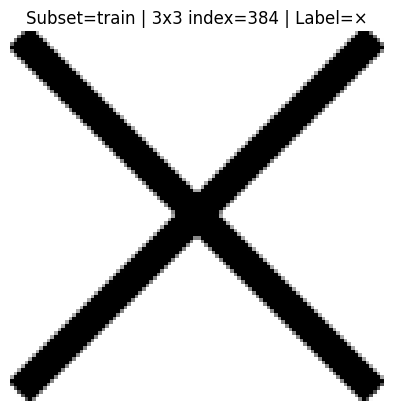

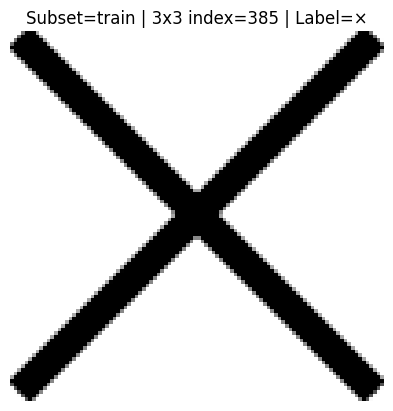

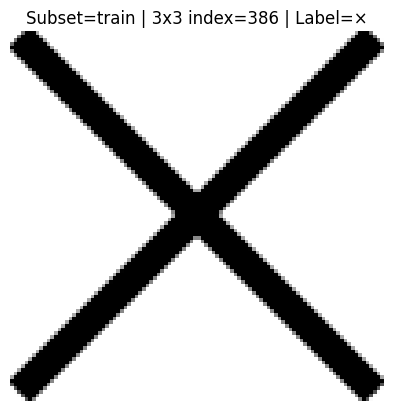

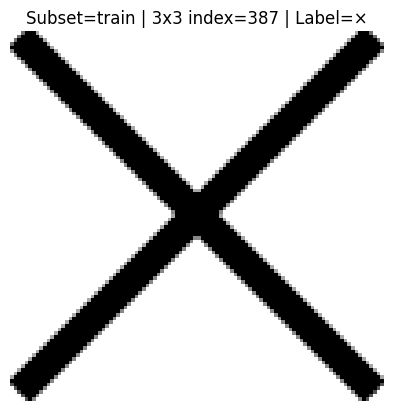

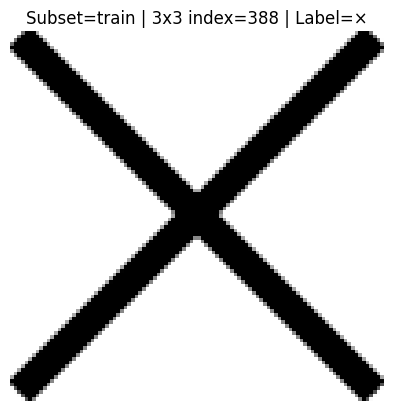

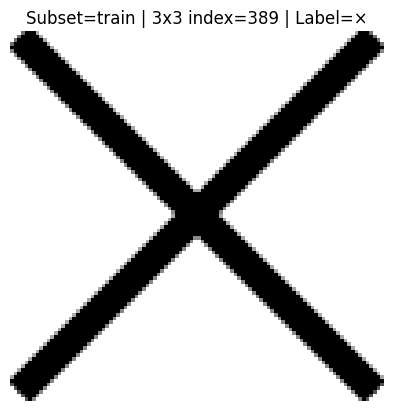

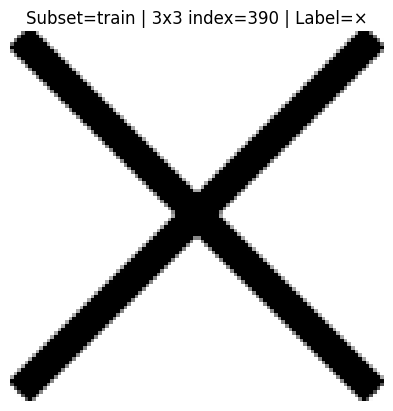

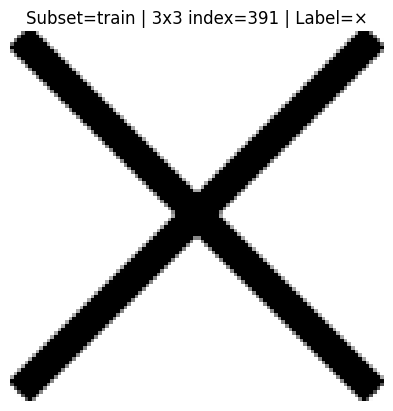

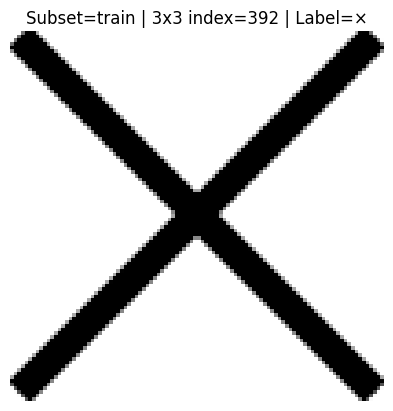

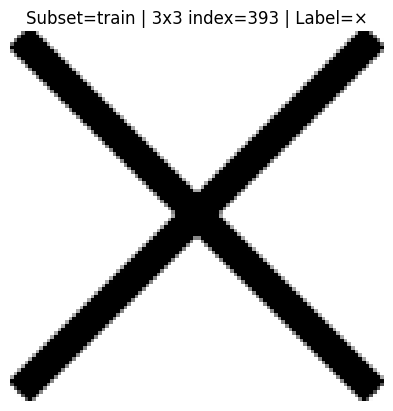

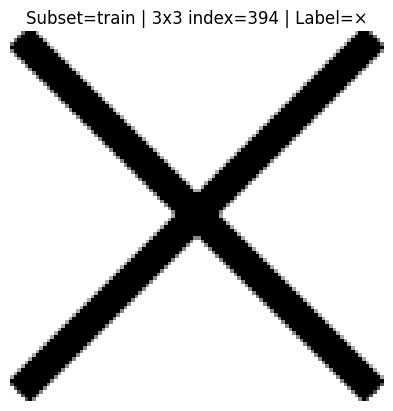

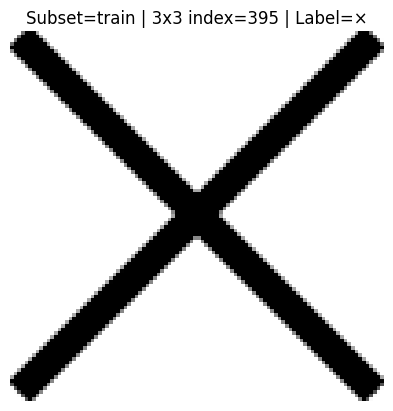

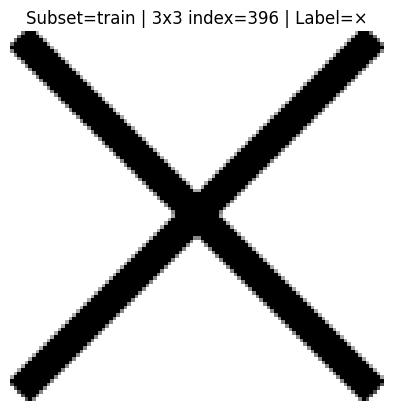

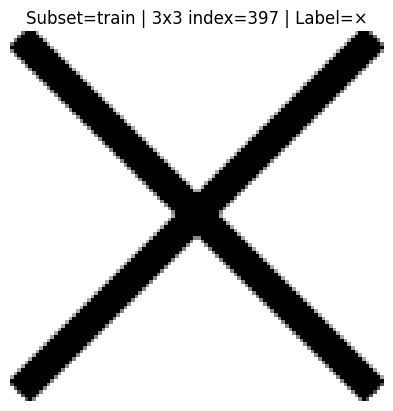

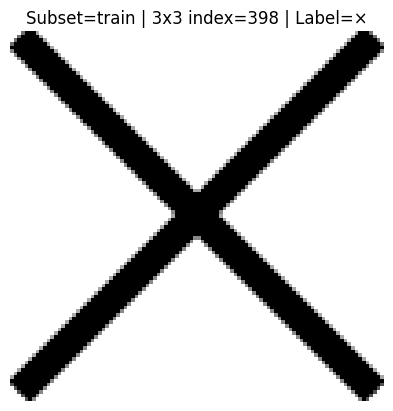

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

def display_ops_with_labels(base_dir="APS360/MNIST_dataset_op", subset="test"):
    """
    Display operator images and labels from 'ops' folder in the given subset.
    Assumes:
      - '2x2_op_{i}.png' correspond to operators_2x2.npy (label index i)
      - '3x3_op_{i}.png' correspond to operators_3x3.npy (label index i)
    """

    subset_dir = os.path.join(base_dir, subset)
    ops_dir = os.path.join(subset_dir, "ops")
    if not os.path.exists(ops_dir):
        print(f"No ops folder found in {ops_dir}")
        return

    # Load label arrays
    op2x2_path = os.path.join(subset_dir, "operators_2x2.npy")
    op3x3_path = os.path.join(subset_dir, "operators_3x3.npy")

    if not (os.path.isfile(op2x2_path) and os.path.isfile(op3x3_path)):
        print(f"Missing operators_2x2.npy or operators_3x3.npy in {subset_dir}")
        return

    two_by_two_labels = np.load(op2x2_path)
    three_by_three_labels = np.load(op3x3_path)

    # 1) Display 2×2 operator images
    for i, label in enumerate(two_by_two_labels):
        op_filename = f"2x2_op_{i}.png"  # matches the naming in process_operators
        op_path = os.path.join(ops_dir, op_filename)
        if not os.path.isfile(op_path):
            print(f"[Warning] {op_path} not found.")
            continue

        op_img = cv2.imread(op_path, cv2.IMREAD_GRAYSCALE)
        if op_img is None:
            print(f"[Warning] Could not read image {op_path}")
            continue

        plt.figure()
        plt.imshow(op_img, cmap='gray')
        plt.title(f"Subset={subset} | 2x2 index={i} | Label={label}")
        plt.axis('off')
        plt.show()

    # 2) Display 3×3 operator images
    for i, label in enumerate(three_by_three_labels):
        op_filename = f"3x3_op_{i}.png"
        op_path = os.path.join(ops_dir, op_filename)
        if not os.path.isfile(op_path):
            print(f"[Warning] {op_path} not found.")
            continue

        op_img = cv2.imread(op_path, cv2.IMREAD_GRAYSCALE)
        if op_img is None:
            print(f"[Warning] Could not read image {op_path}")
            continue

        plt.figure()
        plt.imshow(op_img, cmap='gray')
        plt.title(f"Subset={subset} | 3x3 index={i} | Label={label}")
        plt.axis('off')
        plt.show()



# ---------------------------
# Example Usage
# ---------------------------
# Change subset to 'train', 'val', or 'test' as needed.
display_ops_with_labels(
    base_dir="MNIST_dataset_op",
    subset="train"
)
